## Recommendery System for Movies Platform Using Collaborative Filtering vs Funk SVD

### 1. Import Module

In [1]:
import pandas as pd
import numpy as np

### 2. Import Data

In [2]:
# Define column name 
m_cols = ['MovieIDS', 'Title', 'Genre']
r_cols = ['UserID', 'MovieIDs', 'Ratings', 'Timestamp']
u_cols = ['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code']

# Read csv of movies, ratings and users
df_movies = pd.read_csv('../data/movies.csv', sep='::', names=m_cols, encoding='latin-1', index_col=None, engine='python')
df_ratings = pd.read_csv('../data/ratings.csv', sep='::', names=r_cols, encoding='latin-1', index_col=None, engine='python')
df_users = pd.read_csv('../data/users.csv', sep='::', names=u_cols, encoding='latin-1', index_col=None, engine='python')

In [3]:
# Cek shape dari dataframe
print(f"Shape dari movies : {df_movies.shape}")
print(f"Shape dari rating : {df_ratings.shape}")
print(f"Shape dari user : {df_users.shape}")

Shape dari movies : (3883, 3)
Shape dari rating : (1000209, 4)
Shape dari user : (6040, 5)


### 3. Pengecekan `"df_ratings"`

In [112]:
# Menampilkan df_ratings (batasi sampai user ke 966, cost computing)
df_ratings = df_ratings.loc[:150000,]

In [5]:
df_ratings.describe()

,UserID,MovieIDs,Ratings,Timestamp
count,150001.000000,150001.000000,150001.000000,1.500010e+05
mean,494.727668,1869.719022,3.593216,9.790929e+08
std,275.814942,1107.307911,1.109176,9.818332e+06
min,1.000000,1.000000,1.000000,9.751153e+08
25%,255.000000,1025.000000,3.000000,9.756284e+08
50%,509.000000,1831.000000,4.000000,9.763006e+08
75%,731.000000,2788.000000,4.000000,9.774809e+08
max,966.000000,3952.000000,5.000000,1.046389e+09


In [6]:
# Drop kolom yang tidak dibutuhkan untuk pemodelan 'Timestamp'
df_ratings = df_ratings.drop('Timestamp', axis=1)

In [116]:
# Cek tipe dari masing masing kolom
df_ratings.dtypes

UserID        int64
MovieIDs      int64
Ratings     float64
dtype: object

Untuk memodelkan rating dengan skala 0-5, diperlukan nilai float untuk mengakomodir angka desimal

In [117]:
# Konversi kolom "Ratings" menjadi float
df_ratings["Ratings"] = df_ratings["Ratings"].astype(float)

Handling terhadap data duplikat

In [118]:
# Menghitung record yang duplikat
df_ratings.duplicated().sum()

0

### 4. Membuat fungsi `import_rating_data`

In [10]:
def import_rating_data(path, frac=0.001):
    """
    Fungsi untuk import rating data, pengecekan terhadap shape, mengganti tipe kolom rating menjadi float, dan duplikasi data

    Parameters
    ----------
    path : str
        Lokasi (path) data ratings disimpan

    Returns
    -------
    rating_df : pandas DataFrame
        Sample dari rating data    
    """
    # Load data
    r_cols = ['UserID', 'MovieIDs', 'Ratings', 'Timestamp']
    df_rating_raw = pd.read_csv(path, sep='::', names=r_cols, encoding='latin-1', index_col=None, engine='python')
    print('Shape data awal :', df_rating_raw.shape)

    # Drop kolom timestamp
    df_rating = df_rating_raw.drop(columns=['Timestamp'], axis=1)
    print('Shape data drop kolom :', df_rating.shape)

    # Typecasting kolom 'Rating' menjadi float
    df_rating["Ratings"] = df_rating["Ratings"].astype(float)

    # Sample movie
    # Mengambil movieID yang unik pada sample data
    unique_movie_id = df_rating['MovieIDs'].sample(frac=0.001)
    sample_data = df_rating.loc[df_rating['MovieIDs'].isin(unique_movie_id)]

    return sample_data


In [11]:
# Import rating data
df_ratings = import_rating_data(path = '../data/ratings.csv')

Shape data awal : (1000209, 4)
Shape data drop kolom : (1000209, 3)


In [155]:
# Cek tabel df_rating
df_ratings.shape

(71345, 3)

In [156]:
df_ratings = df_ratings.loc[:150000,]

### Pemodelan Recommender System : Collaborative Filterting

#### User to User Collaborative Filtering

In [157]:
# Pivot rating data untuk mendapatkan interaksi rating user dan item
pivot_df_ratings = df_ratings.pivot(index= 'UserID', columns='MovieIDs', values='Ratings')

In [15]:
# Mengecek pivot_df_ratings
pivot_df_ratings.head()

MovieIDs,7,16,17,19,21,24,39,42,44,45,...,3816,3827,3839,3852,3869,3889,3897,3927,3930,3932
UserID,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,3.0,NaN,NaN,NaN,1.0,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# Mengecek shape dari pivot_df_ratings
pivot_df_ratings.shape

(966, 715)

In [17]:
# Total rating data null
pivot_df_ratings.isnull().sum().sum()

619345

#### Membuat fungsi `utility_data_preprocessing`

In [18]:
def utility_data_preprocessing(path):
    """"
    Fungsi untuk melakukan pivot dari df_rating menjadi bentuk utility metrics

    Parameters
    ----------
    path : str
        Lokasi (path) menyimpan rating data

    Returns
    -------
    pivot_df_ratings : pandas DataFrame
        Rating data dalam belum tabel yang sudah di pivot
    """
    # Import data

    df_rating = import_rating_data(path)

    # Pivot tabel
    pivot_df_ratings = df_rating.pivot(index= 'UserID', columns='MovieIDs', values='Ratings')

    # Shape data yang telah di pivot
    print('Shaped data setelah di pivot : ', pivot_df_ratings.shape)

    # Menghitung missing values
    print('Jumlah missing values pada utility metrics :', pivot_df_ratings.isnull().sum().sum())

    # Return pivot_df_ratings
    return pivot_df_ratings


In [19]:
# Output fungsi pivot data
pivot_df_ratings = utility_data_preprocessing(path = '../data/ratings.csv')

Shape data awal : (1000209, 4)
Shape data drop kolom : (1000209, 3)
Shaped data setelah di pivot :  (6040, 713)
Jumlah missing values pada utility metrics : 3845464


In [20]:
pivot_df_ratings.head()

MovieIDs,1,2,5,6,10,11,17,19,21,25,...,3893,3897,3898,3908,3926,3927,3930,3948,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Berikut merupakan fungsi untuk prediksi rating


$$
\begin{align*}
\hat{r_{ui}} = \text{baseline}_{ui} + \frac{\sum_{j \in N(u)} (\text{Similarity}(u,j) \cdot (r_{ji}-\text{baseline}_{ji}) }{\sum_{j \in N(u)} \text{Similarity}(u,j)}
& \\ \\
\text{baseline}_{ui} = \mu + \text{userbias}_{u} + \text{itembias}_{i}
\end{align*}
$$


dengan :    

- $\text{baseline}_{ui}$ : baseline ratings dari user **u** untuk item **i**
- $\hat{r_{ui}}$ : prediksi rating dari user **u** untuk item **i**
- $N(u)$ : Tetangga dari user **u**


$$
\begin{align*}
\text{userbias}_{u} = \mu - \text{user_average}_{u}
& \\ \\
\text{itembias}_{i} = \mu - \text{item_average}_{i}
\end{align*}
$$

dengan :    

- $\mu$ : global mean
- $\text{user_average}_{u}$ : rata-rata rating dari user **u**
- $\text{item_average}_{i}$ : rata-rata rating dari item **i**


#### Menghitung baseline prediksi

In [21]:
pivot_df_ratings.head()

MovieIDs,1,2,5,6,10,11,17,19,21,25,...,3893,3897,3898,3908,3926,3927,3930,3948,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
# Menghitung baseline rating pada user 1 dan movie 1
UserID = 1
MovieIDs = 1

# Menghitung Global Mean
global_mean = df_ratings['Ratings'].mean()

# Menghitung User Mean
user_mean = pivot_df_ratings.loc[UserID,:].mean()

# Menghitung Item Mean
item_mean = pivot_df_ratings.loc[:, MovieIDs].mean()

# Output dari baseline
print(f'UserID {UserID} Mean : {round(user_mean,2)}')
print(f'MovieIDs {MovieIDs} Mean : {round(item_mean,2)}')
print(f'Global Mean : {round(global_mean,2)}')

UserID 1 Mean : 4.3
MovieIDs 1 Mean : 4.15
Global Mean : 3.75


In [35]:
# Menghitung bias dari user
bias_user = global_mean - user_mean

# Menghitung bias dari item
bias_item = global_mean - item_mean

# Output dari bias user dan item
print(f'UserID {UserID} Bias : {round(bias_user,2)}')
print(f'MovieIDs {MovieIDs} Bias : {round(bias_item,2)}')

UserID 1 Bias : -0.54
MovieIDs 1 Bias : -0.39


In [36]:
# Menghitung total dari baseline
baseline_user_item = global_mean + bias_user + bias_item

# Output dari total baseline
print(f'Total baseline rating untuk prediksi UserID {UserID} dan MovieIDs {MovieIDs} adalah {round(baseline_user_item,2)}')

Total baseline rating untuk prediksi UserID 1 dan MovieIDs 1 adalah 2.81


#### Membuat fungsi `calculate_baseline_prediction`

In [37]:
def calculate_baseline_prediction(pivot_df_ratings, userid, movieid,
                                  df_ratings=df_ratings):
    """"
    Fungsi untuk menghitung nilai baseline prediksi dari user dan movie

    Parameters
    ---------
    pivot_df_ratings : pandas Dataframe
        DataFrame rating dari user dan movies yang telah dilakukan pivot table

    userid : int
        UserID dari user yang akan dihitung biasnya

    movieid : int
        MovieIDs dari film yang akan dihitung biasnya

    df_ratings : pandas Dataframe
        DataFrame rating user dan film

    Returns
    -------
    baseline_user_item : int
        Nilai baseline terhadap prediksi user dan item
    """
    # Menghitung global mean
    global_mean = df_ratings['Ratings'].mean()

    # Menghitung User Mean
    user_mean = pivot_df_ratings.loc[userid,:].mean()

    # Menghitung Item Mean
    item_mean = pivot_df_ratings.loc[:, movieid].mean()

    # Menghitung bias dari user
    bias_user = global_mean - user_mean

    # Menghitung bias dari item
    bias_item = global_mean - item_mean

    # Menghitung total dari baseline
    baseline_user_item = global_mean + bias_user + bias_item

    return baseline_user_item

In [38]:
# Validasi fungsi terhadap perhitungan semula
baseline_user_item_func = calculate_baseline_prediction(pivot_df_ratings=pivot_df_ratings,
                                                   userid=UserID, movieid=MovieIDs)
# Output dari total baseline
print(f'Total baseline rating untuk prediksi UserID {UserID} dan MovieIDs {MovieIDs} adalah {round(baseline_user_item_func,2)}')

Total baseline rating untuk prediksi UserID 1 dan MovieIDs 1 adalah 2.81


#### Mencari Tetangga Terdekat

In [39]:
# Mencari 5 tetangga terdekat menggunakan Cosine Similarity
user_mean_ = pivot_df_ratings.mean(axis=0)
user_mean_.head()

MovieIDs
1     4.146846
2     3.201141
5     3.006757
6     3.878723
10    3.540541
dtype: float64

In [40]:
# Kurangi rating dengan user rating 
rating_subtract_user_mean = (pivot_df_ratings - user_mean_).fillna(0)
rating_subtract_user_mean.head()

MovieIDs,1,2,5,6,10,11,17,19,21,25,...,3893,3897,3898,3908,3926,3927,3930,3948,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,0.853154,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,-2.623894,0.0,...,-2.502683,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.000000,0.0,0.0,-1.878723,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
# Lakukan looping untuk menghitung seluruh similarity
from sklearn.metrics.pairwise import cosine_similarity

# Gunakan progress bar
from tqdm import tqdm

In [42]:
# Menghitung similarity score
n_user = len(rating_subtract_user_mean.index)
similarity_val = np.zeros(n_user)

# Menghitung rating vektor dari user 1
target_user = rating_subtract_user_mean.loc[UserID].values.reshape(1,-1)

# Iterasi terhadap seluruh user
for i, neigh in enumerate(tqdm(rating_subtract_user_mean.index)):
    # Mencari user vektor
    user_neigh = rating_subtract_user_mean.loc[neigh].values.reshape(1,-1)

    # Menghitung similarities (Menggunakan cosine similarity)
    similar_i = cosine_similarity(target_user, user_neigh)

    similarity_val[i] = similar_i

100%|████████████████████████████████████████████████████████████████████████████| 6040/6040 [00:04<00:00, 1429.98it/s]


In [43]:
# Urutkan similarity_val secara descending
sort_index = np.argsort(similarity_val)[::-1]

# Jumlah nilai terdekat yang dicari
n = 5

# Mendapatkan nilai terdekat
n_similarity = rating_subtract_user_mean.index[sort_index[1: n+1]]
n_similarity

Int64Index([4159, 5739, 946, 2488, 6008], dtype='int64', name='UserID')

In [44]:
print(f'Berikut {5} User yang memiliki kesamaan dengan User ID {UserID} :')
for i in range(len(n_similarity)):
    print(f'- User {n_similarity[i]}')

Berikut 5 User yang memiliki kesamaan dengan User ID 1 :
- User 4159
- User 5739
- User 946
- User 2488
- User 6008


#### Membuat fungsi `get_n_neigh`

In [32]:
def get_n_neigh(rating_subtract_user_mean, userid, n=5):
    """
    Fungsi yang digunakan untuk mencari n user dengan nilai terdekat

    Parameters
    ----------
    rating_subtract_user_mean : pandas DataFrame,
        Rating dari user yang telah dikurangi dengan bias dari user
    
    userid : int,
        ID dari user pada utility matrix    

    n : int,
        Jumlah n user yang nilainya paling dekat dengan userid

    Returns
    -------
    n_similarities : dict,
        n_similarity --> Berisi n user dengan id termirip dengan userid berdasarkan rating
        similarity_val --> Nilai rating dari n user tersebut
    """
    # Menghitung similarity score
    n_user = len(rating_subtract_user_mean.index)
    similarity_val = np.zeros(n_user)

    # Menghitung rating vektor dari user 5
    target_user = rating_subtract_user_mean.loc[userid].values.reshape(1,-1)

    # Iterasi terhadap seluruh user
    for i, neigh in enumerate(tqdm(rating_subtract_user_mean.index)):
        # Mencari user vektor
        user_neigh = rating_subtract_user_mean.loc[neigh].values.reshape(1,-1)

        # Menghitung similarities (Menggunakan cosine similarity)
        similar_i = cosine_similarity(target_user, user_neigh)

        similarity_val[i] = similar_i

    # Urutkan similarity_val secara descending
    sort_index = np.argsort(similarity_val)[::-1]

    # Urutkan similarity val secara descending
    similarity_val = np.sort(similarity_val)[::-1]

    # Mendapatkan nilai terdekat
    n_similarity = rating_subtract_user_mean.index[sort_index[1: n+1]].tolist()

    # Mendapatkan n_similarity_val
    n_similarity_val = list(similarity_val[1:n+1])

    # Buat dictionary n_similarities
    n_similarities = {
            'n_similarity' : n_similarity,
            'n_similarity_val' : n_similarity_val
        }

    # Return n_similarities
    return n_similarities
 

In [33]:
list_neigh = get_n_neigh(rating_subtract_user_mean= rating_subtract_user_mean, userid=1, n=5)
list_neigh

100%|█████████████████████████████████████████████████████████████████████████████| 6040/6040 [00:06<00:00, 945.12it/s]


{'n_similarity': [4159, 5739, 946, 2488, 6008],
 'n_similarity_val': [0.28911121288764985,
  0.2828476952210488,
  0.27225622315611275,
  0.25922340946693134,
  0.25326751841454037]}

#### Melakukan Prediksi Rating pada Utility Matrix

In [45]:
pivot_df_ratings.head()

MovieIDs,1,2,5,6,10,11,17,19,21,25,...,3893,3897,3898,3908,3926,3927,3930,3948,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
# Menghitung baseline dari u, j
# Definisikan placeholder
n = 5
total_rating_sim = 0
sim_sum = 0

# Iterasi untuk seluruh n user
for i in range(n):
    # Mendapatkan rating dari n-user
    neigh_rating = pivot_df_ratings.loc[list_neigh['n_similarity'][i],MovieIDs]
    print(neigh_rating)

    # Abaikan nilai NaN
    if np.isnan(neigh_rating):
        continue

    # Menghitung nilai baseline (j, i)
    baseline = calculate_baseline_prediction(pivot_df_ratings= pivot_df_ratings,
                                             userid = list_neigh['n_similarity'][i], movieid=MovieIDs)
    
    # Kurangi baseline dengan rating
    substracted_rating = neigh_rating - baseline

    # Kalikan dengan similarity
    rating_sim = list_neigh['n_similarity_val'][i]*substracted_rating

    # Jumlah similarity dikalikan dengan rating
    total_rating_sim += rating_sim

    # Jumlah total similarity
    sim_sum += list_neigh['n_similarity_val'][i]

rating_user_item_predicted = baseline + (total_rating_sim / sim_sum)

print(f'Prediksi rating untuk UserID {UserID}, dan MovieID {MovieIDs} adalah {round(rating_user_item_predicted,2)}')


5.0
nan
5.0
nan
nan
Prediksi rating untuk UserID 1, dan MovieID 1 adalah 4.93


#### Membuat fungsi `rating_predicted_item`

In [47]:
def rating_predicted_item(userid, movieid, pivot_df_ratings, list_neigh, n,
                          max_rating = 5, min_rating = 1):
    """
    Fungsi untuk melakukan prediksi rating pada UserID dan MoviesIDs

    Parameters
    ---------
    userid : int,
        ID dari user pada utility matrix

    movieid : int,
        ID dari movie pada utility matrix

    pivot_df_ratings : pandas DataFrame,
        DataFrame rating dari user dan movies yang telah dilakukan pivot table

    list_neigh : list,
        n user terdekat dengan userid untuk rating movieid

    n : int,
        Jumlah n tetangga terdekat dengan userid

    max_rating : int (default=5),
        Rating maksimal yang dapat diberikan oleh User
    
    min_rating : int (default=1),
        Rating minimal yang dapati diberikan oleh User

    Returns
    -------
    rating_user_item_predicted : int,
        Prediksi rating dari movie pada userid dan movie tersebut   
    """
    # Menghapus user mean pada rating
    user_mean_ = pivot_df_ratings.mean(axis=0)
    rating_subtract_user_mean = (pivot_df_ratings - user_mean_).fillna(0)

    # Menghitung baseline (u, i)
    baseline = calculate_baseline_prediction(pivot_df_ratings= pivot_df_ratings,
                                            userid = userid, movieid= movieid)
    
    total_rating_sim = 0
    sim_sum = 0
    # Iterasi untuk mendapatkan jumlah rating
    for i in range(n):
    # Mendapatkan rating dari n-user
        neigh_rating = pivot_df_ratings.loc[list_neigh['n_similarity'][i],movieid]
        print(neigh_rating)

        # Abaikan nilai NaN
        if np.isnan(neigh_rating):
            continue

        # Menghitung nilai baseline (j, i)
        baseline = calculate_baseline_prediction(pivot_df_ratings= pivot_df_ratings,
                                                userid = list_neigh['n_similarity'][i], movieid=movieid)
        
        # Kurangi baseline dengan rating
        substracted_rating = neigh_rating - baseline

        # Kalikan dengan similarity
        rating_sim = list_neigh['n_similarity_val'][i]*substracted_rating

        # Jumlah similarity dikalikan dengan rating
        total_rating_sim += rating_sim

        # Jumlah total similarity
        sim_sum += list_neigh['n_similarity_val'][i]
    
    # Defence terhadap ZeroDivisionError
    try :
        rating_user_item_predicted = baseline + (total_rating_sim / sim_sum)

    except ZeroDivisionError:
        rating_user_item_predicted = baseline

    # Cek terhadap batas dari rating (max_rating / min_rating)
    if rating_user_item_predicted > max_rating:
        rating_user_item_predicted = max_rating

    elif rating_user_item_predicted < min_rating:
        rating_user_item_predicted = min_rating

    return round(rating_user_item_predicted,2)

In [48]:
# Melakukan pengecekan fungsi `rating_predicted_item`
rating_predicted_item(userid = UserID, movieid = MovieIDs,
                      pivot_df_ratings = pivot_df_ratings,
                      list_neigh = list_neigh, n = 5)

5.0
nan
5.0
nan
nan


4.93

#### Generate Recommendation

In [49]:
user_id = 1
# Membuat placeholder (dataframe) untuk hasil prediksi
df_pred = pd.DataFrame()

# Membuat placeholder (list) untuk hasil prediksi
pred_rating = []

# Iterasi untuk semua movie unrated
masked = np.isnan(pivot_df_ratings.loc[user_id])
pivot_df_ratings

for mov in tqdm(pivot_df_ratings.columns[masked]):
    # Prediksi rating movie
    predictions = rating_predicted_item(userid= user_id, movieid= mov,
                                        pivot_df_ratings= pivot_df_ratings,
                                        list_neigh= list_neigh, n = n)
    
    # Tambahkan rating ke placeholder
    pred_rating.append(predictions)

# Assign ke MovieID
df_pred['MovieIDs'] = pivot_df_ratings.columns[masked]

# Assign hasil dari prediksi
df_pred['pred_rating'] = pred_rating


  0%|                                                                                  | 1/686 [00:00<02:45,  4.15it/s]

nan
nan
nan
nan
nan


  0%|▏                                                                                 | 2/686 [00:00<02:42,  4.20it/s]

nan
nan
nan
nan
nan


  0%|▎                                                                                 | 3/686 [00:00<02:33,  4.45it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


  1%|▋                                                                                 | 6/686 [00:01<02:15,  5.03it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


  1%|▊                                                                                 | 7/686 [00:01<02:23,  4.74it/s]

nan
nan
nan
nan
nan


  1%|▉                                                                                 | 8/686 [00:01<02:20,  4.83it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


  1%|█▏                                                                               | 10/686 [00:02<02:24,  4.67it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


  2%|█▍                                                                               | 12/686 [00:02<02:16,  4.93it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


  2%|█▋                                                                               | 14/686 [00:02<02:15,  4.96it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


  2%|█▉                                                                               | 16/686 [00:03<02:20,  4.76it/s]

nan
nan
nan
nan
nan
nan
nan
nan

  2%|██                                                                               | 17/686 [00:03<02:15,  4.95it/s]


nan
nan
nan
5.0


  3%|██▏                                                                              | 18/686 [00:03<02:16,  4.89it/s]

nan
nan
nan


  3%|██▏                                                                              | 19/686 [00:03<02:20,  4.74it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


  3%|██▍                                                                              | 21/686 [00:04<02:14,  4.96it/s]

nan
nan
nan
nan
nan
nan
3.0


  3%|██▌                                                                              | 22/686 [00:04<02:08,  5.15it/s]

nan
nan
nan
nan

  3%|██▋                                                                              | 23/686 [00:04<02:07,  5.19it/s]


nan
nan
nan
nan


  3%|██▊                                                                              | 24/686 [00:04<02:15,  4.88it/s]

nan
nan
nan
nan
nan
nan
4.0


  4%|██▉                                                                              | 25/686 [00:05<02:15,  4.90it/s]

4.0
nan
5.0
nan
nan
nan
4.0


  4%|███                                                                              | 26/686 [00:05<02:11,  5.04it/s]

nan


  4%|███▏                                                                             | 27/686 [00:05<02:15,  4.86it/s]

nan
nan
nan
nan
nan
nan


  4%|███▎                                                                             | 28/686 [00:05<02:16,  4.83it/s]

nan
nan
nan
nan
nan


  4%|███▌                                                                             | 30/686 [00:06<02:17,  4.77it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan


  5%|███▋                                                                             | 31/686 [00:06<02:12,  4.96it/s]

nan
nan
nan
nan
nan


  5%|███▉                                                                             | 33/686 [00:06<02:14,  4.85it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


  5%|████                                                                             | 34/686 [00:07<02:13,  4.88it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


  5%|████▎                                                                            | 36/686 [00:07<02:10,  4.97it/s]

nan
nan
nan
nan
nan
nan


  5%|████▎                                                                            | 37/686 [00:07<02:09,  5.02it/s]

nan
nan
nan
nan


  6%|████▍                                                                            | 38/686 [00:07<02:13,  4.86it/s]

nan
nan
nan
nan
nan


  6%|████▌                                                                            | 39/686 [00:08<02:17,  4.71it/s]

nan
nan
nan
nan
nan


  6%|████▋                                                                            | 40/686 [00:08<02:15,  4.78it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


  6%|████▉                                                                            | 42/686 [00:08<02:08,  4.99it/s]

nan
nan
nan
nan
nan


  6%|█████                                                                            | 43/686 [00:08<02:11,  4.89it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


  7%|█████▎                                                                           | 45/686 [00:09<02:10,  4.93it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


  7%|█████▌                                                                           | 47/686 [00:09<02:10,  4.91it/s]

nan
nan
nan
nan
nan
nan


  7%|█████▋                                                                           | 48/686 [00:09<02:10,  4.89it/s]

nan
nan
nan
nan


  7%|█████▊                                                                           | 49/686 [00:10<02:13,  4.77it/s]

3.0
nan
nan
nan
nan


  7%|█████▉                                                                           | 50/686 [00:10<02:19,  4.55it/s]

nan
nan
nan
nan
nan


  7%|██████                                                                           | 51/686 [00:10<02:18,  4.60it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


  8%|██████▎                                                                          | 53/686 [00:10<02:19,  4.53it/s]

nan
4.0
nan
nan
nan


  8%|██████▍                                                                          | 54/686 [00:11<02:17,  4.59it/s]

nan
nan
nan
nan
nan
nan
nan


  8%|██████▍                                                                          | 55/686 [00:11<02:12,  4.74it/s]

nan
nan
nan
nan
nan
nan
nan
nan


  8%|██████▋                                                                          | 57/686 [00:11<02:08,  4.90it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


  9%|██████▉                                                                          | 59/686 [00:12<02:04,  5.02it/s]

5.0
nan
nan
nan
nan
nan
nan
nan


  9%|███████                                                                          | 60/686 [00:12<02:06,  4.95it/s]

nan
nan


  9%|███████▏                                                                         | 61/686 [00:12<02:17,  4.54it/s]

nan
nan
nan
nan
4.0


  9%|███████▎                                                                         | 62/686 [00:12<02:18,  4.49it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan


  9%|███████▍                                                                         | 63/686 [00:13<02:13,  4.66it/s]

nan


  9%|███████▋                                                                         | 65/686 [00:13<02:16,  4.56it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 10%|███████▊                                                                         | 66/686 [00:13<02:10,  4.74it/s]

nan
nan
nan
nan
nan


 10%|████████▏                                                                        | 69/686 [00:14<02:02,  5.03it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 10%|████████▎                                                                        | 70/686 [00:14<02:03,  5.00it/s]

nan
nan
nan
5.0
nan


 10%|████████▍                                                                        | 71/686 [00:14<02:05,  4.90it/s]

nan
nan
nan
nan
nan
nan
nan
nan


 10%|████████▌                                                                        | 72/686 [00:14<02:06,  4.86it/s]

nan
nan
nan
nan
nan
nan
nan


 11%|████████▋                                                                        | 74/686 [00:15<02:01,  5.06it/s]

nan
nan
nan
nan
nan
nan
nan
nan


 11%|████████▊                                                                        | 75/686 [00:15<01:56,  5.23it/s]

nan
nan
nan
nan


 11%|████████▉                                                                        | 76/686 [00:15<01:56,  5.25it/s]

nan
nan
nan
nan
nan
nan
nan

 11%|█████████                                                                        | 77/686 [00:15<01:58,  5.16it/s]


nan


 11%|█████████▏                                                                       | 78/686 [00:16<02:04,  4.88it/s]

nan
nan
nan
nan
nan


 12%|█████████▎                                                                       | 79/686 [00:16<02:09,  4.69it/s]

nan
nan
nan
nan
4.0


 12%|█████████▍                                                                       | 80/686 [00:16<02:06,  4.80it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 12%|█████████▋                                                                       | 82/686 [00:16<02:00,  5.01it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 12%|█████████▉                                                                       | 84/686 [00:17<02:01,  4.97it/s]

nan
nan
nan
nan
nan


 12%|██████████                                                                       | 85/686 [00:17<02:10,  4.61it/s]

nan
nan
nan
nan
nan


 13%|██████████▏                                                                      | 86/686 [00:17<02:14,  4.47it/s]

nan
nan
nan
nan
nan


 13%|██████████▎                                                                      | 87/686 [00:18<02:11,  4.55it/s]

nan
nan
nan
nan
nan


 13%|██████████▍                                                                      | 88/686 [00:18<02:12,  4.52it/s]

nan
nan
nan
nan
nan


 13%|██████████▌                                                                      | 89/686 [00:18<02:17,  4.35it/s]

nan
nan
nan
nan
nan


 13%|██████████▋                                                                      | 90/686 [00:18<02:14,  4.42it/s]

nan
nan
nan
nan
nan


 13%|██████████▋                                                                      | 91/686 [00:18<02:12,  4.50it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 14%|██████████▉                                                                      | 93/686 [00:19<02:06,  4.68it/s]

nan
nan
nan
nan
nan


 14%|███████████                                                                      | 94/686 [00:19<02:06,  4.69it/s]

nan
nan
nan
nan
nan
nan


 14%|███████████▏                                                                     | 95/686 [00:19<02:03,  4.78it/s]

nan
nan
nan
4.0


 14%|███████████▎                                                                     | 96/686 [00:19<02:07,  4.61it/s]

nan
nan
nan
nan
nan


 14%|███████████▍                                                                     | 97/686 [00:20<02:08,  4.58it/s]

nan
nan
3.0
nan
nan
nan
nan
nan
nan
nan


 14%|███████████▋                                                                     | 99/686 [00:20<02:06,  4.64it/s]

nan
nan
nan
nan
nan


 15%|███████████▋                                                                    | 100/686 [00:20<02:12,  4.44it/s]

nan
4.0
nan
nan
nan


 15%|███████████▊                                                                    | 101/686 [00:21<02:13,  4.39it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 15%|████████████                                                                    | 103/686 [00:21<02:05,  4.63it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 15%|████████████▏                                                                   | 104/686 [00:21<02:02,  4.74it/s]

nan


 15%|████████████▏                                                                   | 105/686 [00:21<02:01,  4.80it/s]

nan
nan
nan
nan
nan
nan
nan
nan


 15%|████████████▎                                                                   | 106/686 [00:22<01:58,  4.88it/s]

nan


 16%|████████████▍                                                                   | 107/686 [00:22<02:00,  4.81it/s]

nan
nan
nan
nan
nan


 16%|████████████▌                                                                   | 108/686 [00:22<02:01,  4.76it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan


 16%|████████████▋                                                                   | 109/686 [00:22<02:00,  4.79it/s]

nan
nan


 16%|████████████▊                                                                   | 110/686 [00:22<02:01,  4.75it/s]

nan
nan
nan
nan


 16%|████████████▉                                                                   | 111/686 [00:23<02:04,  4.63it/s]

nan
nan
nan
nan
nan


 16%|█████████████                                                                   | 112/686 [00:23<02:03,  4.63it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 17%|█████████████▎                                                                  | 114/686 [00:23<01:54,  5.00it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 17%|█████████████▌                                                                  | 116/686 [00:24<01:50,  5.14it/s]

nan
nan
nan
nan
nan


 17%|█████████████▋                                                                  | 117/686 [00:24<01:59,  4.77it/s]

nan
nan
nan
nan
nan


 17%|█████████████▊                                                                  | 118/686 [00:24<01:58,  4.80it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 17%|█████████████▉                                                                  | 120/686 [00:25<01:59,  4.74it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 18%|██████████████                                                                  | 121/686 [00:25<01:57,  4.80it/s]

4.0


 18%|██████████████▏                                                                 | 122/686 [00:25<01:57,  4.78it/s]

nan
nan
nan
nan
4.0
3.0


 18%|██████████████▎                                                                 | 123/686 [00:25<01:54,  4.92it/s]

nan
nan
nan
5.0


 18%|██████████████▍                                                                 | 124/686 [00:25<01:52,  4.99it/s]

nan
nan
nan
nan


 18%|██████████████▌                                                                 | 125/686 [00:26<01:55,  4.87it/s]

nan
nan
nan
nan
2.0
5.0


 18%|██████████████▋                                                                 | 126/686 [00:26<01:52,  4.99it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan


 19%|██████████████▉                                                                 | 128/686 [00:26<01:54,  4.89it/s]

nan
nan
nan
nan
nan


 19%|███████████████                                                                 | 129/686 [00:26<01:57,  4.73it/s]

nan
nan
nan
nan
nan


 19%|███████████████▏                                                                | 130/686 [00:27<01:58,  4.68it/s]

nan
nan
nan
nan
nan


 19%|███████████████▍                                                                | 132/686 [00:27<02:02,  4.51it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 19%|███████████████▌                                                                | 133/686 [00:27<02:04,  4.43it/s]

nan
nan
nan
nan
nan


 20%|███████████████▋                                                                | 134/686 [00:27<02:02,  4.52it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 20%|███████████████▊                                                                | 136/686 [00:28<01:59,  4.60it/s]

nan
nan
nan
nan
nan
nan


 20%|███████████████▉                                                                | 137/686 [00:28<01:54,  4.81it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan


 20%|████████████████▏                                                               | 139/686 [00:29<01:55,  4.75it/s]

nan
nan
nan
nan
nan


 20%|████████████████▎                                                               | 140/686 [00:29<02:27,  3.71it/s]

nan
nan
nan
nan
nan


 21%|████████████████▍                                                               | 141/686 [00:29<02:17,  3.98it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 21%|████████████████▋                                                               | 143/686 [00:30<02:10,  4.17it/s]

nan
nan
nan
nan
nan
nan
nan
nan


 21%|████████████████▊                                                               | 144/686 [00:30<02:05,  4.31it/s]

nan
nan
nan
nan
nan
nan
nan


 21%|█████████████████                                                               | 146/686 [00:30<02:21,  3.82it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 22%|█████████████████▎                                                              | 148/686 [00:31<02:08,  4.19it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 22%|█████████████████▍                                                              | 150/686 [00:31<01:57,  4.57it/s]

5.0
5.0
5.0
nan
5.0


 22%|█████████████████▌                                                              | 151/686 [00:31<01:53,  4.71it/s]

nan
nan
nan
nan
nan


 22%|█████████████████▋                                                              | 152/686 [00:32<01:55,  4.64it/s]

nan
nan
nan
nan
nan


 22%|█████████████████▊                                                              | 153/686 [00:32<01:59,  4.46it/s]

nan
nan
nan
nan
nan


 22%|█████████████████▉                                                              | 154/686 [00:32<02:04,  4.29it/s]

nan
nan
5.0
nan
nan


 23%|██████████████████                                                              | 155/686 [00:32<02:03,  4.28it/s]

nan
nan
5.0
nan
nan


 23%|██████████████████▏                                                             | 156/686 [00:33<02:01,  4.37it/s]

nan
nan
nan
nan
nan


 23%|██████████████████▎                                                             | 157/686 [00:33<02:00,  4.39it/s]

nan
nan
nan
nan
nan


 23%|██████████████████▍                                                             | 158/686 [00:33<01:59,  4.43it/s]

nan
nan
nan
nan
nan
nan
nan


 23%|██████████████████▋                                                             | 160/686 [00:33<01:48,  4.86it/s]

nan
nan
nan
nan
nan
nan
nan
nan


 23%|██████████████████▊                                                             | 161/686 [00:34<01:44,  5.02it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 24%|███████████████████                                                             | 163/686 [00:34<01:44,  4.99it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 24%|███████████████████▏                                                            | 165/686 [00:34<01:42,  5.08it/s]

nan
nan
nan
nan
nan
nan


 24%|███████████████████▎                                                            | 166/686 [00:35<01:44,  5.00it/s]

nan
nan
nan
nan


 24%|███████████████████▍                                                            | 167/686 [00:35<01:46,  4.89it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 25%|███████████████████▋                                                            | 169/686 [00:35<01:41,  5.10it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 25%|███████████████████▉                                                            | 171/686 [00:36<01:40,  5.12it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 25%|████████████████████▏                                                           | 173/686 [00:36<01:42,  5.01it/s]

nan
nan
nan
nan
nan


 25%|████████████████████▎                                                           | 174/686 [00:36<01:45,  4.87it/s]

nan
nan
nan
nan
nan


 26%|████████████████████▍                                                           | 175/686 [00:36<01:44,  4.88it/s]

nan
nan
nan
nan
nan


 26%|████████████████████▌                                                           | 176/686 [00:37<01:49,  4.68it/s]

nan
4.0
nan
nan
4.0


 26%|████████████████████▋                                                           | 177/686 [00:37<01:46,  4.77it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 26%|████████████████████▉                                                           | 180/686 [00:37<01:35,  5.29it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 26%|█████████████████████                                                           | 181/686 [00:37<01:34,  5.33it/s]

nan
nan
nan
nan
nan


 27%|█████████████████████▏                                                          | 182/686 [00:38<01:39,  5.07it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 27%|█████████████████████▍                                                          | 184/686 [00:38<01:42,  4.90it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 27%|█████████████████████▋                                                          | 186/686 [00:38<01:35,  5.23it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 27%|█████████████████████▉                                                          | 188/686 [00:39<01:32,  5.37it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 28%|██████████████████████▏                                                         | 190/686 [00:39<01:38,  5.01it/s]

nan
nan
nan
4.0
nan


 28%|██████████████████████▎                                                         | 191/686 [00:39<01:39,  4.97it/s]

nan
nan
nan
nan
nan
nan
nan
nan


 28%|██████████████████████▍                                                         | 192/686 [00:40<01:39,  4.96it/s]

nan
nan
nan
nan
nan
nan
nan


 28%|██████████████████████▌                                                         | 194/686 [00:40<01:36,  5.12it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 28%|██████████████████████▋                                                         | 195/686 [00:40<01:36,  5.08it/s]

nan
nan
nan


 29%|██████████████████████▊                                                         | 196/686 [00:40<01:34,  5.16it/s]

nan
nan
nan
nan
nan
nan
nan


 29%|███████████████████████                                                         | 198/686 [00:41<01:36,  5.07it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 29%|███████████████████████▍                                                        | 201/686 [00:41<01:31,  5.31it/s]

nan
nan
nan
nan
nan
nan
4.0
nan
nan
4.0


 29%|███████████████████████▌                                                        | 202/686 [00:42<01:29,  5.42it/s]

nan
nan
5.0
nan
nan
nan
nan
nan
nan
nan


 30%|███████████████████████▊                                                        | 204/686 [00:42<01:28,  5.42it/s]

nan
4.0
nan
nan
nan


 30%|███████████████████████▉                                                        | 205/686 [00:42<01:32,  5.19it/s]

nan
5.0
nan
nan
nan
nan
nan
nan
nan
4.0


 30%|████████████████████████▎                                                       | 208/686 [00:43<01:29,  5.36it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 30%|████████████████████████▎                                                       | 209/686 [00:43<01:27,  5.45it/s]

nan
5.0
5.0
nan
4.0
nan
nan
nan
nan
nan


 31%|████████████████████████▋                                                       | 212/686 [00:43<01:26,  5.51it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 31%|████████████████████████▊                                                       | 213/686 [00:44<01:26,  5.45it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 31%|█████████████████████████                                                       | 215/686 [00:44<01:28,  5.33it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 32%|█████████████████████████▎                                                      | 217/686 [00:44<01:28,  5.30it/s]

nan
nan
nan
4.0
nan
nan
nan
nan
nan
nan


 32%|█████████████████████████▌                                                      | 219/686 [00:45<01:28,  5.31it/s]

nan
nan
nan
nan
3.0
nan
nan
nan
nan
nan


 32%|█████████████████████████▊                                                      | 221/686 [00:45<01:28,  5.24it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 33%|██████████████████████████                                                      | 223/686 [00:45<01:27,  5.32it/s]

nan
nan
nan
nan
nan
nan
nan


 33%|██████████████████████████                                                      | 224/686 [00:46<01:27,  5.29it/s]

5.0
nan
nan
nan
nan
nan
nan
nan


 33%|██████████████████████████▎                                                     | 226/686 [00:46<01:27,  5.24it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 33%|██████████████████████████▌                                                     | 228/686 [00:46<01:26,  5.27it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 34%|██████████████████████████▊                                                     | 230/686 [00:47<01:28,  5.14it/s]

nan
nan
nan
nan
nan
3.0


 34%|██████████████████████████▉                                                     | 231/686 [00:47<01:27,  5.20it/s]

nan
nan
nan
nan
5.0


 34%|███████████████████████████                                                     | 232/686 [00:47<01:27,  5.19it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan


 34%|███████████████████████████▎                                                    | 234/686 [00:48<01:26,  5.21it/s]

nan
nan
nan
nan
nan
nan
nan
nan


 34%|███████████████████████████▍                                                    | 235/686 [00:48<01:25,  5.27it/s]

nan
nan
nan
nan
nan
nan


 34%|███████████████████████████▌                                                    | 236/686 [00:48<01:26,  5.22it/s]

nan
nan
nan
5.0


 35%|███████████████████████████▋                                                    | 237/686 [00:48<01:27,  5.12it/s]

nan
nan
nan
nan
nan
nan
nan


 35%|███████████████████████████▊                                                    | 239/686 [00:49<01:25,  5.21it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 35%|████████████████████████████                                                    | 241/686 [00:49<01:29,  5.00it/s]

nan
nan
nan
nan
nan
nan
nan
nan


 35%|████████████████████████████▏                                                   | 242/686 [00:49<01:29,  4.98it/s]

nan
nan


 35%|████████████████████████████▎                                                   | 243/686 [00:49<01:35,  4.65it/s]

nan
nan
nan
nan
nan


 36%|████████████████████████████▍                                                   | 244/686 [00:50<01:51,  3.96it/s]

nan
nan
nan
nan
nan


 36%|████████████████████████████▋                                                   | 246/686 [00:50<01:42,  4.31it/s]

nan
5.0
nan
nan
nan
nan
nan
nan
nan
nan


 36%|████████████████████████████▊                                                   | 247/686 [00:50<01:40,  4.38it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 36%|█████████████████████████████▏                                                  | 250/686 [00:51<01:25,  5.08it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 37%|█████████████████████████████▎                                                  | 251/686 [00:51<01:29,  4.84it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 37%|█████████████████████████████▌                                                  | 254/686 [00:52<01:23,  5.16it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 37%|█████████████████████████████▋                                                  | 255/686 [00:52<01:22,  5.20it/s]

nan
nan
nan
nan
nan


 37%|█████████████████████████████▊                                                  | 256/686 [00:52<01:25,  5.00it/s]

nan
nan
nan
nan
nan
nan
nan
nan

 37%|█████████████████████████████▉                                                  | 257/686 [00:52<01:27,  4.93it/s]


nan
nan
nan
nan
nan
nan
nan


 38%|██████████████████████████████▏                                                 | 259/686 [00:53<01:24,  5.07it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 38%|██████████████████████████████▍                                                 | 261/686 [00:53<01:21,  5.24it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 38%|██████████████████████████████▋                                                 | 263/686 [00:54<01:22,  5.10it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 39%|███████████████████████████████                                                 | 266/686 [00:54<01:21,  5.18it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 39%|███████████████████████████████▏                                                | 267/686 [00:54<01:19,  5.25it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan

 39%|███████████████████████████████▎                                                | 268/686 [00:54<01:19,  5.23it/s]


nan


 39%|███████████████████████████████▎                                                | 269/686 [00:55<01:24,  4.94it/s]

nan
nan
nan
nan
nan
nan
nan

 39%|███████████████████████████████▍                                                | 270/686 [00:55<01:25,  4.84it/s]


nan
nan
nan
nan
nan
nan
nan
nan


 40%|███████████████████████████████▋                                                | 272/686 [00:55<01:25,  4.87it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 40%|███████████████████████████████▉                                                | 274/686 [00:56<01:21,  5.06it/s]

nan
nan
nan
nan
nan
nan
nan
nan


 40%|████████████████████████████████                                                | 275/686 [00:56<01:19,  5.15it/s]

nan
nan
nan
nan
nan
3.0
nan


 40%|████████████████████████████████▎                                               | 277/686 [00:56<01:18,  5.18it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 41%|████████████████████████████████▌                                               | 279/686 [00:57<01:19,  5.14it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 41%|████████████████████████████████▊                                               | 281/686 [00:57<01:22,  4.92it/s]

nan
nan
nan
nan
nan
nan


 41%|████████████████████████████████▉                                               | 282/686 [00:57<01:23,  4.82it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan


 41%|█████████████████████████████████                                               | 284/686 [00:58<01:49,  3.66it/s]

nan
nan
nan
nan
nan


 42%|█████████████████████████████████▏                                              | 285/686 [00:58<01:42,  3.91it/s]

nan
nan
nan
nan
nan
nan
nan


 42%|█████████████████████████████████▎                                              | 286/686 [00:58<01:35,  4.19it/s]

nan
nan
nan


 42%|█████████████████████████████████▍                                              | 287/686 [00:59<01:34,  4.21it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 42%|█████████████████████████████████▋                                              | 289/686 [00:59<01:29,  4.46it/s]

nan
nan
nan
nan
nan
nan
nan


 42%|█████████████████████████████████▊                                              | 290/686 [00:59<01:24,  4.66it/s]

nan
nan
nan
nan
nan
nan
nan

 42%|█████████████████████████████████▉                                              | 291/686 [00:59<01:22,  4.79it/s]


nan
nan
nan
nan
nan
nan


 43%|██████████████████████████████████▎                                             | 294/686 [01:00<01:16,  5.13it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 43%|██████████████████████████████████▍                                             | 295/686 [01:00<01:19,  4.92it/s]

nan
nan
nan
nan
nan
nan
nan
nan


 43%|██████████████████████████████████▌                                             | 296/686 [01:00<01:19,  4.88it/s]

nan
nan
nan
nan


 43%|██████████████████████████████████▋                                             | 297/686 [01:01<01:19,  4.86it/s]

nan
nan
nan
nan
nan
nan
nan
nan


 44%|██████████████████████████████████▊                                             | 299/686 [01:01<01:17,  5.02it/s]

nan
5.0
nan
3.0
nan
nan
nan
nan
nan
nan


 44%|███████████████████████████████████                                             | 301/686 [01:01<01:17,  5.00it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 44%|███████████████████████████████████▎                                            | 303/686 [01:02<01:20,  4.78it/s]

nan
nan
nan
nan
nan
nan
4.0


 44%|███████████████████████████████████▍                                            | 304/686 [01:02<01:20,  4.73it/s]

nan
nan
nan
nan
nan
nan
nan
nan


 45%|███████████████████████████████████▋                                            | 306/686 [01:02<01:16,  4.95it/s]

nan
nan
nan
nan
nan
nan
nan


 45%|███████████████████████████████████▊                                            | 307/686 [01:03<01:13,  5.14it/s]

nan
nan
nan
nan
nan
nan
nan
nan


 45%|████████████████████████████████████                                            | 309/686 [01:03<01:12,  5.23it/s]

nan
nan
nan
nan
nan


 45%|████████████████████████████████████▏                                           | 310/686 [01:03<01:15,  4.95it/s]

nan
nan
nan
nan
nan


 45%|████████████████████████████████████▎                                           | 311/686 [01:03<01:17,  4.82it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 46%|████████████████████████████████████▌                                           | 313/686 [01:04<01:32,  4.04it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 46%|████████████████████████████████████▋                                           | 315/686 [01:04<01:22,  4.50it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 46%|████████████████████████████████████▉                                           | 317/686 [01:05<01:19,  4.66it/s]

nan
nan
nan
nan
nan


 46%|█████████████████████████████████████                                           | 318/686 [01:05<01:18,  4.66it/s]

nan
nan
nan
nan
nan
nan
nan


 47%|█████████████████████████████████████▏                                          | 319/686 [01:05<01:15,  4.86it/s]

nan
nan
nan
nan
nan
nan
nan
nan


 47%|█████████████████████████████████████▎                                          | 320/686 [01:05<01:14,  4.91it/s]

nan
nan
nan
nan
nan


 47%|█████████████████████████████████████▌                                          | 322/686 [01:06<01:12,  5.02it/s]

nan
nan
nan
nan
nan


 47%|█████████████████████████████████████▋                                          | 323/686 [01:06<01:12,  5.01it/s]

nan
nan
nan
nan
nan


 47%|█████████████████████████████████████▊                                          | 324/686 [01:06<01:17,  4.70it/s]

nan
nan
4.0
nan
nan
nan
nan
nan
nan
nan


 48%|██████████████████████████████████████                                          | 326/686 [01:07<01:15,  4.78it/s]

nan
nan
nan
nan
nan


 48%|██████████████████████████████████████▏                                         | 327/686 [01:07<01:15,  4.76it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 48%|██████████████████████████████████████▎                                         | 329/686 [01:07<01:13,  4.88it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 48%|██████████████████████████████████████▌                                         | 331/686 [01:08<01:11,  4.96it/s]

nan
3.0
nan
nan
2.0


 48%|██████████████████████████████████████▋                                         | 332/686 [01:08<01:31,  3.87it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan


 49%|██████████████████████████████████████▊                                         | 333/686 [01:08<01:25,  4.14it/s]

nan
nan
nan
nan
nan
nan


 49%|███████████████████████████████████████                                         | 335/686 [01:09<01:21,  4.33it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 49%|███████████████████████████████████████▎                                        | 337/686 [01:09<01:14,  4.69it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 49%|███████████████████████████████████████▌                                        | 339/686 [01:09<01:12,  4.80it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 50%|███████████████████████████████████████▉                                        | 342/686 [01:10<01:06,  5.14it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 50%|████████████████████████████████████████                                        | 343/686 [01:10<01:05,  5.27it/s]

nan
nan
nan
nan
nan
nan
4.0


 50%|████████████████████████████████████████                                        | 344/686 [01:10<01:05,  5.22it/s]

nan
nan
nan
nan
nan
nan
4.0


 50%|████████████████████████████████████████▏                                       | 345/686 [01:11<01:06,  5.15it/s]

nan
nan
nan
nan
nan
nan


 51%|████████████████████████████████████████▍                                       | 347/686 [01:11<01:05,  5.15it/s]

nan
nan
nan
nan
nan
nan
nan


 51%|████████████████████████████████████████▌                                       | 348/686 [01:11<01:05,  5.17it/s]

nan
nan
nan
nan
nan
nan
nan
nan


 51%|████████████████████████████████████████▊                                       | 350/686 [01:12<01:05,  5.10it/s]

nan
nan
nan
nan
nan
nan


 51%|████████████████████████████████████████▉                                       | 351/686 [01:12<01:05,  5.10it/s]

nan
nan
nan
nan


 51%|█████████████████████████████████████████                                       | 352/686 [01:12<01:08,  4.84it/s]

nan
nan
nan
nan
nan


 51%|█████████████████████████████████████████▏                                      | 353/686 [01:12<01:24,  3.92it/s]

nan
nan
nan
nan
nan


 52%|█████████████████████████████████████████▎                                      | 354/686 [01:13<01:21,  4.06it/s]

nan
nan
nan
nan
nan


 52%|█████████████████████████████████████████▍                                      | 355/686 [01:13<01:20,  4.09it/s]

nan
nan
nan
nan
nan


 52%|█████████████████████████████████████████▌                                      | 356/686 [01:13<01:17,  4.24it/s]

nan
nan
nan
nan
nan


 52%|█████████████████████████████████████████▋                                      | 357/686 [01:13<01:17,  4.26it/s]

nan
nan
nan
nan
nan


 52%|█████████████████████████████████████████▋                                      | 358/686 [01:14<01:17,  4.22it/s]

nan
nan
nan
nan
nan


 52%|█████████████████████████████████████████▊                                      | 359/686 [01:14<01:16,  4.27it/s]

nan
nan
nan
nan
nan


 52%|█████████████████████████████████████████▉                                      | 360/686 [01:14<01:15,  4.30it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
3.0


 53%|██████████████████████████████████████████▏                                     | 362/686 [01:14<01:12,  4.45it/s]

nan
nan
nan
nan
4.0


 53%|██████████████████████████████████████████▍                                     | 364/686 [01:15<01:10,  4.54it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 53%|██████████████████████████████████████████▌                                     | 365/686 [01:15<01:11,  4.46it/s]

nan
nan
nan
nan
nan


 53%|██████████████████████████████████████████▋                                     | 366/686 [01:15<01:12,  4.42it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 54%|██████████████████████████████████████████▉                                     | 368/686 [01:16<01:15,  4.22it/s]

nan
nan
nan
nan
nan


 54%|███████████████████████████████████████████                                     | 369/686 [01:16<01:13,  4.32it/s]

nan
nan
nan
nan
nan


 54%|███████████████████████████████████████████▏                                    | 370/686 [01:16<01:12,  4.38it/s]

nan
nan
nan
nan
nan


 54%|███████████████████████████████████████████▎                                    | 371/686 [01:16<01:12,  4.36it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 54%|███████████████████████████████████████████▍                                    | 373/686 [01:17<01:14,  4.19it/s]

nan
nan
nan
nan
nan


 55%|███████████████████████████████████████████▌                                    | 374/686 [01:17<01:13,  4.24it/s]

nan
nan
nan
nan
nan


 55%|███████████████████████████████████████████▋                                    | 375/686 [01:17<01:13,  4.23it/s]

nan
nan
nan
nan
nan


 55%|███████████████████████████████████████████▉                                    | 377/686 [01:18<01:07,  4.60it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 55%|████████████████████████████████████████████                                    | 378/686 [01:18<01:05,  4.72it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 55%|████████████████████████████████████████████▎                                   | 380/686 [01:18<01:07,  4.56it/s]

nan
nan
nan
nan
nan


 56%|████████████████████████████████████████████▍                                   | 381/686 [01:19<01:10,  4.34it/s]

nan
nan
nan
nan
5.0


 56%|████████████████████████████████████████████▌                                   | 382/686 [01:19<01:09,  4.38it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 56%|████████████████████████████████████████████▊                                   | 384/686 [01:19<01:06,  4.51it/s]

nan
nan
nan
nan
nan


 56%|████████████████████████████████████████████▉                                   | 385/686 [01:20<01:19,  3.80it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 56%|█████████████████████████████████████████████▏                                  | 387/686 [01:20<01:08,  4.34it/s]

nan
nan
nan
nan
nan


 57%|█████████████████████████████████████████████▏                                  | 388/686 [01:20<01:06,  4.49it/s]

nan
nan
nan
nan
nan


 57%|█████████████████████████████████████████████▎                                  | 389/686 [01:21<01:04,  4.59it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 57%|█████████████████████████████████████████████▌                                  | 391/686 [01:21<01:04,  4.59it/s]

nan
nan
nan
nan
nan


 57%|█████████████████████████████████████████████▋                                  | 392/686 [01:21<01:19,  3.68it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 57%|█████████████████████████████████████████████▉                                  | 394/686 [01:22<01:09,  4.17it/s]

nan
nan
nan
nan
nan


 58%|██████████████████████████████████████████████                                  | 395/686 [01:22<01:07,  4.28it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 58%|██████████████████████████████████████████████▎                                 | 397/686 [01:22<01:00,  4.76it/s]

nan
nan
nan
nan
nan
nan
nan


 58%|██████████████████████████████████████████████▍                                 | 398/686 [01:23<00:59,  4.87it/s]

nan
nan
nan
nan
nan
nan
nan
nan


 58%|██████████████████████████████████████████████▋                                 | 400/686 [01:23<00:59,  4.84it/s]

nan
nan
4.0
nan
nan
nan


 58%|██████████████████████████████████████████████▊                                 | 401/686 [01:23<00:58,  4.85it/s]

nan
nan
nan
nan


 59%|██████████████████████████████████████████████▉                                 | 402/686 [01:24<01:14,  3.83it/s]

nan
nan
nan
nan
nan
nan
nan
nan


 59%|██████████████████████████████████████████████▉                                 | 403/686 [01:24<01:08,  4.12it/s]

nan
nan
nan
nan
nan
nan
nan


 59%|███████████████████████████████████████████████▏                                | 405/686 [01:24<01:02,  4.49it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 59%|███████████████████████████████████████████████▍                                | 407/686 [01:25<01:16,  3.66it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 60%|███████████████████████████████████████████████▋                                | 409/686 [01:25<01:06,  4.18it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 60%|███████████████████████████████████████████████▊                                | 410/686 [01:25<01:03,  4.34it/s]

nan
nan
nan


 60%|███████████████████████████████████████████████▉                                | 411/686 [01:26<01:01,  4.45it/s]

nan
nan


 60%|████████████████████████████████████████████████                                | 412/686 [01:26<01:00,  4.54it/s]

nan
nan
3.0
nan
nan


 60%|████████████████████████████████████████████████▏                               | 413/686 [01:26<00:59,  4.60it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 61%|████████████████████████████████████████████████▌                               | 416/686 [01:27<00:58,  4.65it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 61%|████████████████████████████████████████████████▋                               | 417/686 [01:27<00:56,  4.75it/s]

nan
nan
nan
nan
nan
nan


 61%|████████████████████████████████████████████████▋                               | 418/686 [01:27<00:56,  4.72it/s]

nan
nan
nan
nan


 61%|████████████████████████████████████████████████▊                               | 419/686 [01:27<00:57,  4.68it/s]

nan
nan
nan
nan
nan


 61%|████████████████████████████████████████████████▉                               | 420/686 [01:28<00:57,  4.62it/s]

nan
nan
nan
nan
nan


 61%|█████████████████████████████████████████████████                               | 421/686 [01:28<00:57,  4.58it/s]

nan
nan
nan
nan
nan


 62%|█████████████████████████████████████████████████▏                              | 422/686 [01:28<00:57,  4.60it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 62%|█████████████████████████████████████████████████▍                              | 424/686 [01:28<00:58,  4.45it/s]

nan
nan
nan
nan
nan
nan
2.0


 62%|█████████████████████████████████████████████████▌                              | 425/686 [01:29<00:57,  4.58it/s]

nan
nan
nan


 62%|█████████████████████████████████████████████████▋                              | 426/686 [01:29<01:10,  3.67it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 62%|█████████████████████████████████████████████████▉                              | 428/686 [01:29<01:04,  3.99it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 63%|██████████████████████████████████████████████████▏                             | 430/686 [01:30<01:01,  4.17it/s]

nan
nan
nan
nan
nan


 63%|██████████████████████████████████████████████████▎                             | 431/686 [01:30<01:00,  4.19it/s]

nan
nan
nan
nan
nan


 63%|██████████████████████████████████████████████████▍                             | 432/686 [01:31<01:07,  3.74it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 63%|██████████████████████████████████████████████████▌                             | 434/686 [01:31<00:58,  4.30it/s]

nan
nan
nan
nan
nan


 63%|██████████████████████████████████████████████████▋                             | 435/686 [01:31<00:58,  4.28it/s]

nan
nan
nan
nan
nan


 64%|██████████████████████████████████████████████████▊                             | 436/686 [01:31<00:59,  4.22it/s]

nan
nan
nan
nan
nan


 64%|██████████████████████████████████████████████████▉                             | 437/686 [01:32<00:56,  4.39it/s]

nan
nan
nan
nan
nan


 64%|███████████████████████████████████████████████████                             | 438/686 [01:32<00:55,  4.44it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 64%|███████████████████████████████████████████████████▎                            | 440/686 [01:32<00:53,  4.63it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan


 64%|███████████████████████████████████████████████████▍                            | 441/686 [01:32<00:50,  4.82it/s]

nan
nan
nan
nan
nan
nan


 65%|███████████████████████████████████████████████████▋                            | 443/686 [01:33<00:49,  4.90it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 65%|███████████████████████████████████████████████████▉                            | 445/686 [01:33<01:04,  3.72it/s]

nan
nan
nan
nan
nan


 65%|████████████████████████████████████████████████████                            | 446/686 [01:34<01:07,  3.54it/s]

nan
nan
nan
nan
nan


 65%|████████████████████████████████████████████████████▏                           | 447/686 [01:34<01:09,  3.43it/s]

nan
nan
nan
nan
nan


 65%|████████████████████████████████████████████████████▏                           | 448/686 [01:34<01:04,  3.68it/s]

nan
nan
3.0
nan
nan


 65%|████████████████████████████████████████████████████▎                           | 449/686 [01:35<01:01,  3.83it/s]

nan
nan
nan
nan
nan


 66%|████████████████████████████████████████████████████▍                           | 450/686 [01:35<01:00,  3.90it/s]

nan
nan
nan
nan
nan


 66%|████████████████████████████████████████████████████▌                           | 451/686 [01:35<00:58,  4.02it/s]

nan
nan
nan
nan
nan


 66%|████████████████████████████████████████████████████▋                           | 452/686 [01:35<00:56,  4.12it/s]

nan
nan
nan
nan
nan


 66%|████████████████████████████████████████████████████▊                           | 453/686 [01:36<01:01,  3.80it/s]

nan
nan
nan
nan
nan
nan
2.0


 66%|████████████████████████████████████████████████████▉                           | 454/686 [01:36<00:57,  4.07it/s]

nan
nan
nan


 66%|█████████████████████████████████████████████████████                           | 455/686 [01:36<00:57,  4.00it/s]

nan
nan
nan
nan
nan


 66%|█████████████████████████████████████████████████████▏                          | 456/686 [01:36<00:59,  3.88it/s]

nan
nan
nan
nan
nan


 67%|█████████████████████████████████████████████████████▎                          | 457/686 [01:37<00:57,  3.99it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan


 67%|█████████████████████████████████████████████████████▍                          | 458/686 [01:37<00:54,  4.22it/s]

nan


 67%|█████████████████████████████████████████████████████▌                          | 459/686 [01:37<00:58,  3.90it/s]

nan
nan
nan
nan
nan


 67%|█████████████████████████████████████████████████████▋                          | 460/686 [01:37<00:56,  4.02it/s]

nan
nan
nan
nan
nan


 67%|█████████████████████████████████████████████████████▊                          | 461/686 [01:38<01:08,  3.29it/s]

nan
nan
nan
nan
nan


 67%|█████████████████████████████████████████████████████▉                          | 462/686 [01:38<01:25,  2.60it/s]

nan
nan
nan
nan
nan


 67%|█████████████████████████████████████████████████████▉                          | 463/686 [01:39<01:28,  2.53it/s]

nan
nan
nan
nan
nan


 68%|██████████████████████████████████████████████████████                          | 464/686 [01:39<01:28,  2.50it/s]

nan
nan
nan
nan
nan


 68%|██████████████████████████████████████████████████████▏                         | 465/686 [01:39<01:22,  2.67it/s]

nan
nan
nan
nan
nan


 68%|██████████████████████████████████████████████████████▎                         | 466/686 [01:40<01:16,  2.87it/s]

nan
nan
nan
nan
nan


 68%|██████████████████████████████████████████████████████▍                         | 467/686 [01:40<01:13,  2.99it/s]

nan
4.0
nan
nan
4.0


 68%|██████████████████████████████████████████████████████▌                         | 468/686 [01:40<01:07,  3.25it/s]

nan
nan
nan
nan
nan


 68%|██████████████████████████████████████████████████████▋                         | 469/686 [01:40<01:02,  3.46it/s]

nan
nan
nan
nan
nan


 69%|██████████████████████████████████████████████████████▊                         | 470/686 [01:41<00:58,  3.71it/s]

nan
nan
nan
nan
nan


 69%|██████████████████████████████████████████████████████▉                         | 471/686 [01:41<00:55,  3.88it/s]

nan
nan
nan
nan
nan


 69%|███████████████████████████████████████████████████████                         | 472/686 [01:41<00:54,  3.92it/s]

nan
nan
nan
nan
nan


 69%|███████████████████████████████████████████████████████▏                        | 473/686 [01:41<00:57,  3.68it/s]

nan
nan
nan
nan
nan


 69%|███████████████████████████████████████████████████████▎                        | 474/686 [01:42<01:05,  3.25it/s]

nan
nan
nan
nan
nan


 69%|███████████████████████████████████████████████████████▍                        | 475/686 [01:42<01:00,  3.47it/s]

nan
nan
nan
nan
nan


 69%|███████████████████████████████████████████████████████▌                        | 476/686 [01:42<00:58,  3.62it/s]

nan
nan
nan
nan
nan


 70%|███████████████████████████████████████████████████████▋                        | 477/686 [01:43<00:58,  3.54it/s]

nan
nan
nan
nan
nan
nan
3.0
nan
nan
nan


 70%|███████████████████████████████████████████████████████▊                        | 479/686 [01:43<00:54,  3.81it/s]

nan
nan
nan
nan
nan


 70%|███████████████████████████████████████████████████████▉                        | 480/686 [01:43<00:54,  3.79it/s]

nan
nan
nan
nan
4.0


 70%|████████████████████████████████████████████████████████                        | 481/686 [01:44<00:53,  3.80it/s]

nan
nan
nan
nan
nan


 70%|████████████████████████████████████████████████████████▏                       | 482/686 [01:44<00:52,  3.89it/s]

nan
nan
nan
nan
3.0


 70%|████████████████████████████████████████████████████████▎                       | 483/686 [01:44<00:49,  4.07it/s]

nan
nan
nan
nan
nan


 71%|████████████████████████████████████████████████████████▍                       | 484/686 [01:44<00:47,  4.25it/s]

nan
nan
nan
nan
nan


 71%|████████████████████████████████████████████████████████▌                       | 485/686 [01:45<00:46,  4.31it/s]

nan
nan
nan
nan
nan


 71%|████████████████████████████████████████████████████████▋                       | 486/686 [01:45<00:46,  4.31it/s]

nan
nan
nan
nan
nan
nan
nan


 71%|████████████████████████████████████████████████████████▊                       | 487/686 [01:45<00:44,  4.43it/s]

nan
nan
nan


 71%|████████████████████████████████████████████████████████▉                       | 488/686 [01:45<00:44,  4.43it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan


 71%|█████████████████████████████████████████████████████████                       | 489/686 [01:45<00:43,  4.50it/s]

nan


 71%|█████████████████████████████████████████████████████████▏                      | 490/686 [01:46<00:47,  4.10it/s]

nan
nan
nan
nan
nan


 72%|█████████████████████████████████████████████████████████▎                      | 491/686 [01:46<00:48,  3.99it/s]

nan
nan
nan
nan
nan


 72%|█████████████████████████████████████████████████████████▍                      | 492/686 [01:46<00:51,  3.79it/s]

nan
nan
nan
nan
nan


 72%|█████████████████████████████████████████████████████████▍                      | 493/686 [01:47<00:50,  3.85it/s]

2.0
nan
nan
nan
nan


 72%|█████████████████████████████████████████████████████████▌                      | 494/686 [01:47<00:48,  3.93it/s]

nan
nan
nan
nan
nan
nan
nan


 72%|█████████████████████████████████████████████████████████▋                      | 495/686 [01:47<00:46,  4.13it/s]

nan
nan
nan


 72%|█████████████████████████████████████████████████████████▉                      | 497/686 [01:47<00:43,  4.37it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 73%|██████████████████████████████████████████████████████████                      | 498/686 [01:48<00:44,  4.22it/s]

nan
nan
nan
nan
nan


 73%|██████████████████████████████████████████████████████████▏                     | 499/686 [01:48<00:43,  4.29it/s]

nan
nan
nan
nan
nan


 73%|██████████████████████████████████████████████████████████▎                     | 500/686 [01:48<00:43,  4.27it/s]

nan
nan
nan
nan
nan


 73%|██████████████████████████████████████████████████████████▍                     | 501/686 [01:48<00:42,  4.34it/s]

nan
nan
nan
nan
nan


 73%|██████████████████████████████████████████████████████████▌                     | 502/686 [01:49<00:43,  4.24it/s]

nan
nan
nan
nan
nan


 73%|██████████████████████████████████████████████████████████▋                     | 503/686 [01:49<00:42,  4.34it/s]

nan
nan
nan
nan
nan


 73%|██████████████████████████████████████████████████████████▊                     | 504/686 [01:49<00:44,  4.12it/s]

nan
nan
nan
nan
nan


 74%|██████████████████████████████████████████████████████████▉                     | 505/686 [01:49<00:43,  4.20it/s]

nan
nan
nan
nan
nan


 74%|███████████████████████████████████████████████████████████                     | 506/686 [01:50<00:44,  4.03it/s]

nan
nan
nan
nan
nan


 74%|███████████████████████████████████████████████████████████▏                    | 507/686 [01:50<00:43,  4.13it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
4.0


 74%|███████████████████████████████████████████████████████████▎                    | 509/686 [01:50<00:39,  4.45it/s]

nan
nan
nan
nan
nan


 74%|███████████████████████████████████████████████████████████▍                    | 510/686 [01:50<00:39,  4.47it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 74%|███████████████████████████████████████████████████████████▌                    | 511/686 [01:51<00:38,  4.59it/s]

nan
nan
nan
nan
nan


 75%|███████████████████████████████████████████████████████████▊                    | 513/686 [01:51<00:34,  4.95it/s]

nan
nan
nan
nan
nan


 75%|███████████████████████████████████████████████████████████▉                    | 514/686 [01:51<00:36,  4.74it/s]

nan
nan
nan
nan
nan


 75%|████████████████████████████████████████████████████████████                    | 515/686 [01:52<00:36,  4.68it/s]

nan
nan
nan
nan
nan


 75%|████████████████████████████████████████████████████████████▏                   | 516/686 [01:52<00:36,  4.64it/s]

nan
nan
nan
nan
nan


 75%|████████████████████████████████████████████████████████████▎                   | 517/686 [01:52<00:38,  4.39it/s]

nan
nan
nan
nan
nan
nan


 76%|████████████████████████████████████████████████████████████▍                   | 518/686 [01:52<00:37,  4.46it/s]

5.0
nan
nan
nan


 76%|████████████████████████████████████████████████████████████▌                   | 519/686 [01:52<00:38,  4.37it/s]

nan
nan
nan
nan
nan


 76%|████████████████████████████████████████████████████████████▋                   | 520/686 [01:53<00:38,  4.35it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 76%|████████████████████████████████████████████████████████████▊                   | 522/686 [01:53<00:36,  4.52it/s]

nan
nan
nan
nan
nan


 76%|████████████████████████████████████████████████████████████▉                   | 523/686 [01:53<00:35,  4.64it/s]

nan
nan
nan
nan
nan


 76%|█████████████████████████████████████████████████████████████                   | 524/686 [01:54<00:36,  4.42it/s]

nan
nan
nan
nan
nan


 77%|█████████████████████████████████████████████████████████████▏                  | 525/686 [01:54<00:36,  4.42it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 77%|█████████████████████████████████████████████████████████████▍                  | 527/686 [01:54<00:36,  4.39it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 77%|█████████████████████████████████████████████████████████████▋                  | 529/686 [01:55<00:35,  4.37it/s]

nan
nan
nan
nan
nan


 77%|█████████████████████████████████████████████████████████████▊                  | 530/686 [01:55<00:35,  4.39it/s]

nan
nan
nan
nan
nan


 77%|█████████████████████████████████████████████████████████████▉                  | 531/686 [01:55<00:34,  4.52it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 78%|██████████████████████████████████████████████████████████████▏                 | 533/686 [01:56<00:33,  4.53it/s]

nan
nan
nan
nan
nan


 78%|██████████████████████████████████████████████████████████████▎                 | 534/686 [01:56<00:35,  4.31it/s]

nan
nan
nan
nan
nan


 78%|██████████████████████████████████████████████████████████████▍                 | 535/686 [01:56<00:35,  4.28it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 78%|██████████████████████████████████████████████████████████████▌                 | 536/686 [01:56<00:34,  4.38it/s]

nan
nan
nan
nan
nan


 78%|██████████████████████████████████████████████████████████████▋                 | 538/686 [01:57<00:33,  4.45it/s]

nan
nan
nan
nan
nan


 79%|██████████████████████████████████████████████████████████████▊                 | 539/686 [01:57<00:34,  4.29it/s]

nan
nan
nan
nan
nan


 79%|██████████████████████████████████████████████████████████████▉                 | 540/686 [01:57<00:34,  4.20it/s]

nan
3.0
nan
nan
nan
nan
nan
nan
nan
nan


 79%|███████████████████████████████████████████████████████████████                 | 541/686 [01:57<00:32,  4.42it/s]

nan
nan
nan
nan


 79%|███████████████████████████████████████████████████████████████▏                | 542/686 [01:58<00:32,  4.48it/s]

nan


 79%|███████████████████████████████████████████████████████████████▎                | 543/686 [01:58<00:32,  4.41it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 79%|███████████████████████████████████████████████████████████████▌                | 545/686 [01:58<00:30,  4.57it/s]

nan
5.0
nan
nan
nan


 80%|███████████████████████████████████████████████████████████████▋                | 546/686 [01:59<00:30,  4.59it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 80%|███████████████████████████████████████████████████████████████▉                | 548/686 [01:59<00:28,  4.77it/s]

nan
nan
nan
nan
nan


 80%|████████████████████████████████████████████████████████████████                | 549/686 [01:59<00:29,  4.71it/s]

4.0
nan
nan
nan
nan


 80%|████████████████████████████████████████████████████████████████▏               | 550/686 [01:59<00:30,  4.46it/s]

nan
nan
nan
nan
nan
nan


 80%|████████████████████████████████████████████████████████████████▎               | 551/686 [02:00<00:29,  4.58it/s]

nan
nan
nan
nan


 80%|████████████████████████████████████████████████████████████████▎               | 552/686 [02:00<00:28,  4.65it/s]

nan
nan
nan
nan
nan


 81%|████████████████████████████████████████████████████████████████▍               | 553/686 [02:00<00:31,  4.28it/s]

nan
nan
nan
nan
nan


 81%|████████████████████████████████████████████████████████████████▌               | 554/686 [02:00<00:32,  4.06it/s]

nan
nan
nan
nan
nan


 81%|████████████████████████████████████████████████████████████████▋               | 555/686 [02:01<00:38,  3.38it/s]

nan
nan
nan
nan
nan


 81%|████████████████████████████████████████████████████████████████▊               | 556/686 [02:01<00:36,  3.58it/s]

nan
nan
nan
nan
nan


 81%|████████████████████████████████████████████████████████████████▉               | 557/686 [02:01<00:40,  3.15it/s]

nan
nan
nan
nan
nan


 81%|█████████████████████████████████████████████████████████████████               | 558/686 [02:02<00:39,  3.28it/s]

nan
nan
nan
nan
nan


 81%|█████████████████████████████████████████████████████████████████▏              | 559/686 [02:02<00:36,  3.44it/s]

nan
nan
nan
nan
nan


 82%|█████████████████████████████████████████████████████████████████▎              | 560/686 [02:02<00:35,  3.59it/s]

nan
nan
nan
nan
nan


 82%|█████████████████████████████████████████████████████████████████▍              | 561/686 [02:02<00:33,  3.71it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan


 82%|█████████████████████████████████████████████████████████████████▌              | 562/686 [02:03<00:30,  4.01it/s]

nan


 82%|█████████████████████████████████████████████████████████████████▋              | 563/686 [02:03<00:31,  3.85it/s]

nan
nan
nan
nan
nan


 82%|█████████████████████████████████████████████████████████████████▊              | 564/686 [02:03<00:30,  4.02it/s]

nan
nan
nan
nan
nan


 82%|█████████████████████████████████████████████████████████████████▉              | 565/686 [02:03<00:28,  4.19it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 83%|██████████████████████████████████████████████████████████████████              | 567/686 [02:04<00:26,  4.54it/s]

nan
nan
nan
nan
nan


 83%|██████████████████████████████████████████████████████████████████▏             | 568/686 [02:04<00:27,  4.28it/s]

nan
nan
nan
nan
nan


 83%|██████████████████████████████████████████████████████████████████▎             | 569/686 [02:04<00:30,  3.81it/s]

nan
nan
nan
nan
nan


 83%|██████████████████████████████████████████████████████████████████▍             | 570/686 [02:05<00:30,  3.84it/s]

nan
nan
nan
nan
nan


 83%|██████████████████████████████████████████████████████████████████▌             | 571/686 [02:05<00:29,  3.96it/s]

nan
nan
nan
nan
nan


 83%|██████████████████████████████████████████████████████████████████▋             | 572/686 [02:05<00:31,  3.64it/s]

nan
nan
nan
nan
nan


 84%|██████████████████████████████████████████████████████████████████▊             | 573/686 [02:06<00:33,  3.34it/s]

nan
nan
nan
nan
nan


 84%|██████████████████████████████████████████████████████████████████▉             | 574/686 [02:06<00:32,  3.49it/s]

nan
nan
nan
nan
nan


 84%|███████████████████████████████████████████████████████████████████             | 575/686 [02:06<00:31,  3.55it/s]

nan
nan
5.0
nan
nan


 84%|███████████████████████████████████████████████████████████████████▏            | 576/686 [02:06<00:31,  3.52it/s]

nan
nan
nan
nan
nan


 84%|███████████████████████████████████████████████████████████████████▎            | 577/686 [02:07<00:30,  3.62it/s]

nan
nan
nan
nan
nan


 84%|███████████████████████████████████████████████████████████████████▍            | 578/686 [02:07<00:31,  3.44it/s]

nan
nan
nan
nan
nan


 84%|███████████████████████████████████████████████████████████████████▌            | 579/686 [02:07<00:31,  3.36it/s]

nan
nan
nan
nan
nan


 85%|███████████████████████████████████████████████████████████████████▋            | 580/686 [02:07<00:29,  3.58it/s]

nan
nan
nan
nan
nan


 85%|███████████████████████████████████████████████████████████████████▊            | 581/686 [02:08<00:28,  3.67it/s]

nan
nan
nan
nan
nan


 85%|███████████████████████████████████████████████████████████████████▊            | 582/686 [02:08<00:26,  3.87it/s]

nan
nan
nan
nan
nan


 85%|███████████████████████████████████████████████████████████████████▉            | 583/686 [02:08<00:26,  3.91it/s]

nan
nan
nan
nan
nan


 85%|████████████████████████████████████████████████████████████████████            | 584/686 [02:08<00:25,  4.04it/s]

nan
nan
nan
nan
nan


 85%|████████████████████████████████████████████████████████████████████▏           | 585/686 [02:09<00:24,  4.07it/s]

nan
nan
nan
nan
nan


 85%|████████████████████████████████████████████████████████████████████▎           | 586/686 [02:09<00:25,  3.87it/s]

nan
nan
nan
nan
nan


 86%|████████████████████████████████████████████████████████████████████▍           | 587/686 [02:09<00:26,  3.75it/s]

nan
nan
nan
nan
nan


 86%|████████████████████████████████████████████████████████████████████▌           | 588/686 [02:10<00:25,  3.80it/s]

nan
nan
nan
nan
nan


 86%|████████████████████████████████████████████████████████████████████▋           | 589/686 [02:10<00:25,  3.78it/s]

nan
nan
nan
nan
nan


 86%|████████████████████████████████████████████████████████████████████▊           | 590/686 [02:10<00:25,  3.83it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 86%|█████████████████████████████████████████████████████████████████████           | 592/686 [02:10<00:23,  4.05it/s]

nan
nan
nan
nan
2.0


 86%|█████████████████████████████████████████████████████████████████████▏          | 593/686 [02:11<00:22,  4.15it/s]

nan
nan
nan
nan
nan


 87%|█████████████████████████████████████████████████████████████████████▎          | 594/686 [02:11<00:21,  4.19it/s]

nan
nan
nan
nan
nan


 87%|█████████████████████████████████████████████████████████████████████▍          | 595/686 [02:11<00:21,  4.31it/s]

nan
nan
nan
nan
nan


 87%|█████████████████████████████████████████████████████████████████████▌          | 596/686 [02:11<00:21,  4.11it/s]

nan
nan
nan
nan
nan


 87%|█████████████████████████████████████████████████████████████████████▌          | 597/686 [02:12<00:21,  4.23it/s]

nan
nan
nan
nan
nan


 87%|█████████████████████████████████████████████████████████████████████▋          | 598/686 [02:12<00:20,  4.21it/s]

nan
nan
nan
nan
nan


 87%|█████████████████████████████████████████████████████████████████████▊          | 599/686 [02:12<00:24,  3.50it/s]

nan
4.0
nan
nan
nan


 87%|█████████████████████████████████████████████████████████████████████▉          | 600/686 [02:13<00:26,  3.27it/s]

nan
nan
nan
nan
nan


 88%|██████████████████████████████████████████████████████████████████████          | 601/686 [02:13<00:24,  3.42it/s]

nan
nan
nan
nan
nan


 88%|██████████████████████████████████████████████████████████████████████▏         | 602/686 [02:13<00:22,  3.66it/s]

nan
nan
nan
nan
nan


 88%|██████████████████████████████████████████████████████████████████████▎         | 603/686 [02:13<00:21,  3.78it/s]

nan
nan
nan
nan
nan


 88%|██████████████████████████████████████████████████████████████████████▍         | 604/686 [02:14<00:21,  3.78it/s]

nan
nan
nan
nan
nan


 88%|██████████████████████████████████████████████████████████████████████▌         | 605/686 [02:14<00:21,  3.85it/s]

nan
nan
nan
nan
nan


 88%|██████████████████████████████████████████████████████████████████████▋         | 606/686 [02:14<00:19,  4.04it/s]

nan
4.0
nan
nan
nan


 88%|██████████████████████████████████████████████████████████████████████▊         | 607/686 [02:14<00:19,  4.01it/s]

nan
nan
nan
nan
nan


 89%|██████████████████████████████████████████████████████████████████████▉         | 608/686 [02:15<00:18,  4.20it/s]

nan
nan
nan
nan
nan


 89%|███████████████████████████████████████████████████████████████████████         | 609/686 [02:15<00:17,  4.29it/s]

nan
nan
4.0
nan
nan


 89%|███████████████████████████████████████████████████████████████████████▏        | 610/686 [02:15<00:18,  4.20it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 89%|███████████████████████████████████████████████████████████████████████▎        | 612/686 [02:15<00:16,  4.49it/s]

nan
nan
nan
nan
nan


 89%|███████████████████████████████████████████████████████████████████████▍        | 613/686 [02:16<00:16,  4.50it/s]

nan
nan
nan
nan
nan


 90%|███████████████████████████████████████████████████████████████████████▌        | 614/686 [02:16<00:16,  4.29it/s]

nan
nan
nan
nan
nan


 90%|███████████████████████████████████████████████████████████████████████▋        | 615/686 [02:16<00:16,  4.44it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan


 90%|███████████████████████████████████████████████████████████████████████▊        | 616/686 [02:16<00:15,  4.57it/s]

nan
nan
nan
nan
nan
nan


 90%|████████████████████████████████████████████████████████████████████████        | 618/686 [02:17<00:14,  4.76it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 90%|████████████████████████████████████████████████████████████████████████▎       | 620/686 [02:17<00:14,  4.45it/s]

nan
nan
nan
nan
nan


 91%|████████████████████████████████████████████████████████████████████████▍       | 621/686 [02:17<00:15,  4.21it/s]

nan
nan
nan
nan
nan


 91%|████████████████████████████████████████████████████████████████████████▌       | 622/686 [02:18<00:15,  4.26it/s]

nan
nan
nan
nan
nan


 91%|████████████████████████████████████████████████████████████████████████▋       | 623/686 [02:18<00:14,  4.33it/s]

nan
nan
nan
nan
nan


 91%|████████████████████████████████████████████████████████████████████████▊       | 624/686 [02:18<00:14,  4.42it/s]

nan
nan
nan
nan
nan


 91%|████████████████████████████████████████████████████████████████████████▉       | 625/686 [02:18<00:14,  4.33it/s]

nan
nan
nan
nan
nan


 91%|█████████████████████████████████████████████████████████████████████████       | 626/686 [02:19<00:14,  4.03it/s]

nan
nan
nan
nan
nan


 91%|█████████████████████████████████████████████████████████████████████████       | 627/686 [02:19<00:14,  4.07it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 92%|█████████████████████████████████████████████████████████████████████████▎      | 629/686 [02:19<00:12,  4.43it/s]

nan
nan
nan
2.0
nan


 92%|█████████████████████████████████████████████████████████████████████████▍      | 630/686 [02:20<00:12,  4.50it/s]

nan
nan
nan
nan
nan


 92%|█████████████████████████████████████████████████████████████████████████▌      | 631/686 [02:20<00:12,  4.54it/s]

nan
nan
nan
nan
nan


 92%|█████████████████████████████████████████████████████████████████████████▋      | 632/686 [02:20<00:11,  4.55it/s]

nan
nan
nan
nan
nan


 92%|█████████████████████████████████████████████████████████████████████████▊      | 633/686 [02:20<00:11,  4.43it/s]

nan
4.0
nan
nan
nan


 92%|█████████████████████████████████████████████████████████████████████████▉      | 634/686 [02:20<00:12,  4.30it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 93%|██████████████████████████████████████████████████████████████████████████▏     | 636/686 [02:21<00:11,  4.48it/s]

nan
nan
nan
nan
nan


 93%|██████████████████████████████████████████████████████████████████████████▎     | 637/686 [02:21<00:11,  4.45it/s]

nan
nan
nan
nan
nan


 93%|██████████████████████████████████████████████████████████████████████████▍     | 638/686 [02:21<00:10,  4.55it/s]

nan
nan
nan
nan
nan


 93%|██████████████████████████████████████████████████████████████████████████▌     | 639/686 [02:22<00:10,  4.55it/s]

nan
nan
nan
nan
nan


 93%|██████████████████████████████████████████████████████████████████████████▋     | 640/686 [02:22<00:10,  4.59it/s]

nan
nan
nan
nan
nan


 93%|██████████████████████████████████████████████████████████████████████████▊     | 641/686 [02:22<00:10,  4.46it/s]

nan
nan
nan
nan
nan


 94%|██████████████████████████████████████████████████████████████████████████▊     | 642/686 [02:22<00:10,  4.23it/s]

nan
nan
nan
nan
nan


 94%|██████████████████████████████████████████████████████████████████████████▉     | 643/686 [02:23<00:10,  4.28it/s]

nan
nan
nan
nan
nan


 94%|███████████████████████████████████████████████████████████████████████████     | 644/686 [02:23<00:09,  4.25it/s]

nan
nan
nan
nan
nan


 94%|███████████████████████████████████████████████████████████████████████████▏    | 645/686 [02:23<00:10,  3.94it/s]

nan
nan
nan
nan
nan


 94%|███████████████████████████████████████████████████████████████████████████▎    | 646/686 [02:24<00:13,  3.00it/s]

nan
nan
nan
nan
nan


 94%|███████████████████████████████████████████████████████████████████████████▍    | 647/686 [02:24<00:11,  3.37it/s]

nan
nan
nan
nan
nan


 94%|███████████████████████████████████████████████████████████████████████████▌    | 648/686 [02:24<00:12,  3.04it/s]

nan
nan
nan
nan
nan


 95%|███████████████████████████████████████████████████████████████████████████▋    | 649/686 [02:24<00:11,  3.33it/s]

nan
nan
nan
nan
nan


 95%|███████████████████████████████████████████████████████████████████████████▊    | 650/686 [02:25<00:10,  3.59it/s]

nan
nan
nan
nan
nan


 95%|███████████████████████████████████████████████████████████████████████████▉    | 651/686 [02:25<00:09,  3.67it/s]

nan
nan
nan
nan
nan


 95%|████████████████████████████████████████████████████████████████████████████    | 652/686 [02:25<00:09,  3.76it/s]

nan
nan
nan
nan
nan


 95%|████████████████████████████████████████████████████████████████████████████▏   | 653/686 [02:25<00:09,  3.65it/s]

nan
nan
nan
nan
nan


 95%|████████████████████████████████████████████████████████████████████████████▎   | 654/686 [02:26<00:08,  3.72it/s]

nan
nan
nan
nan
nan


 95%|████████████████████████████████████████████████████████████████████████████▍   | 655/686 [02:26<00:08,  3.68it/s]

nan
nan
nan
nan
nan


 96%|████████████████████████████████████████████████████████████████████████████▌   | 656/686 [02:26<00:08,  3.66it/s]

nan
nan
nan
nan
nan


 96%|████████████████████████████████████████████████████████████████████████████▌   | 657/686 [02:26<00:07,  3.85it/s]

nan
nan
nan
nan
nan


 96%|████████████████████████████████████████████████████████████████████████████▋   | 658/686 [02:27<00:07,  3.87it/s]

nan
nan
nan
nan
nan


 96%|████████████████████████████████████████████████████████████████████████████▊   | 659/686 [02:27<00:06,  3.87it/s]

4.0
nan
nan
nan
nan


 96%|████████████████████████████████████████████████████████████████████████████▉   | 660/686 [02:27<00:06,  3.80it/s]

nan
nan
nan
nan
nan


 96%|█████████████████████████████████████████████████████████████████████████████   | 661/686 [02:27<00:06,  4.03it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 663/686 [02:28<00:05,  4.40it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 664/686 [02:28<00:04,  4.52it/s]

nan


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 665/686 [02:28<00:04,  4.34it/s]

nan
nan
nan
nan
nan


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 666/686 [02:29<00:04,  4.26it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 668/686 [02:29<00:04,  4.34it/s]

nan
nan
nan
nan
nan


 98%|██████████████████████████████████████████████████████████████████████████████  | 669/686 [02:29<00:03,  4.50it/s]

nan
nan
nan
nan
nan


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 670/686 [02:29<00:03,  4.41it/s]

nan
nan
nan
nan
nan


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 671/686 [02:30<00:03,  4.34it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 673/686 [02:30<00:03,  4.30it/s]

nan
nan
nan
nan
nan


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 674/686 [02:30<00:02,  4.29it/s]

nan
nan
nan
nan
nan


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 675/686 [02:31<00:02,  4.34it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 676/686 [02:31<00:02,  4.51it/s]

nan
nan
nan
nan
4.0


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 677/686 [02:31<00:01,  4.56it/s]

nan


 99%|███████████████████████████████████████████████████████████████████████████████ | 678/686 [02:31<00:01,  4.35it/s]

nan
nan
nan
nan
nan


 99%|███████████████████████████████████████████████████████████████████████████████▏| 679/686 [02:32<00:01,  4.33it/s]

nan
nan
nan
nan
nan


 99%|███████████████████████████████████████████████████████████████████████████████▎| 680/686 [02:32<00:01,  4.21it/s]

nan
nan
nan
nan
nan


 99%|███████████████████████████████████████████████████████████████████████████████▍| 681/686 [02:32<00:01,  4.27it/s]

nan
nan
nan
nan
nan


 99%|███████████████████████████████████████████████████████████████████████████████▌| 682/686 [02:32<00:00,  4.06it/s]

nan
nan
nan
nan
nan


100%|███████████████████████████████████████████████████████████████████████████████▋| 683/686 [02:33<00:00,  4.04it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


100%|███████████████████████████████████████████████████████████████████████████████▉| 685/686 [02:33<00:00,  4.15it/s]

nan
nan
nan
nan
nan


100%|████████████████████████████████████████████████████████████████████████████████| 686/686 [02:33<00:00,  4.46it/s]

nan
nan
nan
nan
nan


In [50]:
# Urutkan nilai rating secara descending
n_item = 5
df_pred = (df_pred.
           sort_values('pred_rating', ascending=False).
           head(n_item))

df_pred

,MovieIDs,pred_rating
123,590,5.0
231,1266,5.0
208,1221,5.0
574,3159,5.0
58,318,5.0


#### Membuat fungsi `recommendation_movies`

In [51]:
def recommendation_movies(pivot_df_ratings, userid, n, n_item,
                          recommend_seen = False):
    """
    Fungsi untuk mendapatkan rekomendasi berdasarkan userid

    Parameters
    ----------
    pivot_df_ratings : pandas DataFrame,
        Rating data dalam belum tabel yang sudah di pivot

    userid : int,
        UserID dari user yang akan dihitung biasnya

    n : int,
        Jumlah n user yang nilainya paling dekat dengan userid

    n_item : int,
        Jumlah item dalam integer
    
    recommend_seen : bool,
        Nilai default adalah False
    """
    # Mencari nilai tetangga terdekat
    neigh_data = get_n_neigh(rating_subtract_user_mean=rating_subtract_user_mean,
                             userid=userid, n=n)
    
    # Membuat placeholder (dataframe) untuk hasil prediksi
    df_pred = pd.DataFrame()

    # Membuat placeholder (list) untuk hasil prediksi
    pred_rating = []

    # Iterasi untuk semua movie unrated
    masked = np.isnan(pivot_df_ratings.loc[userid])
    item_to_predict = pivot_df_ratings.columns[masked]

    if recommend_seen :
        item_to_predict = pivot_df_ratings.columns

    # Iterasi untuk semua movie
    for mov in tqdm(item_to_predict):
        # Prediksi rating movie
        predictions = rating_predicted_item(userid = userid, movieid = mov,
                                            pivot_df_ratings = pivot_df_ratings,
                                            list_neigh= list_neigh, n = n)
        
        # Tambahkan rating ke placeholder
        pred_rating.append(predictions)

    # Assign ke MovieID
    df_pred['MovieIDs'] = pivot_df_ratings.columns[masked]

    # Assign hasil dari prediksi
    df_pred['pred_rating'] = pred_rating

    df_pred = (df_pred
            .sort_values('pred_rating',ascending=False)
            .head(n_item))

    return df_pred

In [52]:
user_1_rec = recommendation_movies(pivot_df_ratings=pivot_df_ratings, userid=1, n=5, n_item=5,
                                   recommend_seen=False)

user_1_rec

  0%|                                                                                  | 1/686 [00:00<02:52,  3.98it/s]

nan
nan
nan
nan
nan


  0%|▏                                                                                 | 2/686 [00:00<02:45,  4.14it/s]

nan
nan
nan
nan
nan


  0%|▎                                                                                 | 3/686 [00:00<02:51,  3.98it/s]

nan
nan
nan
nan
nan


  1%|▍                                                                                 | 4/686 [00:01<03:00,  3.78it/s]

nan
nan
nan
nan
nan


  1%|▌                                                                                 | 5/686 [00:01<02:58,  3.82it/s]

nan
nan
nan
nan
nan


  1%|▋                                                                                 | 6/686 [00:01<02:54,  3.89it/s]

nan
nan
nan
nan
nan


  1%|▊                                                                                 | 7/686 [00:01<03:03,  3.70it/s]

nan
nan
nan
nan
nan


  1%|▉                                                                                 | 8/686 [00:02<03:13,  3.51it/s]

nan
nan
nan
nan
nan


  1%|█                                                                                 | 9/686 [00:02<03:14,  3.47it/s]

nan
nan
nan
nan
nan


  1%|█▏                                                                               | 10/686 [00:02<03:15,  3.45it/s]

nan
nan
nan
nan
nan


  2%|█▎                                                                               | 11/686 [00:03<03:12,  3.51it/s]

nan
nan
nan
nan
nan


  2%|█▍                                                                               | 12/686 [00:03<03:20,  3.36it/s]

nan
nan
nan
nan
nan


  2%|█▌                                                                               | 13/686 [00:03<03:21,  3.34it/s]

nan
nan
nan
nan
nan


  2%|█▋                                                                               | 14/686 [00:03<03:15,  3.43it/s]

nan
nan
nan
nan
nan


  2%|█▊                                                                               | 15/686 [00:04<03:13,  3.46it/s]

nan
nan
nan
nan
nan


  2%|█▉                                                                               | 16/686 [00:04<03:18,  3.37it/s]

nan
nan
nan
nan
nan


  2%|██                                                                               | 17/686 [00:04<03:21,  3.31it/s]

nan
nan
nan
nan
nan


  3%|██▏                                                                              | 18/686 [00:05<03:24,  3.27it/s]

nan
5.0
nan
nan
nan


  3%|██▏                                                                              | 19/686 [00:05<03:27,  3.21it/s]

nan
nan
nan
nan
nan


  3%|██▎                                                                              | 20/686 [00:05<03:25,  3.25it/s]

nan
nan
nan
nan
nan


  3%|██▍                                                                              | 21/686 [00:06<03:15,  3.41it/s]

nan
nan
nan
nan
nan


  3%|██▌                                                                              | 22/686 [00:06<03:14,  3.41it/s]

nan
3.0
nan
nan
nan


  3%|██▋                                                                              | 23/686 [00:06<03:14,  3.40it/s]

nan
nan
nan
nan
nan


  3%|██▊                                                                              | 24/686 [00:06<03:27,  3.19it/s]

nan
nan
nan
nan
nan


  4%|██▉                                                                              | 25/686 [00:07<03:41,  2.98it/s]

nan
4.0
4.0
nan
5.0


  4%|███                                                                              | 26/686 [00:07<03:38,  3.02it/s]

nan
nan
nan
4.0
nan


  4%|███▏                                                                             | 27/686 [00:07<03:24,  3.22it/s]

nan
nan
nan
nan
nan


  4%|███▎                                                                             | 28/686 [00:08<03:23,  3.23it/s]

nan
nan
nan
nan
nan


  4%|███▍                                                                             | 29/686 [00:08<03:26,  3.18it/s]

nan
nan
nan
nan
nan


  4%|███▌                                                                             | 30/686 [00:08<03:23,  3.22it/s]

nan
nan
nan
nan
nan


  5%|███▋                                                                             | 31/686 [00:09<03:19,  3.29it/s]

nan
nan
nan
nan
nan


  5%|███▊                                                                             | 32/686 [00:09<03:09,  3.46it/s]

nan
nan
nan
nan
nan


  5%|███▉                                                                             | 33/686 [00:09<03:03,  3.57it/s]

nan
nan
nan
nan
nan


  5%|████                                                                             | 34/686 [00:10<03:12,  3.38it/s]

nan
nan
nan
nan
nan


  5%|████▏                                                                            | 35/686 [00:10<03:08,  3.45it/s]

nan
nan
nan
nan
nan


  5%|████▎                                                                            | 36/686 [00:10<02:59,  3.61it/s]

nan
nan
nan
nan
nan


  5%|████▎                                                                            | 37/686 [00:10<03:21,  3.22it/s]

nan
nan
nan
nan
nan


  6%|████▍                                                                            | 38/686 [00:11<03:34,  3.02it/s]

nan
nan
nan
nan
nan


  6%|████▌                                                                            | 39/686 [00:11<03:35,  3.00it/s]

nan
nan
nan
nan
nan


  6%|████▋                                                                            | 40/686 [00:11<03:36,  2.98it/s]

nan
nan
nan
nan
nan


  6%|████▊                                                                            | 41/686 [00:12<03:39,  2.94it/s]

nan
nan
nan
nan
nan


  6%|████▉                                                                            | 42/686 [00:12<03:38,  2.95it/s]

nan
nan
nan
nan
nan


  6%|█████                                                                            | 43/686 [00:13<03:54,  2.74it/s]

nan
nan
nan
nan
nan


  6%|█████▏                                                                           | 44/686 [00:13<04:15,  2.51it/s]

nan
nan
nan
nan
nan


  7%|█████▎                                                                           | 45/686 [00:14<05:04,  2.11it/s]

nan
nan
nan
nan
nan


  7%|█████▍                                                                           | 46/686 [00:14<04:45,  2.25it/s]

nan
nan
nan
nan
nan


  7%|█████▌                                                                           | 47/686 [00:14<04:26,  2.40it/s]

nan
nan
nan
nan
nan


  7%|█████▋                                                                           | 48/686 [00:15<04:18,  2.47it/s]

nan
nan
nan
nan
nan


  7%|█████▊                                                                           | 49/686 [00:15<04:02,  2.63it/s]

3.0
nan
nan
nan
nan


  7%|█████▉                                                                           | 50/686 [00:16<04:01,  2.64it/s]

nan
nan
nan
nan
nan


  7%|██████                                                                           | 51/686 [00:16<03:57,  2.67it/s]

nan
nan
nan
nan
nan


  8%|██████▏                                                                          | 52/686 [00:16<03:53,  2.71it/s]

nan
nan
nan
nan
nan


  8%|██████▎                                                                          | 53/686 [00:17<03:49,  2.75it/s]

nan
4.0
nan
nan
nan


  8%|██████▍                                                                          | 54/686 [00:17<04:20,  2.43it/s]

nan
nan
nan
nan
nan


  8%|██████▍                                                                          | 55/686 [00:17<03:51,  2.72it/s]

nan
nan
nan
nan
nan


  8%|██████▌                                                                          | 56/686 [00:18<03:45,  2.80it/s]

nan
nan
nan
nan
nan


  8%|██████▋                                                                          | 57/686 [00:18<03:33,  2.95it/s]

nan
nan
nan
nan
nan


  8%|██████▊                                                                          | 58/686 [00:18<03:24,  3.07it/s]

nan
nan
nan
nan
nan


  9%|██████▉                                                                          | 59/686 [00:19<03:23,  3.08it/s]

5.0
nan
nan
nan
nan


  9%|███████                                                                          | 60/686 [00:19<03:33,  2.93it/s]

nan
nan
nan
nan
nan


  9%|███████▏                                                                         | 61/686 [00:19<03:23,  3.07it/s]

nan
nan
nan
nan
4.0


  9%|███████▎                                                                         | 62/686 [00:20<03:11,  3.25it/s]

nan
nan
nan
nan
nan


  9%|███████▍                                                                         | 63/686 [00:20<03:00,  3.46it/s]

nan
nan
nan
nan
nan


  9%|███████▌                                                                         | 64/686 [00:20<02:52,  3.61it/s]

nan
nan
nan
nan
nan


  9%|███████▋                                                                         | 65/686 [00:20<02:46,  3.73it/s]

nan
nan
nan
nan
nan


 10%|███████▊                                                                         | 66/686 [00:21<02:43,  3.79it/s]

nan
nan
nan
nan
nan


 10%|███████▉                                                                         | 67/686 [00:21<02:39,  3.87it/s]

nan
nan
nan
nan
nan


 10%|████████                                                                         | 68/686 [00:21<02:51,  3.61it/s]

nan
nan
nan
nan
nan


 10%|████████▏                                                                        | 69/686 [00:21<02:48,  3.65it/s]

nan
nan
nan
nan
nan


 10%|████████▎                                                                        | 70/686 [00:22<02:42,  3.78it/s]

nan
nan
nan
5.0
nan


 10%|████████▍                                                                        | 71/686 [00:22<02:37,  3.90it/s]

nan
nan
nan
nan
nan


 10%|████████▌                                                                        | 72/686 [00:22<02:34,  3.97it/s]

nan
nan
nan
nan
nan


 11%|████████▌                                                                        | 73/686 [00:22<02:38,  3.86it/s]

nan
nan
nan
nan
nan


 11%|████████▋                                                                        | 74/686 [00:23<03:35,  2.84it/s]

nan
nan
nan
nan
nan


 11%|████████▊                                                                        | 75/686 [00:23<03:41,  2.76it/s]

nan
nan
nan
nan
nan


 11%|████████▉                                                                        | 76/686 [00:24<03:28,  2.93it/s]

nan
nan
nan
nan
nan


 11%|█████████                                                                        | 77/686 [00:24<03:18,  3.06it/s]

nan
nan
nan
nan
nan


 11%|█████████▏                                                                       | 78/686 [00:24<03:15,  3.11it/s]

nan
nan
nan
nan
nan


 12%|█████████▎                                                                       | 79/686 [00:25<03:10,  3.18it/s]

nan
nan
nan
nan
4.0


 12%|█████████▍                                                                       | 80/686 [00:25<03:19,  3.03it/s]

nan
nan
nan
nan
nan


 12%|█████████▌                                                                       | 81/686 [00:25<03:14,  3.11it/s]

nan
nan
nan
nan
nan


 12%|█████████▋                                                                       | 82/686 [00:26<03:10,  3.17it/s]

nan
nan
nan
nan
nan


 12%|█████████▊                                                                       | 83/686 [00:26<03:01,  3.32it/s]

nan
nan
nan
nan
nan


 12%|█████████▉                                                                       | 84/686 [00:26<03:58,  2.52it/s]

nan
nan
nan
nan
nan


 12%|██████████                                                                       | 85/686 [00:27<03:59,  2.51it/s]

nan
nan
nan
nan
nan


 13%|██████████▏                                                                      | 86/686 [00:27<03:58,  2.51it/s]

nan
nan
nan
nan
nan


 13%|██████████▎                                                                      | 87/686 [00:27<03:37,  2.76it/s]

nan
nan
nan
nan
nan


 13%|██████████▍                                                                      | 88/686 [00:28<03:23,  2.95it/s]

nan
nan
nan
nan
nan


 13%|██████████▌                                                                      | 89/686 [00:28<03:09,  3.14it/s]

nan
nan
nan
nan
nan


 13%|██████████▋                                                                      | 90/686 [00:28<03:09,  3.15it/s]

nan
nan
nan
nan
nan


 13%|██████████▋                                                                      | 91/686 [00:29<03:05,  3.20it/s]

nan
nan
nan
nan
nan


 13%|██████████▊                                                                      | 92/686 [00:29<03:06,  3.18it/s]

nan
nan
nan
nan
nan


 14%|██████████▉                                                                      | 93/686 [00:29<02:59,  3.30it/s]

nan
nan
nan
nan
nan


 14%|███████████                                                                      | 94/686 [00:30<02:53,  3.42it/s]

nan
nan
nan
nan
nan


 14%|███████████▏                                                                     | 95/686 [00:30<03:00,  3.28it/s]

nan
nan
nan
nan
4.0


 14%|███████████▎                                                                     | 96/686 [00:30<02:51,  3.44it/s]

nan
nan
nan
nan
nan


 14%|███████████▍                                                                     | 97/686 [00:30<02:45,  3.56it/s]

nan
nan
3.0
nan
nan


 14%|███████████▌                                                                     | 98/686 [00:31<02:41,  3.65it/s]

nan
nan
nan
nan
nan


 14%|███████████▋                                                                     | 99/686 [00:31<03:27,  2.83it/s]

nan
nan
nan
nan
nan


 15%|███████████▋                                                                    | 100/686 [00:32<03:32,  2.75it/s]

nan
4.0
nan
nan
nan


 15%|███████████▊                                                                    | 101/686 [00:32<03:29,  2.79it/s]

nan
nan
nan
nan
nan


 15%|███████████▉                                                                    | 102/686 [00:32<03:54,  2.49it/s]

nan
nan
nan
nan
nan


 15%|████████████                                                                    | 103/686 [00:33<03:32,  2.74it/s]

nan
nan
nan
nan
nan


 15%|████████████▏                                                                   | 104/686 [00:33<03:53,  2.49it/s]

nan
nan
nan
nan
nan


 15%|████████████▏                                                                   | 105/686 [00:33<03:28,  2.78it/s]

nan
nan
nan
nan
nan


 15%|████████████▎                                                                   | 106/686 [00:34<03:10,  3.04it/s]

nan
nan
nan
nan
nan


 16%|████████████▍                                                                   | 107/686 [00:34<03:06,  3.11it/s]

nan
nan
nan
nan
nan


 16%|████████████▌                                                                   | 108/686 [00:34<02:58,  3.24it/s]

nan
nan
nan
nan
nan


 16%|████████████▋                                                                   | 109/686 [00:35<02:45,  3.49it/s]

nan
nan
nan
nan
nan


 16%|████████████▊                                                                   | 110/686 [00:35<02:58,  3.22it/s]

nan
nan
nan
nan
nan


 16%|████████████▉                                                                   | 111/686 [00:35<02:53,  3.31it/s]

nan
nan
nan
nan
nan


 16%|█████████████                                                                   | 112/686 [00:35<02:48,  3.41it/s]

nan
nan
nan
nan
nan


 16%|█████████████▏                                                                  | 113/686 [00:36<02:40,  3.58it/s]

nan
nan
nan
nan
nan


 17%|█████████████▎                                                                  | 114/686 [00:36<02:48,  3.39it/s]

nan
nan
nan
nan
nan


 17%|█████████████▍                                                                  | 115/686 [00:36<02:55,  3.26it/s]

nan
nan
nan
nan
nan


 17%|█████████████▌                                                                  | 116/686 [00:37<02:56,  3.23it/s]

nan
nan
nan
nan
nan


 17%|█████████████▋                                                                  | 117/686 [00:37<03:01,  3.14it/s]

nan
nan
nan
nan
nan


 17%|█████████████▊                                                                  | 118/686 [00:37<02:59,  3.17it/s]

nan
nan
nan
nan
nan


 17%|█████████████▉                                                                  | 119/686 [00:38<03:00,  3.15it/s]

nan
nan
nan
nan
nan


 17%|█████████████▉                                                                  | 120/686 [00:38<02:59,  3.16it/s]

nan
nan
nan
nan
nan


 18%|██████████████                                                                  | 121/686 [00:38<02:55,  3.23it/s]

nan
nan
nan
nan
nan


 18%|██████████████▏                                                                 | 122/686 [00:38<02:47,  3.36it/s]

4.0
nan
nan
nan
nan


 18%|██████████████▎                                                                 | 123/686 [00:39<02:48,  3.35it/s]

4.0
3.0
nan
nan
nan


 18%|██████████████▍                                                                 | 124/686 [00:39<02:52,  3.26it/s]

5.0
nan
nan
nan
nan


 18%|██████████████▌                                                                 | 125/686 [00:39<02:59,  3.13it/s]

nan
nan
nan
nan
2.0


 18%|██████████████▋                                                                 | 126/686 [00:40<02:55,  3.19it/s]

5.0
nan
nan
nan
nan


 19%|██████████████▊                                                                 | 127/686 [00:40<02:45,  3.37it/s]

nan
nan
nan
nan
nan


 19%|██████████████▉                                                                 | 128/686 [00:40<02:43,  3.40it/s]

nan
nan
nan
nan
nan


 19%|███████████████                                                                 | 129/686 [00:41<02:39,  3.49it/s]

nan
nan
nan
nan
nan


 19%|███████████████▏                                                                | 130/686 [00:41<02:36,  3.55it/s]

nan
nan
nan
nan
nan


 19%|███████████████▎                                                                | 131/686 [00:41<02:35,  3.56it/s]

nan
nan
nan
nan
nan


 19%|███████████████▍                                                                | 132/686 [00:41<02:36,  3.54it/s]

nan
nan
nan
nan
nan


 19%|███████████████▌                                                                | 133/686 [00:42<02:42,  3.39it/s]

nan
nan
nan
nan
nan


 20%|███████████████▋                                                                | 134/686 [00:42<02:48,  3.29it/s]

nan
nan
nan
nan
nan


 20%|███████████████▋                                                                | 135/686 [00:42<02:57,  3.10it/s]

nan
nan
nan
nan
nan


 20%|███████████████▊                                                                | 136/686 [00:43<03:22,  2.71it/s]

nan
nan
nan
nan
nan


 20%|███████████████▉                                                                | 137/686 [00:43<03:35,  2.55it/s]

nan
nan
nan
nan
nan


 20%|████████████████                                                                | 138/686 [00:44<03:56,  2.32it/s]

nan
nan
nan
nan
nan


 20%|████████████████▏                                                               | 139/686 [00:45<04:58,  1.83it/s]

nan
nan
nan
nan
nan


 20%|████████████████▎                                                               | 140/686 [00:45<05:07,  1.78it/s]

nan
nan
nan
nan
nan


 21%|████████████████▍                                                               | 141/686 [00:46<05:17,  1.72it/s]

nan
nan
nan
nan
nan


 21%|████████████████▌                                                               | 142/686 [00:47<05:18,  1.71it/s]

nan
nan
nan
nan
nan


 21%|████████████████▋                                                               | 143/686 [00:47<05:18,  1.71it/s]

nan
nan
nan
nan
nan


 21%|████████████████▊                                                               | 144/686 [00:48<05:04,  1.78it/s]

nan
nan
nan
nan
nan


 21%|████████████████▉                                                               | 145/686 [00:48<04:41,  1.92it/s]

nan
nan
nan
nan
nan


 21%|█████████████████                                                               | 146/686 [00:48<04:29,  2.00it/s]

nan
nan
nan
nan
nan


 21%|█████████████████▏                                                              | 147/686 [00:49<05:24,  1.66it/s]

nan
nan
nan
nan
nan


 22%|█████████████████▎                                                              | 148/686 [00:50<04:42,  1.90it/s]

nan
nan
nan
nan
nan


 22%|█████████████████▍                                                              | 149/686 [00:50<04:16,  2.09it/s]

nan
nan
nan
nan
nan


 22%|█████████████████▍                                                              | 150/686 [00:50<03:52,  2.30it/s]

5.0
5.0
5.0
nan
5.0


 22%|█████████████████▌                                                              | 151/686 [00:51<03:38,  2.45it/s]

nan
nan
nan
nan
nan


 22%|█████████████████▋                                                              | 152/686 [00:51<03:24,  2.62it/s]

nan
nan
nan
nan
nan


 22%|█████████████████▊                                                              | 153/686 [00:51<03:04,  2.89it/s]

nan
nan
nan
nan
nan


 22%|█████████████████▉                                                              | 154/686 [00:52<02:50,  3.11it/s]

nan
nan
5.0
nan
nan


 23%|██████████████████                                                              | 155/686 [00:52<02:41,  3.28it/s]

nan
nan
5.0
nan
nan


 23%|██████████████████▏                                                             | 156/686 [00:52<02:40,  3.29it/s]

nan
nan
nan
nan
nan


 23%|██████████████████▎                                                             | 157/686 [00:52<02:36,  3.38it/s]

nan
nan
nan
nan
nan


 23%|██████████████████▍                                                             | 158/686 [00:53<03:16,  2.68it/s]

nan
nan
nan
nan
nan


 23%|██████████████████▌                                                             | 159/686 [00:53<03:09,  2.79it/s]

nan
nan
nan
nan
nan


 23%|██████████████████▋                                                             | 160/686 [00:54<02:59,  2.93it/s]

nan
nan
nan
nan
nan


 23%|██████████████████▊                                                             | 161/686 [00:54<02:49,  3.10it/s]

nan
nan
nan
nan
nan


 24%|██████████████████▉                                                             | 162/686 [00:54<02:40,  3.26it/s]

nan
nan
nan
nan
nan


 24%|███████████████████                                                             | 163/686 [00:54<02:42,  3.23it/s]

nan
nan
nan
nan
nan


 24%|███████████████████▏                                                            | 164/686 [00:55<02:41,  3.24it/s]

nan
nan
nan
nan
nan


 24%|███████████████████▏                                                            | 165/686 [00:55<02:40,  3.25it/s]

nan
nan
nan
nan
nan


 24%|███████████████████▎                                                            | 166/686 [00:55<02:42,  3.20it/s]

nan
nan
nan
nan
nan


 24%|███████████████████▍                                                            | 167/686 [00:56<02:37,  3.29it/s]

nan
nan
nan
nan
nan


 24%|███████████████████▌                                                            | 168/686 [00:56<03:19,  2.60it/s]

nan
nan
nan
nan
nan


 25%|███████████████████▋                                                            | 169/686 [00:57<03:07,  2.75it/s]

nan
nan
nan
nan
nan


 25%|███████████████████▊                                                            | 170/686 [00:57<03:17,  2.62it/s]

nan
nan
nan
nan
nan


 25%|███████████████████▉                                                            | 171/686 [00:57<02:59,  2.87it/s]

nan
nan
nan
nan
nan


 25%|████████████████████                                                            | 172/686 [00:58<02:47,  3.07it/s]

nan
nan
nan
nan
nan


 25%|████████████████████▏                                                           | 173/686 [00:58<02:45,  3.09it/s]

nan
nan
nan
nan
nan


 25%|████████████████████▎                                                           | 174/686 [00:58<03:24,  2.50it/s]

nan
nan
nan
nan
nan


 26%|████████████████████▍                                                           | 175/686 [00:59<03:19,  2.56it/s]

nan
nan
nan
nan
nan


 26%|████████████████████▌                                                           | 176/686 [00:59<03:22,  2.52it/s]

nan
4.0
nan
nan
4.0


 26%|████████████████████▋                                                           | 177/686 [00:59<03:05,  2.75it/s]

nan
nan
nan
nan
nan


 26%|████████████████████▊                                                           | 178/686 [01:00<02:53,  2.93it/s]

nan
nan
nan
nan
nan


 26%|████████████████████▊                                                           | 179/686 [01:00<02:43,  3.10it/s]

nan
nan
nan
nan
nan


 26%|████████████████████▉                                                           | 180/686 [01:00<02:45,  3.05it/s]

nan
nan
nan
nan
nan


 26%|█████████████████████                                                           | 181/686 [01:01<02:45,  3.05it/s]

nan
nan
nan
nan
nan


 27%|█████████████████████▏                                                          | 182/686 [01:01<02:38,  3.18it/s]

nan
nan
nan
nan
nan


 27%|█████████████████████▎                                                          | 183/686 [01:01<02:36,  3.22it/s]

nan
nan
nan
nan
nan


 27%|█████████████████████▍                                                          | 184/686 [01:02<02:34,  3.25it/s]

nan
nan
nan
nan
nan


 27%|█████████████████████▌                                                          | 185/686 [01:02<02:41,  3.10it/s]

nan
nan
nan
nan
nan


 27%|█████████████████████▋                                                          | 186/686 [01:02<02:36,  3.20it/s]

nan
nan
nan
nan
nan


 27%|█████████████████████▊                                                          | 187/686 [01:03<02:30,  3.31it/s]

nan
nan
nan
nan
nan


 27%|█████████████████████▉                                                          | 188/686 [01:03<02:28,  3.36it/s]

nan
nan
nan
nan
nan


 28%|██████████████████████                                                          | 189/686 [01:03<02:36,  3.17it/s]

nan
nan
nan
nan
nan


 28%|██████████████████████▏                                                         | 190/686 [01:04<02:37,  3.15it/s]

nan
nan
nan
4.0
nan


 28%|██████████████████████▎                                                         | 191/686 [01:04<02:36,  3.15it/s]

nan
nan
nan
nan
nan


 28%|██████████████████████▍                                                         | 192/686 [01:04<02:38,  3.11it/s]

nan
nan
nan
nan
nan


 28%|██████████████████████▌                                                         | 193/686 [01:04<02:33,  3.20it/s]

nan
nan
nan
nan
nan


 28%|██████████████████████▌                                                         | 194/686 [01:05<02:29,  3.30it/s]

nan
nan
nan
nan
nan


 28%|██████████████████████▋                                                         | 195/686 [01:05<02:26,  3.36it/s]

nan
nan
nan
nan
nan


 29%|██████████████████████▊                                                         | 196/686 [01:05<02:31,  3.24it/s]

nan
nan
nan
nan
nan


 29%|██████████████████████▉                                                         | 197/686 [01:06<02:40,  3.04it/s]

nan
nan
nan
nan
nan


 29%|███████████████████████                                                         | 198/686 [01:06<02:33,  3.17it/s]

nan
nan
nan
nan
nan


 29%|███████████████████████▏                                                        | 199/686 [01:06<02:45,  2.94it/s]

nan
nan
nan
nan
nan


 29%|███████████████████████▎                                                        | 200/686 [01:07<02:41,  3.01it/s]

nan
nan
nan
nan
nan


 29%|███████████████████████▍                                                        | 201/686 [01:07<02:42,  2.98it/s]

nan
4.0
nan
nan
4.0


 29%|███████████████████████▌                                                        | 202/686 [01:07<02:55,  2.76it/s]

nan
nan
5.0
nan
nan


 30%|███████████████████████▋                                                        | 203/686 [01:08<02:46,  2.90it/s]

nan
nan
nan
nan
nan


 30%|███████████████████████▊                                                        | 204/686 [01:08<02:42,  2.97it/s]

nan
4.0
nan
nan
nan


 30%|███████████████████████▉                                                        | 205/686 [01:08<02:49,  2.84it/s]

nan
5.0
nan
nan
nan


 30%|████████████████████████                                                        | 206/686 [01:09<02:42,  2.95it/s]

nan
nan
nan
nan
4.0


 30%|████████████████████████▏                                                       | 207/686 [01:09<02:34,  3.10it/s]

nan
nan
nan
nan
nan


 30%|████████████████████████▎                                                       | 208/686 [01:09<02:37,  3.04it/s]

nan
nan
nan
nan
nan


 30%|████████████████████████▎                                                       | 209/686 [01:10<03:17,  2.41it/s]

nan
5.0
5.0
nan
4.0


 31%|████████████████████████▍                                                       | 210/686 [01:10<02:57,  2.68it/s]

nan
nan
nan
nan
nan


 31%|████████████████████████▌                                                       | 211/686 [01:11<03:17,  2.41it/s]

nan
nan
nan
nan
nan


 31%|████████████████████████▋                                                       | 212/686 [01:11<03:10,  2.49it/s]

nan
nan
nan
nan
nan


 31%|████████████████████████▊                                                       | 213/686 [01:11<02:54,  2.72it/s]

nan
nan
nan
nan
nan


 31%|████████████████████████▉                                                       | 214/686 [01:12<02:41,  2.93it/s]

nan
nan
nan
nan
nan


 31%|█████████████████████████                                                       | 215/686 [01:12<02:36,  3.01it/s]

nan
nan
nan
nan
nan


 31%|█████████████████████████▏                                                      | 216/686 [01:12<02:38,  2.96it/s]

nan
nan
nan
nan
nan


 32%|█████████████████████████▎                                                      | 217/686 [01:13<03:41,  2.12it/s]

nan
nan
nan
4.0
nan


 32%|█████████████████████████▍                                                      | 218/686 [01:14<03:16,  2.38it/s]

nan
nan
nan
nan
nan


 32%|█████████████████████████▌                                                      | 219/686 [01:14<03:07,  2.49it/s]

nan
nan
nan
nan
3.0


 32%|█████████████████████████▋                                                      | 220/686 [01:14<03:00,  2.58it/s]

nan
nan
nan
nan
nan


 32%|█████████████████████████▊                                                      | 221/686 [01:15<02:45,  2.80it/s]

nan
nan
nan
nan
nan


 32%|█████████████████████████▉                                                      | 222/686 [01:15<02:34,  2.99it/s]

nan
nan
nan
nan
nan


 33%|██████████████████████████                                                      | 223/686 [01:15<02:34,  3.00it/s]

nan
nan
nan
nan
nan


 33%|██████████████████████████                                                      | 224/686 [01:15<02:38,  2.92it/s]

nan
nan
5.0
nan
nan


 33%|██████████████████████████▏                                                     | 225/686 [01:16<02:34,  2.99it/s]

nan
nan
nan
nan
nan


 33%|██████████████████████████▎                                                     | 226/686 [01:16<03:06,  2.46it/s]

nan
nan
nan
nan
nan


 33%|██████████████████████████▍                                                     | 227/686 [01:17<03:22,  2.27it/s]

nan
nan
nan
nan
nan


 33%|██████████████████████████▌                                                     | 228/686 [01:17<03:02,  2.50it/s]

nan
nan
nan
nan
nan


 33%|██████████████████████████▋                                                     | 229/686 [01:18<02:58,  2.56it/s]

nan
nan
nan
nan
nan


 34%|██████████████████████████▊                                                     | 230/686 [01:18<02:46,  2.73it/s]

nan
nan
nan
nan
nan


 34%|██████████████████████████▉                                                     | 231/686 [01:18<02:36,  2.90it/s]

3.0
nan
nan
nan
nan


 34%|███████████████████████████                                                     | 232/686 [01:19<02:41,  2.81it/s]

5.0
nan
nan
nan
nan


 34%|███████████████████████████▏                                                    | 233/686 [01:19<02:41,  2.80it/s]

nan
nan
nan
nan
nan


 34%|███████████████████████████▎                                                    | 234/686 [01:19<02:35,  2.90it/s]

nan
nan
nan
nan
nan


 34%|███████████████████████████▍                                                    | 235/686 [01:20<02:33,  2.93it/s]

nan
nan
nan
nan
nan


 34%|███████████████████████████▌                                                    | 236/686 [01:20<02:40,  2.81it/s]

nan
nan
nan
nan
nan


 35%|███████████████████████████▋                                                    | 237/686 [01:20<02:36,  2.86it/s]

nan
nan
5.0
nan
nan


 35%|███████████████████████████▊                                                    | 238/686 [01:21<02:29,  2.99it/s]

nan
nan
nan
nan
nan


 35%|███████████████████████████▊                                                    | 239/686 [01:21<02:31,  2.95it/s]

nan
nan
nan
nan
nan


 35%|███████████████████████████▉                                                    | 240/686 [01:21<02:38,  2.81it/s]

nan
nan
nan
nan
nan


 35%|████████████████████████████                                                    | 241/686 [01:22<02:45,  2.69it/s]

nan
nan
nan
nan
nan


 35%|████████████████████████████▏                                                   | 242/686 [01:22<02:38,  2.81it/s]

nan
nan
nan
nan
nan


 35%|████████████████████████████▎                                                   | 243/686 [01:22<02:37,  2.81it/s]

nan
nan
nan
nan
nan


 36%|████████████████████████████▍                                                   | 244/686 [01:23<02:46,  2.65it/s]

nan
nan
nan
nan
nan


 36%|████████████████████████████▌                                                   | 245/686 [01:24<03:32,  2.08it/s]

nan
5.0
nan
nan
nan


 36%|████████████████████████████▋                                                   | 246/686 [01:24<03:11,  2.30it/s]

nan
nan
nan
nan
nan


 36%|████████████████████████████▊                                                   | 247/686 [01:24<02:56,  2.48it/s]

nan
nan
nan
nan
nan


 36%|████████████████████████████▉                                                   | 248/686 [01:25<02:53,  2.53it/s]

nan
nan
nan
nan
nan


 36%|█████████████████████████████                                                   | 249/686 [01:25<02:43,  2.67it/s]

nan
nan
nan
nan
nan


 36%|█████████████████████████████▏                                                  | 250/686 [01:25<02:45,  2.64it/s]

nan
nan
nan
nan
nan


 37%|█████████████████████████████▎                                                  | 251/686 [01:26<03:02,  2.38it/s]

nan
nan
nan
nan
nan


 37%|█████████████████████████████▍                                                  | 252/686 [01:26<03:16,  2.21it/s]

nan
nan
nan
nan
nan


 37%|█████████████████████████████▌                                                  | 253/686 [01:27<03:01,  2.38it/s]

nan
nan
nan
nan
nan


 37%|█████████████████████████████▌                                                  | 254/686 [01:27<02:43,  2.64it/s]

nan
nan
nan
nan
nan


 37%|█████████████████████████████▋                                                  | 255/686 [01:27<02:33,  2.82it/s]

nan
nan
nan
nan
nan


 37%|█████████████████████████████▊                                                  | 256/686 [01:28<02:25,  2.95it/s]

nan
nan
nan
nan
nan


 37%|█████████████████████████████▉                                                  | 257/686 [01:28<02:23,  2.99it/s]

nan
nan
nan
nan
nan


 38%|██████████████████████████████                                                  | 258/686 [01:28<02:17,  3.12it/s]

nan
nan
nan
nan
nan


 38%|██████████████████████████████▏                                                 | 259/686 [01:29<02:14,  3.18it/s]

nan
nan
nan
nan
nan


 38%|██████████████████████████████▎                                                 | 260/686 [01:29<02:14,  3.17it/s]

nan
nan
nan
nan
nan


 38%|██████████████████████████████▍                                                 | 261/686 [01:29<02:15,  3.13it/s]

nan
nan
nan
nan
nan


 38%|██████████████████████████████▌                                                 | 262/686 [01:30<02:18,  3.06it/s]

nan
nan
nan
nan
nan


 38%|██████████████████████████████▋                                                 | 263/686 [01:30<02:12,  3.19it/s]

nan
nan
nan
nan
nan


 38%|██████████████████████████████▊                                                 | 264/686 [01:30<02:07,  3.30it/s]

nan
nan
nan
nan
nan


 39%|██████████████████████████████▉                                                 | 265/686 [01:30<02:12,  3.19it/s]

nan
nan
nan
nan
nan


 39%|███████████████████████████████                                                 | 266/686 [01:31<02:12,  3.17it/s]

nan
nan
nan
nan
nan


 39%|███████████████████████████████▏                                                | 267/686 [01:31<02:08,  3.27it/s]

nan
nan
nan
nan
nan


 39%|███████████████████████████████▎                                                | 268/686 [01:32<02:49,  2.47it/s]

nan
nan
nan
nan
nan


 39%|███████████████████████████████▎                                                | 269/686 [01:32<02:57,  2.35it/s]

nan
nan
nan
nan
nan


 39%|███████████████████████████████▍                                                | 270/686 [01:33<02:59,  2.32it/s]

nan
nan
nan
nan
nan


 40%|███████████████████████████████▌                                                | 271/686 [01:33<02:42,  2.55it/s]

nan
nan
nan
nan
nan


 40%|███████████████████████████████▋                                                | 272/686 [01:33<02:44,  2.52it/s]

nan
nan
nan
nan
nan


 40%|███████████████████████████████▊                                                | 273/686 [01:34<02:43,  2.53it/s]

nan
nan
nan
nan
nan


 40%|███████████████████████████████▉                                                | 274/686 [01:34<02:35,  2.65it/s]

nan
nan
nan
nan
nan


 40%|████████████████████████████████                                                | 275/686 [01:34<02:31,  2.72it/s]

nan
nan
nan
nan
nan


 40%|████████████████████████████████▏                                               | 276/686 [01:35<02:33,  2.66it/s]

nan
nan
nan
3.0
nan


 40%|████████████████████████████████▎                                               | 277/686 [01:35<02:30,  2.72it/s]

nan
nan
nan
nan
nan


 41%|████████████████████████████████▍                                               | 278/686 [01:35<02:22,  2.86it/s]

nan
nan
nan
nan
nan


 41%|████████████████████████████████▌                                               | 279/686 [01:36<02:31,  2.70it/s]

nan
nan
nan
nan
nan


 41%|████████████████████████████████▋                                               | 280/686 [01:36<02:26,  2.78it/s]

nan
nan
nan
nan
nan


 41%|████████████████████████████████▊                                               | 281/686 [01:37<02:25,  2.78it/s]

nan
nan
nan
nan
nan


 41%|████████████████████████████████▉                                               | 282/686 [01:37<02:34,  2.62it/s]

nan
nan
nan
nan
nan


 41%|█████████████████████████████████                                               | 283/686 [01:37<02:28,  2.72it/s]

nan
nan
nan
nan
nan


 41%|█████████████████████████████████                                               | 284/686 [01:38<02:18,  2.90it/s]

nan
nan
nan
nan
nan


 42%|█████████████████████████████████▏                                              | 285/686 [01:38<02:22,  2.82it/s]

nan
nan
nan
nan
nan


 42%|█████████████████████████████████▎                                              | 286/686 [01:38<02:24,  2.77it/s]

nan
nan
nan
nan
nan


 42%|█████████████████████████████████▍                                              | 287/686 [01:39<02:19,  2.86it/s]

nan
nan
nan
nan
nan


 42%|█████████████████████████████████▌                                              | 288/686 [01:39<02:13,  2.98it/s]

nan
nan
nan
nan
nan


 42%|█████████████████████████████████▋                                              | 289/686 [01:39<02:13,  2.97it/s]

nan
nan
nan
nan
nan


 42%|█████████████████████████████████▊                                              | 290/686 [01:40<02:10,  3.03it/s]

nan
nan
nan
nan
nan


 42%|█████████████████████████████████▉                                              | 291/686 [01:40<02:06,  3.13it/s]

nan
nan
nan
nan
nan


 43%|██████████████████████████████████                                              | 292/686 [01:40<02:03,  3.19it/s]

nan
nan
nan
nan
nan


 43%|██████████████████████████████████▏                                             | 293/686 [01:41<02:34,  2.54it/s]

nan
nan
nan
nan
nan


 43%|██████████████████████████████████▎                                             | 294/686 [01:41<02:20,  2.79it/s]

nan
nan
nan
nan
nan


 43%|██████████████████████████████████▍                                             | 295/686 [01:42<02:36,  2.50it/s]

nan
nan
nan
nan
nan


 43%|██████████████████████████████████▌                                             | 296/686 [01:42<02:32,  2.55it/s]

nan
nan
nan
nan
nan


 43%|██████████████████████████████████▋                                             | 297/686 [01:42<02:22,  2.72it/s]

nan
nan
nan
nan
nan


 43%|██████████████████████████████████▊                                             | 298/686 [01:43<02:17,  2.82it/s]

nan
nan
nan
nan
nan


 44%|██████████████████████████████████▊                                             | 299/686 [01:43<02:13,  2.90it/s]

nan
5.0
nan
3.0
nan


 44%|██████████████████████████████████▉                                             | 300/686 [01:43<02:10,  2.95it/s]

nan
nan
nan
nan
nan


 44%|███████████████████████████████████                                             | 301/686 [01:44<02:08,  2.99it/s]

nan
nan
nan
nan
nan


 44%|███████████████████████████████████▏                                            | 302/686 [01:44<02:02,  3.12it/s]

nan
nan
nan
nan
nan


 44%|███████████████████████████████████▎                                            | 303/686 [01:44<02:03,  3.11it/s]

nan
nan
nan
nan
nan


 44%|███████████████████████████████████▍                                            | 304/686 [01:44<02:05,  3.04it/s]

nan
4.0
nan
nan
nan


 44%|███████████████████████████████████▌                                            | 305/686 [01:45<02:00,  3.17it/s]

nan
nan
nan
nan
nan


 45%|███████████████████████████████████▋                                            | 306/686 [01:45<02:01,  3.14it/s]

nan
nan
nan
nan
nan


 45%|███████████████████████████████████▊                                            | 307/686 [01:45<02:00,  3.15it/s]

nan
nan
nan
nan
nan


 45%|███████████████████████████████████▉                                            | 308/686 [01:46<02:01,  3.10it/s]

nan
nan
nan
nan
nan


 45%|████████████████████████████████████                                            | 309/686 [01:46<02:00,  3.14it/s]

nan
nan
nan
nan
nan


 45%|████████████████████████████████████▏                                           | 310/686 [01:46<01:57,  3.21it/s]

nan
nan
nan
nan
nan


 45%|████████████████████████████████████▎                                           | 311/686 [01:47<01:55,  3.26it/s]

nan
nan
nan
nan
nan


 45%|████████████████████████████████████▍                                           | 312/686 [01:47<01:52,  3.32it/s]

nan
nan
nan
nan
nan


 46%|████████████████████████████████████▌                                           | 313/686 [01:47<01:54,  3.26it/s]

nan
nan
nan
nan
nan


 46%|████████████████████████████████████▌                                           | 314/686 [01:48<01:53,  3.27it/s]

nan
nan
nan
nan
nan


 46%|████████████████████████████████████▋                                           | 315/686 [01:48<01:58,  3.13it/s]

nan
nan
nan
nan
nan


 46%|████████████████████████████████████▊                                           | 316/686 [01:48<02:02,  3.01it/s]

nan
nan
nan
nan
nan


 46%|████████████████████████████████████▉                                           | 317/686 [01:49<01:59,  3.09it/s]

nan
nan
nan
nan
nan


 46%|█████████████████████████████████████                                           | 318/686 [01:49<02:01,  3.03it/s]

nan
nan
nan
nan
nan


 47%|█████████████████████████████████████▏                                          | 319/686 [01:50<02:34,  2.38it/s]

nan
nan
nan
nan
nan


 47%|█████████████████████████████████████▎                                          | 320/686 [01:50<02:26,  2.49it/s]

nan
nan
nan
nan
nan


 47%|█████████████████████████████████████▍                                          | 321/686 [01:50<02:15,  2.70it/s]

nan
nan
nan
nan
nan


 47%|█████████████████████████████████████▌                                          | 322/686 [01:51<02:40,  2.26it/s]

nan
nan
nan
nan
nan


 47%|█████████████████████████████████████▋                                          | 323/686 [01:51<02:33,  2.37it/s]

nan
nan
nan
nan
nan


 47%|█████████████████████████████████████▊                                          | 324/686 [01:52<02:26,  2.47it/s]

nan
nan
4.0
nan
nan


 47%|█████████████████████████████████████▉                                          | 325/686 [01:52<02:13,  2.69it/s]

nan
nan
nan
nan
nan


 48%|██████████████████████████████████████                                          | 326/686 [01:52<02:09,  2.77it/s]

nan
nan
nan
nan
nan


 48%|██████████████████████████████████████▏                                         | 327/686 [01:52<02:02,  2.93it/s]

nan
nan
nan
nan
nan


 48%|██████████████████████████████████████▎                                         | 328/686 [01:53<02:01,  2.95it/s]

nan
nan
nan
nan
nan


 48%|██████████████████████████████████████▎                                         | 329/686 [01:53<01:57,  3.05it/s]

nan
nan
nan
nan
nan


 48%|██████████████████████████████████████▍                                         | 330/686 [01:53<02:00,  2.96it/s]

nan
nan
nan
nan
nan


 48%|██████████████████████████████████████▌                                         | 331/686 [01:54<02:20,  2.52it/s]

nan
3.0
nan
nan
2.0


 48%|██████████████████████████████████████▋                                         | 332/686 [01:54<02:22,  2.48it/s]

nan
nan
nan
nan
nan


 49%|██████████████████████████████████████▊                                         | 333/686 [01:55<02:38,  2.23it/s]

nan
nan
nan
nan
nan


 49%|██████████████████████████████████████▉                                         | 334/686 [01:55<02:24,  2.44it/s]

nan
nan
nan
nan
nan


 49%|███████████████████████████████████████                                         | 335/686 [01:56<02:11,  2.67it/s]

nan
nan
nan
nan
nan


 49%|███████████████████████████████████████▏                                        | 336/686 [01:56<02:02,  2.86it/s]

nan
nan
nan
nan
nan


 49%|███████████████████████████████████████▎                                        | 337/686 [01:56<02:06,  2.77it/s]

nan
nan
nan
nan
nan


 49%|███████████████████████████████████████▍                                        | 338/686 [01:57<02:00,  2.88it/s]

nan
nan
nan
nan
nan


 49%|███████████████████████████████████████▌                                        | 339/686 [01:57<01:59,  2.90it/s]

nan
nan
nan
nan
nan


 50%|███████████████████████████████████████▋                                        | 340/686 [01:57<01:53,  3.04it/s]

nan
nan
nan
nan
nan


 50%|███████████████████████████████████████▊                                        | 341/686 [01:57<01:48,  3.17it/s]

nan
nan
nan
nan
nan


 50%|███████████████████████████████████████▉                                        | 342/686 [01:58<02:22,  2.41it/s]

nan
nan
nan
nan
nan


 50%|████████████████████████████████████████                                        | 343/686 [01:59<02:24,  2.37it/s]

nan
nan
nan
nan
nan


 50%|████████████████████████████████████████                                        | 344/686 [01:59<02:29,  2.29it/s]

nan
4.0
nan
nan
nan


 50%|████████████████████████████████████████▏                                       | 345/686 [01:59<02:13,  2.56it/s]

nan
nan
nan
4.0
nan


 50%|████████████████████████████████████████▎                                       | 346/686 [02:00<02:02,  2.78it/s]

nan
nan
nan
nan
nan


 51%|████████████████████████████████████████▍                                       | 347/686 [02:00<01:57,  2.88it/s]

nan
nan
nan
nan
nan


 51%|████████████████████████████████████████▌                                       | 348/686 [02:00<01:54,  2.94it/s]

nan
nan
nan
nan
nan


 51%|████████████████████████████████████████▋                                       | 349/686 [02:01<01:51,  3.02it/s]

nan
nan
nan
nan
nan


 51%|████████████████████████████████████████▊                                       | 350/686 [02:01<01:48,  3.11it/s]

nan
nan
nan
nan
nan


 51%|████████████████████████████████████████▉                                       | 351/686 [02:01<01:47,  3.13it/s]

nan
nan
nan
nan
nan


 51%|█████████████████████████████████████████                                       | 352/686 [02:02<01:49,  3.04it/s]

nan
nan
nan
nan
nan


 51%|█████████████████████████████████████████▏                                      | 353/686 [02:02<01:44,  3.19it/s]

nan
nan
nan
nan
nan


 52%|█████████████████████████████████████████▎                                      | 354/686 [02:02<01:40,  3.30it/s]

nan
nan
nan
nan
nan


 52%|█████████████████████████████████████████▍                                      | 355/686 [02:02<01:41,  3.25it/s]

nan
nan
nan
nan
nan


 52%|█████████████████████████████████████████▌                                      | 356/686 [02:03<01:44,  3.16it/s]

nan
nan
nan
nan
nan


 52%|█████████████████████████████████████████▋                                      | 357/686 [02:03<01:41,  3.23it/s]

nan
nan
nan
nan
nan


 52%|█████████████████████████████████████████▋                                      | 358/686 [02:03<01:41,  3.22it/s]

nan
nan
nan
nan
nan


 52%|█████████████████████████████████████████▊                                      | 359/686 [02:04<02:16,  2.40it/s]

nan
nan
nan
nan
nan


 52%|█████████████████████████████████████████▉                                      | 360/686 [02:05<02:47,  1.95it/s]

nan
nan
nan
nan
nan


 53%|██████████████████████████████████████████                                      | 361/686 [02:05<02:29,  2.17it/s]

nan
nan
nan
nan
3.0


 53%|██████████████████████████████████████████▏                                     | 362/686 [02:05<02:16,  2.38it/s]

nan
nan
nan
nan
4.0


 53%|██████████████████████████████████████████▎                                     | 363/686 [02:06<02:03,  2.62it/s]

nan
nan
nan
nan
nan


 53%|██████████████████████████████████████████▍                                     | 364/686 [02:06<02:05,  2.57it/s]

nan
nan
nan
nan
nan


 53%|██████████████████████████████████████████▌                                     | 365/686 [02:07<02:06,  2.54it/s]

nan
nan
nan
nan
nan


 53%|██████████████████████████████████████████▋                                     | 366/686 [02:07<02:05,  2.56it/s]

nan
nan
nan
nan
nan


 53%|██████████████████████████████████████████▊                                     | 367/686 [02:07<02:02,  2.60it/s]

nan
nan
nan
nan
nan


 54%|██████████████████████████████████████████▉                                     | 368/686 [02:08<02:01,  2.63it/s]

nan
nan
nan
nan
nan


 54%|███████████████████████████████████████████                                     | 369/686 [02:08<02:01,  2.62it/s]

nan
nan
nan
nan
nan


 54%|███████████████████████████████████████████▏                                    | 370/686 [02:08<02:00,  2.63it/s]

nan
nan
nan
nan
nan


 54%|███████████████████████████████████████████▎                                    | 371/686 [02:09<01:55,  2.72it/s]

nan
nan
nan
nan
nan


 54%|███████████████████████████████████████████▍                                    | 372/686 [02:09<01:49,  2.87it/s]

nan
nan
nan
nan
nan


 54%|███████████████████████████████████████████▍                                    | 373/686 [02:09<01:44,  2.98it/s]

nan
nan
nan
nan
nan


 55%|███████████████████████████████████████████▌                                    | 374/686 [02:10<01:40,  3.11it/s]

nan
nan
nan
nan
nan


 55%|███████████████████████████████████████████▋                                    | 375/686 [02:10<01:44,  2.97it/s]

nan
nan
nan
nan
nan


 55%|███████████████████████████████████████████▊                                    | 376/686 [02:10<01:43,  3.01it/s]

nan
nan
nan
nan
nan


 55%|███████████████████████████████████████████▉                                    | 377/686 [02:11<01:59,  2.59it/s]

nan
nan
nan
nan
nan


 55%|████████████████████████████████████████████                                    | 378/686 [02:11<02:14,  2.29it/s]

nan
nan
nan
nan
nan


 55%|████████████████████████████████████████████▏                                   | 379/686 [02:12<02:13,  2.30it/s]

nan
nan
nan
nan
nan


 55%|████████████████████████████████████████████▎                                   | 380/686 [02:12<02:19,  2.19it/s]

nan
nan
nan
nan
nan


 56%|████████████████████████████████████████████▍                                   | 381/686 [02:13<02:10,  2.34it/s]

nan
nan
nan
nan
5.0


 56%|████████████████████████████████████████████▌                                   | 382/686 [02:13<02:10,  2.34it/s]

nan
nan
nan
nan
nan


 56%|████████████████████████████████████████████▋                                   | 383/686 [02:13<02:03,  2.46it/s]

nan
nan
nan
nan
nan


 56%|████████████████████████████████████████████▊                                   | 384/686 [02:14<02:04,  2.42it/s]

nan
nan
nan
nan
nan


 56%|████████████████████████████████████████████▉                                   | 385/686 [02:14<02:03,  2.43it/s]

nan
nan
nan
nan
nan


 56%|█████████████████████████████████████████████                                   | 386/686 [02:15<02:04,  2.41it/s]

nan
nan
nan
nan
nan


 56%|█████████████████████████████████████████████▏                                  | 387/686 [02:15<02:08,  2.33it/s]

nan
nan
nan
nan
nan


 57%|█████████████████████████████████████████████▏                                  | 388/686 [02:16<02:09,  2.31it/s]

nan
nan
nan
nan
nan


 57%|█████████████████████████████████████████████▎                                  | 389/686 [02:16<02:02,  2.42it/s]

nan
nan
nan
nan
nan


 57%|█████████████████████████████████████████████▍                                  | 390/686 [02:17<02:26,  2.03it/s]

nan
nan
nan
nan
nan


 57%|█████████████████████████████████████████████▌                                  | 391/686 [02:17<02:23,  2.05it/s]

nan
nan
nan
nan
nan


 57%|█████████████████████████████████████████████▋                                  | 392/686 [02:18<02:10,  2.26it/s]

nan
nan
nan
nan
nan


 57%|█████████████████████████████████████████████▊                                  | 393/686 [02:18<02:07,  2.30it/s]

nan
nan
nan
nan
nan


 57%|█████████████████████████████████████████████▉                                  | 394/686 [02:18<01:59,  2.45it/s]

nan
nan
nan
nan
nan


 58%|██████████████████████████████████████████████                                  | 395/686 [02:19<01:49,  2.66it/s]

nan
nan
nan
nan
nan


 58%|██████████████████████████████████████████████▏                                 | 396/686 [02:19<01:40,  2.88it/s]

nan
nan
nan
nan
nan


 58%|██████████████████████████████████████████████▎                                 | 397/686 [02:19<01:35,  3.03it/s]

nan
nan
nan
nan
nan


 58%|██████████████████████████████████████████████▍                                 | 398/686 [02:20<01:38,  2.94it/s]

nan
nan
nan
nan
nan


 58%|██████████████████████████████████████████████▌                                 | 399/686 [02:20<01:37,  2.93it/s]

nan
nan
nan
nan
nan


 58%|██████████████████████████████████████████████▋                                 | 400/686 [02:20<01:38,  2.91it/s]

nan
nan
4.0
nan
nan


 58%|██████████████████████████████████████████████▊                                 | 401/686 [02:21<01:33,  3.04it/s]

nan
nan
nan
nan
nan


 59%|██████████████████████████████████████████████▉                                 | 402/686 [02:21<01:31,  3.11it/s]

nan
nan
nan
nan
nan


 59%|██████████████████████████████████████████████▉                                 | 403/686 [02:21<01:27,  3.22it/s]

nan
nan
nan
nan
nan


 59%|███████████████████████████████████████████████                                 | 404/686 [02:21<01:25,  3.30it/s]

nan
nan
nan
nan
nan


 59%|███████████████████████████████████████████████▏                                | 405/686 [02:22<01:28,  3.18it/s]

nan
nan
nan
nan
nan


 59%|███████████████████████████████████████████████▎                                | 406/686 [02:22<01:25,  3.29it/s]

nan
nan
nan
nan
nan


 59%|███████████████████████████████████████████████▍                                | 407/686 [02:22<01:28,  3.16it/s]

nan
nan
nan
nan
nan


 59%|███████████████████████████████████████████████▌                                | 408/686 [02:23<01:30,  3.09it/s]

nan
nan
nan
nan
nan


 60%|███████████████████████████████████████████████▋                                | 409/686 [02:23<01:44,  2.65it/s]

nan
nan
nan
nan
nan


 60%|███████████████████████████████████████████████▊                                | 410/686 [02:23<01:36,  2.86it/s]

nan
nan
nan
nan
nan


 60%|███████████████████████████████████████████████▉                                | 411/686 [02:24<01:34,  2.92it/s]

nan
nan
nan
nan
nan


 60%|████████████████████████████████████████████████                                | 412/686 [02:24<01:32,  2.98it/s]

nan
nan
3.0
nan
nan


 60%|████████████████████████████████████████████████▏                               | 413/686 [02:25<01:46,  2.56it/s]

nan
nan
nan
nan
nan


 60%|████████████████████████████████████████████████▎                               | 414/686 [02:25<01:43,  2.63it/s]

nan
nan
nan
nan
nan


 60%|████████████████████████████████████████████████▍                               | 415/686 [02:25<01:34,  2.86it/s]

nan
nan
nan
nan
nan


 61%|████████████████████████████████████████████████▌                               | 416/686 [02:26<01:47,  2.51it/s]

nan
nan
nan
nan
nan


 61%|████████████████████████████████████████████████▋                               | 417/686 [02:26<01:38,  2.73it/s]

nan
nan
nan
nan
nan


 61%|████████████████████████████████████████████████▋                               | 418/686 [02:26<01:31,  2.94it/s]

nan
nan
nan
nan
nan


 61%|████████████████████████████████████████████████▊                               | 419/686 [02:27<01:29,  2.99it/s]

nan
nan
nan
nan
nan


 61%|████████████████████████████████████████████████▉                               | 420/686 [02:27<01:28,  3.02it/s]

nan
nan
nan
nan
nan


 61%|█████████████████████████████████████████████████                               | 421/686 [02:27<01:27,  3.03it/s]

nan
nan
nan
nan
nan


 62%|█████████████████████████████████████████████████▏                              | 422/686 [02:28<01:27,  3.03it/s]

nan
nan
nan
nan
nan


 62%|█████████████████████████████████████████████████▎                              | 423/686 [02:28<01:24,  3.11it/s]

nan
nan
nan
nan
nan


 62%|█████████████████████████████████████████████████▍                              | 424/686 [02:28<01:21,  3.20it/s]

nan
nan
nan
nan
nan


 62%|█████████████████████████████████████████████████▌                              | 425/686 [02:29<01:40,  2.58it/s]

nan
2.0
nan
nan
nan


 62%|█████████████████████████████████████████████████▋                              | 426/686 [02:29<01:36,  2.69it/s]

nan
nan
nan
nan
nan


 62%|█████████████████████████████████████████████████▊                              | 427/686 [02:30<01:35,  2.71it/s]

nan
nan
nan
nan
nan


 62%|█████████████████████████████████████████████████▉                              | 428/686 [02:30<01:34,  2.72it/s]

nan
nan
nan
nan
nan


 63%|██████████████████████████████████████████████████                              | 429/686 [02:30<01:30,  2.82it/s]

nan
nan
nan
nan
nan


 63%|██████████████████████████████████████████████████▏                             | 430/686 [02:31<01:27,  2.93it/s]

nan
nan
nan
nan
nan


 63%|██████████████████████████████████████████████████▎                             | 431/686 [02:31<01:26,  2.94it/s]

nan
nan
nan
nan
nan


 63%|██████████████████████████████████████████████████▍                             | 432/686 [02:31<01:24,  3.01it/s]

nan
nan
nan
nan
nan


 63%|██████████████████████████████████████████████████▍                             | 433/686 [02:31<01:20,  3.16it/s]

nan
nan
nan
nan
nan


 63%|██████████████████████████████████████████████████▌                             | 434/686 [02:32<01:16,  3.30it/s]

nan
nan
nan
nan
nan


 63%|██████████████████████████████████████████████████▋                             | 435/686 [02:32<01:19,  3.14it/s]

nan
nan
nan
nan
nan


 64%|██████████████████████████████████████████████████▊                             | 436/686 [02:32<01:18,  3.17it/s]

nan
nan
nan
nan
nan


 64%|██████████████████████████████████████████████████▉                             | 437/686 [02:33<01:15,  3.30it/s]

nan
nan
nan
nan
nan


 64%|███████████████████████████████████████████████████                             | 438/686 [02:33<01:19,  3.12it/s]

nan
nan
nan
nan
nan


 64%|███████████████████████████████████████████████████▏                            | 439/686 [02:33<01:18,  3.16it/s]

nan
nan
nan
nan
nan


 64%|███████████████████████████████████████████████████▎                            | 440/686 [02:34<01:15,  3.25it/s]

nan
nan
nan
nan
nan


 64%|███████████████████████████████████████████████████▍                            | 441/686 [02:34<01:14,  3.30it/s]

nan
nan
nan
nan
nan


 64%|███████████████████████████████████████████████████▌                            | 442/686 [02:34<01:13,  3.33it/s]

nan
nan
nan
nan
nan


 65%|███████████████████████████████████████████████████▋                            | 443/686 [02:35<01:16,  3.19it/s]

nan
nan
nan
nan
nan


 65%|███████████████████████████████████████████████████▊                            | 444/686 [02:35<01:15,  3.21it/s]

nan
nan
nan
nan
nan


 65%|███████████████████████████████████████████████████▉                            | 445/686 [02:35<01:11,  3.38it/s]

nan
nan
nan
nan
nan


 65%|████████████████████████████████████████████████████                            | 446/686 [02:35<01:09,  3.45it/s]

nan
nan
nan
nan
nan


 65%|████████████████████████████████████████████████████▏                           | 447/686 [02:36<01:35,  2.50it/s]

nan
nan
nan
nan
nan


 65%|████████████████████████████████████████████████████▏                           | 448/686 [02:36<01:29,  2.65it/s]

nan
nan
3.0
nan
nan


 65%|████████████████████████████████████████████████████▎                           | 449/686 [02:37<01:24,  2.82it/s]

nan
nan
nan
nan
nan


 66%|████████████████████████████████████████████████████▍                           | 450/686 [02:37<01:26,  2.73it/s]

nan
nan
nan
nan
nan


 66%|████████████████████████████████████████████████████▌                           | 451/686 [02:37<01:22,  2.86it/s]

nan
nan
nan
nan
nan


 66%|████████████████████████████████████████████████████▋                           | 452/686 [02:38<01:21,  2.86it/s]

nan
nan
nan
nan
nan


 66%|████████████████████████████████████████████████████▊                           | 453/686 [02:38<01:22,  2.83it/s]

nan
nan
nan
nan
nan


 66%|████████████████████████████████████████████████████▉                           | 454/686 [02:38<01:20,  2.89it/s]

nan
2.0
nan
nan
nan


 66%|█████████████████████████████████████████████████████                           | 455/686 [02:39<01:26,  2.67it/s]

nan
nan
nan
nan
nan


 66%|█████████████████████████████████████████████████████▏                          | 456/686 [02:39<01:25,  2.67it/s]

nan
nan
nan
nan
nan


 67%|█████████████████████████████████████████████████████▎                          | 457/686 [02:40<01:21,  2.81it/s]

nan
nan
nan
nan
nan


 67%|█████████████████████████████████████████████████████▍                          | 458/686 [02:40<01:16,  2.97it/s]

nan
nan
nan
nan
nan


 67%|█████████████████████████████████████████████████████▌                          | 459/686 [02:40<01:23,  2.71it/s]

nan
nan
nan
nan
nan


 67%|█████████████████████████████████████████████████████▋                          | 460/686 [02:41<01:19,  2.83it/s]

nan
nan
nan
nan
nan


 67%|█████████████████████████████████████████████████████▊                          | 461/686 [02:41<01:21,  2.77it/s]

nan
nan
nan
nan
nan


 67%|█████████████████████████████████████████████████████▉                          | 462/686 [02:41<01:19,  2.81it/s]

nan
nan
nan
nan
nan


 67%|█████████████████████████████████████████████████████▉                          | 463/686 [02:42<01:15,  2.95it/s]

nan
nan
nan
nan
nan


 68%|██████████████████████████████████████████████████████                          | 464/686 [02:42<01:14,  2.98it/s]

nan
nan
nan
nan
nan


 68%|██████████████████████████████████████████████████████▏                         | 465/686 [02:42<01:16,  2.87it/s]

nan
nan
nan
nan
nan


 68%|██████████████████████████████████████████████████████▎                         | 466/686 [02:43<01:15,  2.91it/s]

nan
nan
nan
nan
nan


 68%|██████████████████████████████████████████████████████▍                         | 467/686 [02:43<01:34,  2.32it/s]

nan
4.0
nan
nan
4.0


 68%|██████████████████████████████████████████████████████▌                         | 468/686 [02:44<01:26,  2.52it/s]

nan
nan
nan
nan
nan


 68%|██████████████████████████████████████████████████████▋                         | 469/686 [02:44<01:18,  2.76it/s]

nan
nan
nan
nan
nan


 69%|██████████████████████████████████████████████████████▊                         | 470/686 [02:44<01:13,  2.95it/s]

nan
nan
nan
nan
nan


 69%|██████████████████████████████████████████████████████▉                         | 471/686 [02:44<01:12,  2.97it/s]

nan
nan
nan
nan
nan


 69%|███████████████████████████████████████████████████████                         | 472/686 [02:45<01:09,  3.09it/s]

nan
nan
nan
nan
nan


 69%|███████████████████████████████████████████████████████▏                        | 473/686 [02:45<01:06,  3.22it/s]

nan
nan
nan
nan
nan


 69%|███████████████████████████████████████████████████████▎                        | 474/686 [02:45<01:04,  3.31it/s]

nan
nan
nan
nan
nan


 69%|███████████████████████████████████████████████████████▍                        | 475/686 [02:46<01:03,  3.34it/s]

nan
nan
nan
nan
nan


 69%|███████████████████████████████████████████████████████▌                        | 476/686 [02:46<01:05,  3.23it/s]

nan
nan
nan
nan
nan


 70%|███████████████████████████████████████████████████████▋                        | 477/686 [02:46<01:04,  3.25it/s]

nan
nan
nan
nan
nan


 70%|███████████████████████████████████████████████████████▋                        | 478/686 [02:47<01:02,  3.34it/s]

nan
3.0
nan
nan
nan


 70%|███████████████████████████████████████████████████████▊                        | 479/686 [02:47<01:03,  3.27it/s]

nan
nan
nan
nan
nan


 70%|███████████████████████████████████████████████████████▉                        | 480/686 [02:47<01:04,  3.22it/s]

nan
nan
nan
nan
4.0


 70%|████████████████████████████████████████████████████████                        | 481/686 [02:47<01:01,  3.33it/s]

nan
nan
nan
nan
nan


 70%|████████████████████████████████████████████████████████▏                       | 482/686 [02:48<00:58,  3.46it/s]

nan
nan
nan
nan
3.0


 70%|████████████████████████████████████████████████████████▎                       | 483/686 [02:48<01:00,  3.35it/s]

nan
nan
nan
nan
nan


 71%|████████████████████████████████████████████████████████▍                       | 484/686 [02:48<01:03,  3.20it/s]

nan
nan
nan
nan
nan


 71%|████████████████████████████████████████████████████████▌                       | 485/686 [02:49<01:03,  3.19it/s]

nan
nan
nan
nan
nan


 71%|████████████████████████████████████████████████████████▋                       | 486/686 [02:49<01:02,  3.18it/s]

nan
nan
nan
nan
nan


 71%|████████████████████████████████████████████████████████▊                       | 487/686 [02:49<01:01,  3.25it/s]

nan
nan
nan
nan
nan


 71%|████████████████████████████████████████████████████████▉                       | 488/686 [02:50<00:59,  3.32it/s]

nan
nan
nan
nan
nan


 71%|█████████████████████████████████████████████████████████                       | 489/686 [02:50<01:02,  3.15it/s]

nan
nan
nan
nan
nan


 71%|█████████████████████████████████████████████████████████▏                      | 490/686 [02:50<01:01,  3.18it/s]

nan
nan
nan
nan
nan


 72%|█████████████████████████████████████████████████████████▎                      | 491/686 [02:51<01:01,  3.19it/s]

nan
nan
nan
nan
nan


 72%|█████████████████████████████████████████████████████████▍                      | 492/686 [02:51<00:59,  3.28it/s]

nan
nan
nan
nan
nan


 72%|█████████████████████████████████████████████████████████▍                      | 493/686 [02:51<01:01,  3.16it/s]

2.0
nan
nan
nan
nan


 72%|█████████████████████████████████████████████████████████▌                      | 494/686 [02:52<01:00,  3.18it/s]

nan
nan
nan
nan
nan


 72%|█████████████████████████████████████████████████████████▋                      | 495/686 [02:52<00:59,  3.23it/s]

nan
nan
nan
nan
nan


 72%|█████████████████████████████████████████████████████████▊                      | 496/686 [02:52<01:14,  2.54it/s]

nan
nan
nan
nan
nan


 72%|█████████████████████████████████████████████████████████▉                      | 497/686 [02:53<01:09,  2.73it/s]

nan
nan
nan
nan
nan


 73%|██████████████████████████████████████████████████████████                      | 498/686 [02:53<01:08,  2.76it/s]

nan
nan
nan
nan
nan


 73%|██████████████████████████████████████████████████████████▏                     | 499/686 [02:53<01:08,  2.72it/s]

nan
nan
nan
nan
nan


 73%|██████████████████████████████████████████████████████████▎                     | 500/686 [02:54<01:06,  2.78it/s]

nan
nan
nan
nan
nan


 73%|██████████████████████████████████████████████████████████▍                     | 501/686 [02:54<01:03,  2.90it/s]

nan
nan
nan
nan
nan


 73%|██████████████████████████████████████████████████████████▌                     | 502/686 [02:54<00:59,  3.08it/s]

nan
nan
nan
nan
nan


 73%|██████████████████████████████████████████████████████████▋                     | 503/686 [02:55<00:56,  3.25it/s]

nan
nan
nan
nan
nan


 73%|██████████████████████████████████████████████████████████▊                     | 504/686 [02:55<00:56,  3.21it/s]

nan
nan
nan
nan
nan


 74%|██████████████████████████████████████████████████████████▉                     | 505/686 [02:55<00:58,  3.07it/s]

nan
nan
nan
nan
nan


 74%|███████████████████████████████████████████████████████████                     | 506/686 [02:56<00:57,  3.14it/s]

nan
nan
nan
nan
nan


 74%|███████████████████████████████████████████████████████████▏                    | 507/686 [02:56<00:55,  3.23it/s]

nan
nan
nan
nan
nan


 74%|███████████████████████████████████████████████████████████▏                    | 508/686 [02:56<00:54,  3.25it/s]

nan
nan
nan
nan
4.0


 74%|███████████████████████████████████████████████████████████▎                    | 509/686 [02:57<00:54,  3.26it/s]

nan
nan
nan
nan
nan


 74%|███████████████████████████████████████████████████████████▍                    | 510/686 [02:57<00:55,  3.17it/s]

nan
nan
nan
nan
nan


 74%|███████████████████████████████████████████████████████████▌                    | 511/686 [02:57<00:54,  3.21it/s]

nan
nan
nan
nan
nan


 75%|███████████████████████████████████████████████████████████▋                    | 512/686 [02:57<00:54,  3.16it/s]

nan
nan
nan
nan
nan


 75%|███████████████████████████████████████████████████████████▊                    | 513/686 [02:58<00:55,  3.10it/s]

nan
nan
nan
nan
nan


 75%|███████████████████████████████████████████████████████████▉                    | 514/686 [02:58<00:56,  3.05it/s]

nan
nan
nan
nan
nan


 75%|████████████████████████████████████████████████████████████                    | 515/686 [02:58<00:54,  3.13it/s]

nan
nan
nan
nan
nan


 75%|████████████████████████████████████████████████████████████▏                   | 516/686 [02:59<00:52,  3.23it/s]

nan
nan
nan
nan
nan


 75%|████████████████████████████████████████████████████████████▎                   | 517/686 [02:59<00:53,  3.18it/s]

nan
nan
nan
nan
nan


 76%|████████████████████████████████████████████████████████████▍                   | 518/686 [02:59<00:52,  3.21it/s]

nan
5.0
nan
nan
nan


 76%|████████████████████████████████████████████████████████████▌                   | 519/686 [03:00<00:51,  3.22it/s]

nan
nan
nan
nan
nan


 76%|████████████████████████████████████████████████████████████▋                   | 520/686 [03:00<00:50,  3.31it/s]

nan
nan
nan
nan
nan


 76%|████████████████████████████████████████████████████████████▊                   | 521/686 [03:00<00:48,  3.41it/s]

nan
nan
nan
nan
nan


 76%|████████████████████████████████████████████████████████████▊                   | 522/686 [03:01<00:46,  3.50it/s]

nan
nan
nan
nan
nan


 76%|████████████████████████████████████████████████████████████▉                   | 523/686 [03:01<00:45,  3.58it/s]

nan
nan
nan
nan
nan


 76%|█████████████████████████████████████████████████████████████                   | 524/686 [03:01<00:48,  3.36it/s]

nan
nan
nan
nan
nan


 77%|█████████████████████████████████████████████████████████████▏                  | 525/686 [03:01<00:49,  3.29it/s]

nan
nan
nan
nan
nan


 77%|█████████████████████████████████████████████████████████████▎                  | 526/686 [03:02<00:51,  3.09it/s]

nan
nan
nan
nan
nan


 77%|█████████████████████████████████████████████████████████████▍                  | 527/686 [03:02<00:51,  3.09it/s]

nan
nan
nan
nan
nan


 77%|█████████████████████████████████████████████████████████████▌                  | 528/686 [03:02<00:49,  3.22it/s]

nan
nan
nan
nan
nan


 77%|█████████████████████████████████████████████████████████████▋                  | 529/686 [03:03<00:47,  3.29it/s]

nan
nan
nan
nan
nan


 77%|█████████████████████████████████████████████████████████████▊                  | 530/686 [03:03<00:48,  3.21it/s]

nan
nan
nan
nan
nan


 77%|█████████████████████████████████████████████████████████████▉                  | 531/686 [03:03<00:48,  3.17it/s]

nan
nan
nan
nan
nan


 78%|██████████████████████████████████████████████████████████████                  | 532/686 [03:04<00:46,  3.30it/s]

nan
nan
nan
nan
nan


 78%|██████████████████████████████████████████████████████████████▏                 | 533/686 [03:04<00:45,  3.35it/s]

nan
nan
nan
nan
nan


 78%|██████████████████████████████████████████████████████████████▎                 | 534/686 [03:04<00:46,  3.30it/s]

nan
nan
nan
nan
nan


 78%|██████████████████████████████████████████████████████████████▍                 | 535/686 [03:05<00:50,  3.00it/s]

nan
nan
nan
nan
nan


 78%|██████████████████████████████████████████████████████████████▌                 | 536/686 [03:05<00:51,  2.91it/s]

nan
nan
nan
nan
nan


 78%|██████████████████████████████████████████████████████████████▌                 | 537/686 [03:05<00:50,  2.97it/s]

nan
nan
nan
nan
nan


 78%|██████████████████████████████████████████████████████████████▋                 | 538/686 [03:06<00:48,  3.06it/s]

nan
nan
nan
nan
nan


 79%|██████████████████████████████████████████████████████████████▊                 | 539/686 [03:06<00:48,  3.04it/s]

nan
nan
nan
nan
nan


 79%|██████████████████████████████████████████████████████████████▉                 | 540/686 [03:07<01:13,  1.98it/s]

nan
3.0
nan
nan
nan


 79%|███████████████████████████████████████████████████████████████                 | 541/686 [03:08<01:20,  1.80it/s]

nan
nan
nan
nan
nan


 79%|███████████████████████████████████████████████████████████████▏                | 542/686 [03:08<01:13,  1.95it/s]

nan
nan
nan
nan
nan


 79%|███████████████████████████████████████████████████████████████▎                | 543/686 [03:08<01:04,  2.21it/s]

nan
nan
nan
nan
nan


 79%|███████████████████████████████████████████████████████████████▍                | 544/686 [03:09<00:57,  2.47it/s]

nan
nan
nan
nan
nan


 79%|███████████████████████████████████████████████████████████████▌                | 545/686 [03:09<00:52,  2.66it/s]

nan
5.0
nan
nan
nan


 80%|███████████████████████████████████████████████████████████████▋                | 546/686 [03:09<00:50,  2.76it/s]

nan
nan
nan
nan
nan


 80%|███████████████████████████████████████████████████████████████▊                | 547/686 [03:10<00:53,  2.59it/s]

nan
nan
nan
nan
nan


 80%|███████████████████████████████████████████████████████████████▉                | 548/686 [03:10<01:04,  2.14it/s]

nan
nan
nan
nan
nan


 80%|████████████████████████████████████████████████████████████████                | 549/686 [03:11<00:58,  2.36it/s]

4.0
nan
nan
nan
nan


 80%|████████████████████████████████████████████████████████████████▏               | 550/686 [03:11<00:55,  2.44it/s]

nan
nan
nan
nan
nan


 80%|████████████████████████████████████████████████████████████████▎               | 551/686 [03:11<00:51,  2.61it/s]

nan
nan
nan
nan
nan


 80%|████████████████████████████████████████████████████████████████▎               | 552/686 [03:12<00:48,  2.79it/s]

nan
nan
nan
nan
nan


 81%|████████████████████████████████████████████████████████████████▍               | 553/686 [03:12<00:44,  2.97it/s]

nan
nan
nan
nan
nan


 81%|████████████████████████████████████████████████████████████████▌               | 554/686 [03:12<00:41,  3.21it/s]

nan
nan
nan
nan
nan


 81%|████████████████████████████████████████████████████████████████▋               | 555/686 [03:13<00:41,  3.14it/s]

nan
nan
nan
nan
nan


 81%|████████████████████████████████████████████████████████████████▊               | 556/686 [03:13<00:40,  3.21it/s]

nan
nan
nan
nan
nan


 81%|████████████████████████████████████████████████████████████████▉               | 557/686 [03:13<00:38,  3.36it/s]

nan
nan
nan
nan
nan


 81%|█████████████████████████████████████████████████████████████████               | 558/686 [03:13<00:37,  3.42it/s]

nan
nan
nan
nan
nan


 81%|█████████████████████████████████████████████████████████████████▏              | 559/686 [03:14<00:37,  3.43it/s]

nan
nan
nan
nan
nan


 82%|█████████████████████████████████████████████████████████████████▎              | 560/686 [03:14<00:38,  3.31it/s]

nan
nan
nan
nan
nan


 82%|█████████████████████████████████████████████████████████████████▍              | 561/686 [03:14<00:38,  3.26it/s]

nan
nan
nan
nan
nan


 82%|█████████████████████████████████████████████████████████████████▌              | 562/686 [03:15<00:37,  3.34it/s]

nan
nan
nan
nan
nan


 82%|█████████████████████████████████████████████████████████████████▋              | 563/686 [03:15<00:36,  3.37it/s]

nan
nan
nan
nan
nan


 82%|█████████████████████████████████████████████████████████████████▊              | 564/686 [03:15<00:39,  3.08it/s]

nan
nan
nan
nan
nan


 82%|█████████████████████████████████████████████████████████████████▉              | 565/686 [03:16<00:41,  2.90it/s]

nan
nan
nan
nan
nan


 83%|██████████████████████████████████████████████████████████████████              | 566/686 [03:16<00:39,  3.02it/s]

nan
nan
nan
nan
nan


 83%|██████████████████████████████████████████████████████████████████              | 567/686 [03:16<00:40,  2.95it/s]

nan
nan
nan
nan
nan


 83%|██████████████████████████████████████████████████████████████████▏             | 568/686 [03:17<00:41,  2.87it/s]

nan
nan
nan
nan
nan


 83%|██████████████████████████████████████████████████████████████████▎             | 569/686 [03:17<00:40,  2.86it/s]

nan
nan
nan
nan
nan


 83%|██████████████████████████████████████████████████████████████████▍             | 570/686 [03:17<00:38,  2.98it/s]

nan
nan
nan
nan
nan


 83%|██████████████████████████████████████████████████████████████████▌             | 571/686 [03:18<00:38,  2.96it/s]

nan
nan
nan
nan
nan


 83%|██████████████████████████████████████████████████████████████████▋             | 572/686 [03:18<00:39,  2.85it/s]

nan
nan
nan
nan
nan


 84%|██████████████████████████████████████████████████████████████████▊             | 573/686 [03:18<00:38,  2.95it/s]

nan
nan
nan
nan
nan


 84%|██████████████████████████████████████████████████████████████████▉             | 574/686 [03:19<00:35,  3.13it/s]

nan
nan
nan
nan
nan


 84%|███████████████████████████████████████████████████████████████████             | 575/686 [03:19<00:37,  2.96it/s]

nan
nan
5.0
nan
nan


 84%|███████████████████████████████████████████████████████████████████▏            | 576/686 [03:19<00:37,  2.92it/s]

nan
nan
nan
nan
nan


 84%|███████████████████████████████████████████████████████████████████▎            | 577/686 [03:20<00:37,  2.94it/s]

nan
nan
nan
nan
nan


 84%|███████████████████████████████████████████████████████████████████▍            | 578/686 [03:20<00:35,  3.02it/s]

nan
nan
nan
nan
nan


 84%|███████████████████████████████████████████████████████████████████▌            | 579/686 [03:20<00:37,  2.83it/s]

nan
nan
nan
nan
nan


 85%|███████████████████████████████████████████████████████████████████▋            | 580/686 [03:21<00:36,  2.90it/s]

nan
nan
nan
nan
nan


 85%|███████████████████████████████████████████████████████████████████▊            | 581/686 [03:21<00:44,  2.36it/s]

nan
nan
nan
nan
nan


 85%|███████████████████████████████████████████████████████████████████▊            | 582/686 [03:22<00:41,  2.51it/s]

nan
nan
nan
nan
nan


 85%|███████████████████████████████████████████████████████████████████▉            | 583/686 [03:22<00:38,  2.70it/s]

nan
nan
nan
nan
nan


 85%|████████████████████████████████████████████████████████████████████            | 584/686 [03:22<00:36,  2.78it/s]

nan
nan
nan
nan
nan


 85%|████████████████████████████████████████████████████████████████████▏           | 585/686 [03:23<00:36,  2.78it/s]

nan
nan
nan
nan
nan


 85%|████████████████████████████████████████████████████████████████████▎           | 586/686 [03:23<00:34,  2.91it/s]

nan
nan
nan
nan
nan


 86%|████████████████████████████████████████████████████████████████████▍           | 587/686 [03:23<00:32,  3.02it/s]

nan
nan
nan
nan
nan


 86%|████████████████████████████████████████████████████████████████████▌           | 588/686 [03:24<00:31,  3.09it/s]

nan
nan
nan
nan
nan


 86%|████████████████████████████████████████████████████████████████████▋           | 589/686 [03:24<00:31,  3.09it/s]

nan
nan
nan
nan
nan


 86%|████████████████████████████████████████████████████████████████████▊           | 590/686 [03:24<00:30,  3.19it/s]

nan
nan
nan
nan
nan


 86%|████████████████████████████████████████████████████████████████████▉           | 591/686 [03:25<00:30,  3.16it/s]

nan
nan
nan
nan
nan


 86%|█████████████████████████████████████████████████████████████████████           | 592/686 [03:25<00:29,  3.14it/s]

nan
nan
nan
nan
2.0


 86%|█████████████████████████████████████████████████████████████████████▏          | 593/686 [03:25<00:30,  3.09it/s]

nan
nan
nan
nan
nan


 87%|█████████████████████████████████████████████████████████████████████▎          | 594/686 [03:25<00:29,  3.13it/s]

nan
nan
nan
nan
nan


 87%|█████████████████████████████████████████████████████████████████████▍          | 595/686 [03:26<00:28,  3.19it/s]

nan
nan
nan
nan
nan


 87%|█████████████████████████████████████████████████████████████████████▌          | 596/686 [03:26<00:27,  3.23it/s]

nan
nan
nan
nan
nan


 87%|█████████████████████████████████████████████████████████████████████▌          | 597/686 [03:26<00:28,  3.14it/s]

nan
nan
nan
nan
nan


 87%|█████████████████████████████████████████████████████████████████████▋          | 598/686 [03:27<00:27,  3.15it/s]

nan
nan
nan
nan
nan


 87%|█████████████████████████████████████████████████████████████████████▊          | 599/686 [03:27<00:26,  3.22it/s]

nan
4.0
nan
nan
nan


 87%|█████████████████████████████████████████████████████████████████████▉          | 600/686 [03:27<00:26,  3.19it/s]

nan
nan
nan
nan
nan


 88%|██████████████████████████████████████████████████████████████████████          | 601/686 [03:28<00:33,  2.53it/s]

nan
nan
nan
nan
nan


 88%|██████████████████████████████████████████████████████████████████████▏         | 602/686 [03:28<00:31,  2.64it/s]

nan
nan
nan
nan
nan


 88%|██████████████████████████████████████████████████████████████████████▎         | 603/686 [03:29<00:30,  2.69it/s]

nan
nan
nan
nan
nan


 88%|██████████████████████████████████████████████████████████████████████▍         | 604/686 [03:29<00:28,  2.86it/s]

nan
nan
nan
nan
nan


 88%|██████████████████████████████████████████████████████████████████████▌         | 605/686 [03:29<00:32,  2.51it/s]

nan
nan
nan
nan
nan


 88%|██████████████████████████████████████████████████████████████████████▋         | 606/686 [03:30<00:30,  2.62it/s]

nan
4.0
nan
nan
nan


 88%|██████████████████████████████████████████████████████████████████████▊         | 607/686 [03:30<00:28,  2.74it/s]

nan
nan
nan
nan
nan


 89%|██████████████████████████████████████████████████████████████████████▉         | 608/686 [03:31<00:28,  2.72it/s]

nan
nan
nan
nan
nan


 89%|███████████████████████████████████████████████████████████████████████         | 609/686 [03:31<00:27,  2.83it/s]

nan
nan
4.0
nan
nan


 89%|███████████████████████████████████████████████████████████████████████▏        | 610/686 [03:31<00:26,  2.87it/s]

nan
nan
nan
nan
nan


 89%|███████████████████████████████████████████████████████████████████████▎        | 611/686 [03:32<00:27,  2.72it/s]

nan
nan
nan
nan
nan


 89%|███████████████████████████████████████████████████████████████████████▎        | 612/686 [03:32<00:33,  2.21it/s]

nan
nan
nan
nan
nan


 89%|███████████████████████████████████████████████████████████████████████▍        | 613/686 [03:33<00:35,  2.07it/s]

nan
nan
nan
nan
nan


 90%|███████████████████████████████████████████████████████████████████████▌        | 614/686 [03:33<00:31,  2.27it/s]

nan
nan
nan
nan
nan


 90%|███████████████████████████████████████████████████████████████████████▋        | 615/686 [03:33<00:28,  2.49it/s]

nan
nan
nan
nan
nan


 90%|███████████████████████████████████████████████████████████████████████▊        | 616/686 [03:34<00:26,  2.69it/s]

nan
nan
nan
nan
nan


 90%|███████████████████████████████████████████████████████████████████████▉        | 617/686 [03:34<00:24,  2.83it/s]

nan
nan
nan
nan
nan


 90%|████████████████████████████████████████████████████████████████████████        | 618/686 [03:34<00:24,  2.76it/s]

nan
nan
nan
nan
nan


 90%|████████████████████████████████████████████████████████████████████████▏       | 619/686 [03:35<00:22,  2.93it/s]

nan
nan
nan
nan
nan


 90%|████████████████████████████████████████████████████████████████████████▎       | 620/686 [03:35<00:21,  3.07it/s]

nan
nan
nan
nan
nan


 91%|████████████████████████████████████████████████████████████████████████▍       | 621/686 [03:35<00:20,  3.14it/s]

nan
nan
nan
nan
nan


 91%|████████████████████████████████████████████████████████████████████████▌       | 622/686 [03:36<00:22,  2.84it/s]

nan
nan
nan
nan
nan


 91%|████████████████████████████████████████████████████████████████████████▋       | 623/686 [03:36<00:21,  2.93it/s]

nan
nan
nan
nan
nan


 91%|████████████████████████████████████████████████████████████████████████▊       | 624/686 [03:36<00:20,  3.04it/s]

nan
nan
nan
nan
nan


 91%|████████████████████████████████████████████████████████████████████████▉       | 625/686 [03:37<00:19,  3.12it/s]

nan
nan
nan
nan
nan


 91%|█████████████████████████████████████████████████████████████████████████       | 626/686 [03:37<00:18,  3.24it/s]

nan
nan
nan
nan
nan


 91%|█████████████████████████████████████████████████████████████████████████       | 627/686 [03:37<00:17,  3.31it/s]

nan
nan
nan
nan
nan


 92%|█████████████████████████████████████████████████████████████████████████▏      | 628/686 [03:38<00:17,  3.37it/s]

nan
nan
nan
nan
nan


 92%|█████████████████████████████████████████████████████████████████████████▎      | 629/686 [03:38<00:16,  3.38it/s]

nan
nan
nan
2.0
nan


 92%|█████████████████████████████████████████████████████████████████████████▍      | 630/686 [03:38<00:16,  3.42it/s]

nan
nan
nan
nan
nan


 92%|█████████████████████████████████████████████████████████████████████████▌      | 631/686 [03:38<00:15,  3.49it/s]

nan
nan
nan
nan
nan


 92%|█████████████████████████████████████████████████████████████████████████▋      | 632/686 [03:39<00:15,  3.54it/s]

nan
nan
nan
nan
nan


 92%|█████████████████████████████████████████████████████████████████████████▊      | 633/686 [03:39<00:14,  3.54it/s]

nan
4.0
nan
nan
nan


 92%|█████████████████████████████████████████████████████████████████████████▉      | 634/686 [03:39<00:15,  3.42it/s]

nan
nan
nan
nan
nan


 93%|██████████████████████████████████████████████████████████████████████████      | 635/686 [03:39<00:14,  3.51it/s]

nan
nan
nan
nan
nan


 93%|██████████████████████████████████████████████████████████████████████████▏     | 636/686 [03:40<00:14,  3.51it/s]

nan
nan
nan
nan
nan


 93%|██████████████████████████████████████████████████████████████████████████▎     | 637/686 [03:40<00:13,  3.55it/s]

nan
nan
nan
nan
nan


 93%|██████████████████████████████████████████████████████████████████████████▍     | 638/686 [03:40<00:13,  3.57it/s]

nan
nan
nan
nan
nan


 93%|██████████████████████████████████████████████████████████████████████████▌     | 639/686 [03:41<00:13,  3.59it/s]

nan
nan
nan
nan
nan


 93%|██████████████████████████████████████████████████████████████████████████▋     | 640/686 [03:41<00:12,  3.58it/s]

nan
nan
nan
nan
nan


 93%|██████████████████████████████████████████████████████████████████████████▊     | 641/686 [03:41<00:12,  3.54it/s]

nan
nan
nan
nan
nan


 94%|██████████████████████████████████████████████████████████████████████████▊     | 642/686 [03:41<00:12,  3.57it/s]

nan
nan
nan
nan
nan


 94%|██████████████████████████████████████████████████████████████████████████▉     | 643/686 [03:42<00:12,  3.37it/s]

nan
nan
nan
nan
nan


 94%|███████████████████████████████████████████████████████████████████████████     | 644/686 [03:42<00:12,  3.29it/s]

nan
nan
nan
nan
nan


 94%|███████████████████████████████████████████████████████████████████████████▏    | 645/686 [03:42<00:12,  3.33it/s]

nan
nan
nan
nan
nan


 94%|███████████████████████████████████████████████████████████████████████████▎    | 646/686 [03:43<00:12,  3.33it/s]

nan
nan
nan
nan
nan


 94%|███████████████████████████████████████████████████████████████████████████▍    | 647/686 [03:43<00:11,  3.42it/s]

nan
nan
nan
nan
nan


 94%|███████████████████████████████████████████████████████████████████████████▌    | 648/686 [03:43<00:10,  3.46it/s]

nan
nan
nan
nan
nan


 95%|███████████████████████████████████████████████████████████████████████████▋    | 649/686 [03:44<00:10,  3.50it/s]

nan
nan
nan
nan
nan


 95%|███████████████████████████████████████████████████████████████████████████▊    | 650/686 [03:44<00:10,  3.53it/s]

nan
nan
nan
nan
nan


 95%|███████████████████████████████████████████████████████████████████████████▉    | 651/686 [03:44<00:09,  3.62it/s]

nan
nan
nan
nan
nan


 95%|████████████████████████████████████████████████████████████████████████████    | 652/686 [03:44<00:09,  3.58it/s]

nan
nan
nan
nan
nan


 95%|████████████████████████████████████████████████████████████████████████████▏   | 653/686 [03:45<00:09,  3.54it/s]

nan
nan
nan
nan
nan


 95%|████████████████████████████████████████████████████████████████████████████▎   | 654/686 [03:45<00:08,  3.58it/s]

nan
nan
nan
nan
nan


 95%|████████████████████████████████████████████████████████████████████████████▍   | 655/686 [03:45<00:08,  3.58it/s]

nan
nan
nan
nan
nan


 96%|████████████████████████████████████████████████████████████████████████████▌   | 656/686 [03:45<00:08,  3.59it/s]

nan
nan
nan
nan
nan


 96%|████████████████████████████████████████████████████████████████████████████▌   | 657/686 [03:46<00:08,  3.62it/s]

nan
nan
nan
nan
nan


 96%|████████████████████████████████████████████████████████████████████████████▋   | 658/686 [03:46<00:07,  3.53it/s]

nan
nan
nan
nan
nan


 96%|████████████████████████████████████████████████████████████████████████████▊   | 659/686 [03:46<00:07,  3.53it/s]

4.0
nan
nan
nan
nan


 96%|████████████████████████████████████████████████████████████████████████████▉   | 660/686 [03:47<00:07,  3.50it/s]

nan
nan
nan
nan
nan


 96%|█████████████████████████████████████████████████████████████████████████████   | 661/686 [03:47<00:07,  3.34it/s]

nan
nan
nan
nan
nan


 97%|█████████████████████████████████████████████████████████████████████████████▏  | 662/686 [03:47<00:07,  3.33it/s]

nan
nan
nan
nan
nan


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 663/686 [03:48<00:06,  3.36it/s]

nan
nan
nan
nan
nan


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 664/686 [03:48<00:06,  3.40it/s]

nan
nan
nan
nan
nan


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 665/686 [03:48<00:06,  3.45it/s]

nan
nan
nan
nan
nan


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 666/686 [03:48<00:05,  3.40it/s]

nan
nan
nan
nan
nan


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 667/686 [03:49<00:05,  3.34it/s]

nan
nan
nan
nan
nan


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 668/686 [03:49<00:05,  3.43it/s]

nan
nan
nan
nan
nan


 98%|██████████████████████████████████████████████████████████████████████████████  | 669/686 [03:49<00:04,  3.42it/s]

nan
nan
nan
nan
nan


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 670/686 [03:50<00:04,  3.31it/s]

nan
nan
nan
nan
nan


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 671/686 [03:50<00:04,  3.38it/s]

nan
nan
nan
nan
nan


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 672/686 [03:50<00:04,  3.45it/s]

nan
nan
nan
nan
nan


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 673/686 [03:50<00:03,  3.52it/s]

nan
nan
nan
nan
nan


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 674/686 [03:51<00:03,  3.56it/s]

nan
nan
nan
nan
nan


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 675/686 [03:51<00:03,  3.56it/s]

nan
nan
nan
nan
nan


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 676/686 [03:51<00:02,  3.42it/s]

nan
nan
nan
nan
nan


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 677/686 [03:52<00:02,  3.36it/s]

nan
nan
nan
4.0
nan


 99%|███████████████████████████████████████████████████████████████████████████████ | 678/686 [03:52<00:02,  3.40it/s]

nan
nan
nan
nan
nan


 99%|███████████████████████████████████████████████████████████████████████████████▏| 679/686 [03:52<00:02,  3.43it/s]

nan
nan
nan
nan
nan


 99%|███████████████████████████████████████████████████████████████████████████████▎| 680/686 [03:52<00:01,  3.44it/s]

nan
nan
nan
nan
nan


 99%|███████████████████████████████████████████████████████████████████████████████▍| 681/686 [03:53<00:01,  3.55it/s]

nan
nan
nan
nan
nan


 99%|███████████████████████████████████████████████████████████████████████████████▌| 682/686 [03:53<00:01,  3.64it/s]

nan
nan
nan
nan
nan


100%|███████████████████████████████████████████████████████████████████████████████▋| 683/686 [03:53<00:00,  3.69it/s]

nan
nan
nan
nan
nan


100%|███████████████████████████████████████████████████████████████████████████████▊| 684/686 [03:54<00:00,  3.72it/s]

nan
nan
nan
nan
nan


100%|███████████████████████████████████████████████████████████████████████████████▉| 685/686 [03:54<00:00,  3.64it/s]

nan
nan
nan
nan
nan


100%|████████████████████████████████████████████████████████████████████████████████| 686/686 [03:54<00:00,  2.92it/s]

nan
nan
nan
nan
nan


,MovieIDs,pred_rating
123,590,5.0
231,1266,5.0
208,1221,5.0
574,3159,5.0
58,318,5.0


#### Konversi ke Movie Data

In [53]:
def import_movie_data(movie_path, m_cols):
    """
    Fungsi yang digunakan untuk import movie.csv 

    Parameters
    ----------
    movie_path : str
        Path movie.csv

    m_cols : list
        Nama kolom dari movies.csv
    Returns
    -------
    movie_df : pandas DataFrame
        DataFrame dari movie
    """
    # Import data
    movie_df = pd.read_csv(movie_path, sep='::', names=m_cols, encoding='latin-1', index_col=None, engine='python')
    
    print('Shape dari movie_df :', movie_df.shape)
    return movie_df

In [54]:
# Import movie.csv
movie_path = '../data/movies.csv'
m_cols = ['MovieIDs', 'Title', 'Genre']

# Ambil DataFrame dari movies.csv
movie_df = import_movie_data(movie_path = movie_path, m_cols = m_cols)
movie_df.head()

Shape dari movie_df : (3883, 3)


,MovieIDs,Title,Genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [55]:
user_1_rec['MovieName'] = movie_df.loc[user_1_rec['MovieIDs'], 'Title'].values
user_1_rec['Genres'] = movie_df.loc[user_1_rec['MovieIDs'], 'Genre'].values

user_1_rec

,MovieIDs,pred_rating,MovieName,Genres
123,590,5.0,Snow White and the Seven Dwarfs (1937),Animation|Children's|Musical
231,1266,5.0,Somewhere in Time (1980),Drama|Romance
208,1221,5.0,Braindead (1992),Comedy|Horror
574,3159,5.0,Wirey Spindell (1999),Comedy
58,318,5.0,Strawberry and Chocolate (Fresa y chocolate) (...,Drama


## Train Recommender System

In [56]:
!pip install surprise

In [57]:
import surprise

### Load the Data
---

In [58]:
# Import library lain
from surprise import Dataset, Reader

In [59]:
reader = Reader(rating_scale = (1, 5))
reader

### Data Preparation
---

In [60]:
utility_data = Dataset.load_from_df(
                df=df_ratings[['UserID', 'MovieIDs', 'Ratings']].copy(),
                reader=reader
            )
utility_data

In [61]:
# Cek utility data
utility_data.df.head()

,UserID,MovieIDs,Ratings
0,1,1193,5.0
1,1,661,3.0
2,1,914,3.0
3,1,3408,4.0
4,1,2355,5.0


In [62]:
df_ratings.head()

,UserID,MovieIDs,Ratings
0,1,1193,5.0
1,1,661,3.0
2,1,914,3.0
3,1,3408,4.0
4,1,2355,5.0


### Split Train-Test
---

In [63]:
# Import data menggunakan deepcopy
import copy

In [64]:
# Buat fungsi untuk train test split
def train_test_split(utility_data, test_size=0.2, random_state=42):
    """
    Fungsi untuk train-test-split dataset
    
    Parameters
    ----------
    utility_data : Surprise utility data
        Sampel dari seluruh dataset
        
    test_size : float, default=0.2
        Ukuran dari test data
    
    random_state : int, default=42
        Reproduksi dataset
        
    Returns
    -------
    full_data : Surprise utility data
        Utility data yang baru
        
    train_data : Surprice format
        Data train
        
    test_data : Surprise format
        Data test
    
    """
    # Lakukan deep copy untuk utility data
    full_data = copy.deepcopy(utility_data)
    
    # Buat random seed
    np.random.seed(random_state)
    
    # Acak raw_ratings untuk reproduksi data
    raw_ratings = full_data.raw_ratings
    np.random.shuffle(raw_ratings)
    
    # Tetapkan nilai threshold
    thresh = int((1-test_size) * len(raw_ratings))
    
    # Split dataset
    train_raw_rating = raw_ratings[:thresh]
    test_raw_rating = raw_ratings[thresh:]
    
    # Get data
    full_data.raw_ratings = train_raw_rating
    train_data = full_data.build_full_trainset()
    test_data = full_data.construct_testset(test_raw_rating)
    
    return full_data, train_data, test_data

In [65]:
# Data Splitting
full_data, train_data, test_data = train_test_split(utility_data,
                                                   test_size=0.2,
                                                   random_state=42)

In [66]:
# Validasi split
train_data.n_ratings, len(test_data)

(57076, 14269)

### Membuat Model

### Experiment
---

We want to train all model candidate with its hyperparameter so that we can compare which model + settings yield good result


<img src="https://drive.google.com/uc?id=1UzWBpL1ycd2eyKYC3gJzmdBKyE1Zbefy">

Since *Hyperparameter* Is not yielded through learning process, we have to find it / set it to yield optimal model performance

Some methods  Hyperparameter Tuning :    

- GridSearchCV

  Fitting model through all combinations of hyperparameter values and compare each fit → which combinations yield the best objective

- RandomizedSearchCV

  Fitting Model only through sampled hyperparameter candidates. Much more efficient than GridSearchCV


Hyperparameter Tuning require **Cross Validation** , making sure the during hyperparameter selection the performance measured is unbias

<center>Cross Validation</center>
<img src="https://drive.google.com/uc?id=1Sa1vKjku_pI6WZoYfKqX7lmNeYcpxZNz" width=600>
<center><a href="https://scikit-learn.org/stable/modules/cross_validation.html">Source</a></center>


**Hyperparameter** in best models
to identify the hyperparameters in models, we need to read its documentation/ paper first,for **surprise** model the model documentation is [here](https://surprise.readthedocs.io/en/stable/knn_inspired.html#surprise.prediction_algorithms.knns.KNNBaseline)
Hyperparameters :    

- *k* (Number of Neigbors)
- similarity function

**Cross Validation** Method

for this we will choose the **K-Fold** Cross Validation

**Hyperparameter Method** : *RandomizedSearchCV*

due to high computational cost if we use *GridSearchCV* we we will use *RandomizedSearchCV* .

To run hyperparameter tuning, **surprise** package already have builtin function to run hyperparameter tuning

**Model Candidate**

1. Baseline Model ( Mean Prediction)  (does not have hyperparameter)
2. User to User CF
3. Item to Item CF

In [67]:
from surprise.model_selection.search import RandomizedSearchCV

In [68]:
# Load model dari library

from surprise import AlgoBase, KNNBaseline

Our Baseline Model just simply predict ratings using mean from all training data provided to model .

Since `surprise` library does not provide mean prediction model , we have to create custom algorithm first.

Guide `https://surprise.readthedocs.io/en/stable/building_custom_algo.html`

In [69]:
class MeanPrediction(AlgoBase):
    '''Prediksi baseline. Return global mean sebagai prediksi'''
    def __init__(self):
        AlgoBase.__init__(self)
        
    def fit(self, trainset):
        '''Fit data train'''
        AlgoBase.fit(self, trainset)
        
    def estimate(self, u, i):
        '''Perform prediksi'''
        est = self.trainset.global_mean
        return est

**Train Baseline Model**

In [70]:
# Membuat model baseline
model_baseline = MeanPrediction()
model_baseline

In [71]:
# Import CV module
from surprise.model_selection import cross_validate

To perform cross validate
`cross_validate(algo, data, cv, measures)`

1. `algo` = Surprise model
2. `data` = Surprise format data
3. `cv` = number of fold of cross validation
4. `measures` = metric to measure model performance



# Gunakan full_data ke cross validation

In [73]:
# Use full_data for cross validation
# Your results could be different because
# there is no random seed stated within this functions
cv_baseline = cross_validate(algo = model_baseline,
                             data = full_data,
                             cv = 5,
                             measures = ['rmse'])

In [74]:
# Ekstrak hasil CV
cv_baseline_rmse = cv_baseline['test_rmse'].mean()
cv_baseline_rmse

1.062800665832617

to perform RandomizedSearchCV, `RandomizedSearchCV(algo_class, param_distributions,cv)`

- **algo_class** : surprise model class, in our case, we are using **KNNBaseline** class, so algo_class=KNNBaseline

- **param_distributions** :  dictionary containing param grid, the values should be in `list`

- **cv** : number of fold to split, commonly 5


KNN model object cannot be allowed to be directly used as **algo_class** parameter, we also need to add previous model setting such as :    
- sim_options to param grid

**Hyperpamater Candidate**

we have two hyperparameters
- k
- similarity functions
- approach : user cf or item cf

candidate values
- k = [5,10,15,..,40]
- similarity function = ['cosine','pearson_baseline']
- user_based : [True, False]


if user_based = True, User to User Collaborative Filtering

if user_based = False, Item to Item Collaborative Filtering

**Train KNN Model**

In [75]:
# Buat parameter dictionary
params = {'k':list(np.arange(start=5, stop=40, step=5)),
         'sim_options':{'name':['cosine','pearson_baseline'],'user_based':[True, False]}}

In [76]:
tuning = RandomizedSearchCV(algo_class=KNNBaseline, param_distributions = params,
                            cv = 5)

In [77]:
tuning.fit(data=full_data)

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matri

#### Komparasi Perfoma

In [78]:
summary_df = pd.DataFrame({'Model':['Baseline', 'Neighborhood Collaborative Filtering'],
                          'CV Performance - RSME': [cv_baseline_rmse, tuning.best_score['rmse'] ],
                          'Model Configuration': ['N/A', f'{tuning.best_params["rmse"]}']})
summary_df

,Model,CV Performance - RSME,Model Configuration
0,Baseline,1.062801,N/A
1,Neighborhood Collaborative Filtering,0.897237,"{'k': 20, 'sim_options': {'name': 'pearson_bas..."


**Kombinasi Hyperparameter Terbaik**

Our best params :     
- k = 20
- similarity function : pearson_baseline
- user_based : True

In [79]:
best_params = tuning.best_params['rmse']

In [80]:
# Buat obyek
model_best = KNNBaseline(**best_params)

# Training ulang seluruh dataset
model_best.fit(train_data)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


**Evaluasi Model Terbaik**

In [81]:
# Import library
from surprise import accuracy

In [82]:
test_pred = model_best.test(test_data)
test_rmse = accuracy.rmse(test_pred)
test_rmse

RMSE: 0.8776


0.877587256797438

In [83]:
summary_test_df = pd.DataFrame({'Model' : ['User to User CF'],
                                'RMSE-Tuning' : [tuning.best_score['rmse']],
                                'RMSE-Test' : [test_rmse]})

summary_test_df

,Model,RMSE-Tuning,RMSE-Test
0,User to User CF,0.897237,0.877587


## Prediksi Rekomendasi

Decision Process is to recommend items to user
from our trained model

<image src="https://www.mdpi.com/applsci/applsci-10-05510/article_deploy/html/images/applsci-10-05510-g001.png" image>




1. User to User Collaborative Filtering

  We already trained our best model on full dataset, now its time to utilize our model to generate recommendation.



How do we generate recommendation ?


To generate recommendation :
- predict all movies or only unseen movies rating from given users
- followed by ordering the movies by its predicted rat

## Prediksi dengan Best Model : User to User Collaborative Filtering

In [84]:
# Rekomendasi berdasarkan Best Model
sample_pred = model_best.predict(uid = 1,
                                 iid = 1)

In [85]:
sample_pred

Prediction(uid=1, iid=1, r_ui=None, est=3.889704960486604, details={'was_impossible': False})

## Prediksi seluruh unseen and unrated movie oleh uid 1

In [86]:
# Gunakan MovieIDs unik
unique_movie_id = set(df_ratings['MovieIDs'])
print(unique_movie_id)

{2051, 2053, 7, 2058, 16, 17, 2064, 2065, 19, 21, 24, 2076, 2080, 2081, 3263, 2085, 39, 2087, 2089, 42, 2090, 44, 2093, 45, 2088, 48, 2096, 50, 52, 2100, 58, 2108, 2109, 62, 2115, 2116, 71, 2120, 2121, 2122, 2123, 79, 81, 88, 89, 2141, 95, 2143, 2144, 2148, 2151, 110, 111, 2160, 2163, 2174, 2176, 135, 2193, 2194, 150, 153, 158, 160, 161, 162, 164, 173, 175, 183, 185, 2245, 2248, 2253, 207, 2261, 214, 216, 2268, 227, 229, 2278, 231, 232, 236, 2291, 253, 260, 261, 262, 2311, 267, 2316, 2320, 276, 280, 281, 2330, 2331, 2333, 2335, 2336, 2340, 292, 293, 296, 2349, 2352, 2354, 2355, 306, 308, 2359, 2362, 317, 318, 2366, 2369, 329, 2378, 332, 333, 2387, 342, 2391, 2393, 2396, 348, 2399, 353, 355, 356, 2404, 2406, 2407, 2410, 362, 2414, 367, 368, 2420, 2421, 374, 2423, 380, 2428, 381, 383, 2431, 2432, 2442, 2443, 2447, 2450, 2453, 405, 2458, 420, 2470, 425, 2474, 2476, 2478, 430, 434, 435, 440, 2490, 2499, 2502, 457, 2505, 2513, 466, 2514, 468, 469, 2524, 2527, 480, 2529, 481, 2531, 483, 2533

In [87]:
# MovieIDs yang telah di rate oleh UserID 1
rated_movie_id = set(df_ratings.loc[df_ratings['UserID']==1, 'MovieIDs'])
print(rated_movie_id)

{2692, 260, 1028, 1287, 1035, 527, 914, 661, 150, 919, 3105, 2340, 1193, 1836, 1197, 48, 2355, 1207, 1721, 1097, 2762, 588, 3408, 720, 594, 1246, 608, 2918, 2028, 2797, 3186, 1907, 2804, 1270, 1022}


In [88]:
# Dapatkan unrated MovieIDs
unrated_movie_id = unique_movie_id.difference(rated_movie_id)
print(unrated_movie_id)

{2051, 2053, 7, 2058, 16, 17, 2064, 2065, 19, 21, 24, 2076, 2080, 2081, 3263, 2085, 39, 2087, 2089, 42, 2090, 44, 2093, 45, 2088, 2096, 50, 52, 2100, 58, 2108, 2109, 62, 2115, 2116, 71, 2120, 2121, 2122, 2123, 79, 81, 88, 89, 2141, 95, 2143, 2144, 2148, 2151, 110, 111, 2160, 2163, 2174, 2176, 135, 2193, 2194, 153, 158, 160, 161, 162, 164, 173, 175, 183, 185, 2245, 2248, 2253, 207, 2261, 214, 216, 2268, 227, 229, 2278, 231, 232, 236, 2291, 253, 261, 262, 2311, 267, 2316, 2320, 276, 280, 281, 2330, 2331, 2333, 2335, 2336, 292, 293, 296, 2349, 2352, 2354, 306, 308, 2359, 2362, 317, 318, 2366, 2369, 329, 2378, 332, 333, 2387, 342, 2391, 2393, 2396, 348, 2399, 353, 355, 356, 2404, 2406, 2407, 2410, 362, 2414, 367, 368, 2420, 2421, 374, 2423, 380, 2428, 381, 383, 2431, 2432, 2442, 2443, 2447, 2450, 2453, 405, 2458, 420, 2470, 425, 2474, 2476, 2478, 430, 434, 435, 440, 2490, 2499, 2502, 457, 2505, 2513, 466, 2514, 468, 469, 2524, 2527, 480, 2529, 481, 2531, 483, 2533, 485, 486, 2539, 492, 494

In [89]:
# Buat fungsi unrated item
def get_unrated_item(userid, rating_data):
    """
    Fungsi untuk mendapatkan unrated item id dari user id
    
    Parameters
    ----------
    userid : int
        User ID
        
    rating_data : pandas DataFrame
        Rating data
    
    Returns
    -------
    unrated_item_id : set
        Unrated item id
    """
    # Dapatkan seluruh item id
    unique_item_id = set(rating_data['MovieIDs'])
    
    # Cari item id yang sudah dirating oleh user id
    rated_item_id = set(rating_data.loc[rating_data['UserID']==userid, 'MovieIDs'])
    
    # Cari unrated item id
    unrated_item_id = unique_item_id.difference(rated_item_id)
    
    return unrated_item_id

In [90]:
unrated_movie_id = get_unrated_item(userid=1, rating_data=df_ratings)
print(unrated_movie_id)

{2051, 2053, 7, 2058, 16, 17, 2064, 2065, 19, 21, 24, 2076, 2080, 2081, 3263, 2085, 39, 2087, 2089, 42, 2090, 44, 2093, 45, 2088, 2096, 50, 52, 2100, 58, 2108, 2109, 62, 2115, 2116, 71, 2120, 2121, 2122, 2123, 79, 81, 88, 89, 2141, 95, 2143, 2144, 2148, 2151, 110, 111, 2160, 2163, 2174, 2176, 135, 2193, 2194, 153, 158, 160, 161, 162, 164, 173, 175, 183, 185, 2245, 2248, 2253, 207, 2261, 214, 216, 2268, 227, 229, 2278, 231, 232, 236, 2291, 253, 261, 262, 2311, 267, 2316, 2320, 276, 280, 281, 2330, 2331, 2333, 2335, 2336, 292, 293, 296, 2349, 2352, 2354, 306, 308, 2359, 2362, 317, 318, 2366, 2369, 329, 2378, 332, 333, 2387, 342, 2391, 2393, 2396, 348, 2399, 353, 355, 356, 2404, 2406, 2407, 2410, 362, 2414, 367, 368, 2420, 2421, 374, 2423, 380, 2428, 381, 383, 2431, 2432, 2442, 2443, 2447, 2450, 2453, 405, 2458, 420, 2470, 425, 2474, 2476, 2478, 430, 434, 435, 440, 2490, 2499, 2502, 457, 2505, 2513, 466, 2514, 468, 469, 2524, 2527, 480, 2529, 481, 2531, 483, 2533, 485, 486, 2539, 492, 494

In [91]:
# Buat prediksi untuk unrated movie
predicted_unrated_movie = {
    'UserID' : 1,
    'MovieIDs' : [],
    'Pred_Rating' : []    
}
predicted_unrated_movie

{'UserID': 1, 'MovieIDs': [], 'Pred_Rating': []}

In [92]:
# Iterasi untuk semua unrated MovieIDs
for id in unrated_movie_id:
    # Buat prediksi
    pred_id = model_best.predict(uid = predicted_unrated_movie['UserID'],
                                 iid = id)
    
    # Append data
    predicted_unrated_movie['MovieIDs'].append(id)
    predicted_unrated_movie['Pred_Rating'].append(pred_id.est)

In [93]:
# Konversi DataFrame
predicted_unrated_movie = pd.DataFrame(predicted_unrated_movie)
predicted_unrated_movie.head()

,UserID,MovieIDs,Pred_Rating
0,1,2051,4.001103
1,1,2053,3.006703
2,1,7,3.582709
3,1,2058,3.747303
4,1,16,4.422494


In [94]:
# Urutkan prediksi nilai rating
predicted_unrated_movie = predicted_unrated_movie.sort_values('Pred_Rating',
                                                              ascending = False)

predicted_unrated_movie.head()

,UserID,MovieIDs,Pred_Rating
285,1,858,4.867043
335,1,969,4.789811
314,1,923,4.780440
674,1,2010,4.767005
310,1,2966,4.724122


In [95]:
# Buat fungsi
def get_pred_unrated_item(userid, est, unrated_item_id):
    """
    Fungsi untuk prediksi unrated item id oleh user id
    
    Parameters
    ----------
    userid : int
        UserID
        
    est : Surprise object
        Estimator
    
    unrated_item_id : set
        Unrated item id
        
    Returns
    -------
    pred_data : pandas DataFrame
        Prediksi rating dari unrated item id oleh user id
    """
    # Buat dictionary
    pred_dict = {
        'UserID' : userid,
        'MovieIDs' : [],
        'Pred_Rating' : []
    }
    
    # Iterasi untuk semua unrated movie id
    for id in unrated_item_id:
        # Buat prediksi
        pred_id = est.predict(uid = pred_dict['UserID'],
                              iid = id)
        
        # Append
        pred_dict['MovieIDs'].append(id)
        pred_dict['Pred_Rating'].append(pred_id.est)
        
    # Buat DataFrame
    pred_data = pd.DataFrame(pred_dict).sort_values('Pred_Rating',
                                                   ascending = False)
    
    return pred_data

In [96]:
predicted_unrated_movie = get_pred_unrated_item(userid = 1,
                                                est = model_best,
                                                unrated_item_id = unrated_movie_id)

predicted_unrated_movie.head()

,UserID,MovieIDs,Pred_Rating
285,1,858,4.867043
335,1,969,4.789811
314,1,923,4.780440
674,1,2010,4.767005
310,1,2966,4.724122


In [97]:
# Import data
movie_data = import_movie_data(movie_path = '../data/movies.csv', m_cols = m_cols)

movie_data.head()

Shape dari movie_df : (3883, 3)


,MovieIDs,Title,Genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [98]:
# Rating terbaik
k =5
top_movie = predicted_unrated_movie.head(k).copy()
top_movie

,UserID,MovieIDs,Pred_Rating
285,1,858,4.867043
335,1,969,4.789811
314,1,923,4.780440
674,1,2010,4.767005
310,1,2966,4.724122


In [99]:
# Tambahkan judul film
top_movie['Title'] = movie_data.loc[top_movie['MovieIDs'], 'Title'].values
top_movie['Genre'] = movie_data.loc[top_movie['MovieIDs'], 'Genre'].values

top_movie

,UserID,MovieIDs,Pred_Rating,Title,Genre
285,1,858,4.867043,Kansas City (1996),Crime
335,1,969,4.789811,Dangerous Ground (1997),Drama
314,1,923,4.780440,"Band Wagon, The (1953)",Comedy|Musical
674,1,2010,4.767005,Kidnapped (1960),Children's|Drama
310,1,2966,4.724122,Mister Roberts (1955),Comedy|Drama|War


In [100]:
# Buat dalam bentuk fungsi
def retrieve_top_highest_unrated(est, k, userid, rating_data, movie_data):
    """
    Fungsi untuk mendapatkan top k tertinggi terhadap unrated movie dari Surprise estimator RecSys
    
    Parameters
    ----------
    est : Surprise model
        RecSys model
    
    k : int
        Jumlah rekomendasi
        
    userid : int
        UserID untuk rekomendasi
        
    rating_data : pandas DataFrame
        Rating data
    
    movie_data : pandas DataFrame
        Movie meta data
        
    Returns
    -------
    top_item_pred : pandas DataFrame
        Top movie rekomendasi  
    
    """
    # Dapatkan unrated item id untuk user id
    unrated_item_id = get_unrated_item(userid = userid, rating_data = rating_data)
    
    # Dapatkan prediksi dari estimator untuk semua unrated item id
    predicted_unrated_item = get_pred_unrated_item(userid = userid,
                                                    est = est,
                                                    unrated_item_id = unrated_item_id)
    
    # Urutkan dan tambahkan metadata
    top_item_pred = predicted_unrated_item.head(k).copy()
    top_item_pred['Title'] = movie_data.loc[top_item_pred['MovieIDs'], 'Title'].values
    top_item_pred['Genre'] = movie_data.loc[top_item_pred['MovieIDs'], 'Genre'].values

    return top_item_pred 

In [101]:
# Dapatkan top 10 rekomendasi untuk user 100
retrieve_top_highest_unrated(est=model_best,
                            k=10,
                            userid=100,
                            rating_data=df_ratings,
                            movie_data=movie_data)

,UserID,MovieIDs,Pred_Rating,Title,Genre
256,100,750,4.141002,Stalingrad (1993),War
298,100,912,4.050421,2001: A Space Odyssey (1968),Drama|Mystery|Sci-Fi|Thriller
639,100,1949,3.989721,Bambi (1942),Animation|Children's
244,100,2762,3.896621,"Dog of Flanders, A (1999)",Drama
389,100,1136,3.893154,He Walked by Night (1948),Crime|Film-Noir|Thriller
219,100,2692,3.886251,"Iron Giant, The (1999)",Animation|Children's
410,100,1207,3.876239,Amadeus (1984),Drama
447,100,1272,3.868963,Being There (1979),Comedy
300,100,914,3.867674,All About Eve (1950),Drama
307,100,923,3.853835,"Band Wagon, The (1953)",Comedy|Musical


In [102]:
# Dapatkan top 10 rekomendasi untuk user 500
retrieve_top_highest_unrated(est=model_best,
                            k=10,
                            userid=500,
                            rating_data=df_ratings,
                            movie_data=movie_data)

,UserID,MovieIDs,Pred_Rating,Title,Genre
660,500,2028,4.576709,Something Wicked This Way Comes (1983),Children's|Horror
450,500,1292,4.501873,Female Perversions (1996),Drama
393,500,1193,4.493212,Wings of Desire (Der Himmel über Berlin) (1987),Comedy|Drama|Romance
296,500,912,4.437947,2001: A Space Odyssey (1968),Drama|Mystery|Sci-Fi|Thriller
295,500,2959,4.408817,"Taming of the Shrew, The (1967)",Comedy
455,500,1304,4.403354,Amityville: Dollhouse (1996),Horror
636,500,1949,4.402816,Bambi (1942),Animation|Children's
401,500,1207,4.400593,Amadeus (1984),Drama
383,500,1147,4.382228,Mina Tannenbaum (1994),Drama
419,500,1233,4.370531,"Day the Earth Stood Still, The (1951)",Drama|Sci-Fi


# **2. Modelling**: Model Based Collaborative Filtering with Funk SVD
---

## Background
---

Previously we have tried similarity based / neighborhood collaborative filtering models, We encountered a problem

We define heavily on **similarity**, Even though we cannot optimize the similarity

That means,if we fail to craft similarity, it may fail on prediction

Another problem, is that whenever user is new we can't measure similarity due to not enough rating data available

**Latent Models**

Recall again, our utility matrix has component of user and item, which some of it are interacted and yield utility value, e.g. watching movies user give rating to express their likeliness

The solution is we can infer two main factor, user factor and item factor that are behind the process of how utility value / rating are made


<img src="https://drive.google.com/uc?export=view&id=1f7MoLGctHdM9SV1nGT8qZ0zFSzXg7YKo" width=600>


We need **Matrix Decomposition**

Some approach :    
1. Eigendecomposition
2. Cholesky Decomposition
3. Singular Decomposition

Our constrain :    

Utility matrix rarely have n_users = n_items, which mean our utility matrix rarely be a `square matrix`

Solution :     
We can use Singular Value Decomposition which does not require square matrix

## Workflow
---

To create a personalized RecSys, we can follow these steps:

```
1. Data Preparation --> Create utility matrix & Split Train-Test
2. Train recommendation model --> Baseline, User to User CF (KNN) & Item to Item CF (KNN)
3. Choosing Best Model
5. Evaluate Final Model
```

## Implementing Model From Scratch
---

### Pure Singular Value Decomposition
---

<img src="https://drive.google.com/uc?export=view&id=1TPbt_6viDrGzBzNQMQxVnsq380FfPTbV" width=600>


#### Data Preparation

Why we need to prepare the data ?

Because previously our data is in dataframe which have
 `userId`,`movieId`,`rating`

| userId | movieId | rating |
|:------:|---------|--------|
| 1      | 1       | 4      |
| ..     |         |        |
| 600    | 1       | 5      |

However we want our dataframe become same as utility matrix shape

| userId | movieId1     | ..           | movieIdNth   |
|:------:|--------------|--------------|--------------|
| 1      | rating value | rating value | rating value |
| ..     | rating value | rating value | ratig value  |
| 600    | rating value | rating value | rating value |

We can achieve those by using `pd.pivot`

In [121]:
# Pivot rating data untuk mendapatkan interaksi rating user dan item
pivot_df_ratings_funk = pivot_df_ratings.copy()

In [122]:
# Menggunakan data utility martix yang sama
pivot_df_ratings_funk.head()

MovieIDs,7,16,17,19,21,24,39,42,44,45,...,3816,3827,3839,3852,3869,3889,3897,3927,3930,3932
UserID,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,3.0,NaN,NaN,NaN,1.0,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [123]:
# Mengecek ukuran data
pivot_df_ratings_funk.shape

(966, 715)

In [124]:
# Mengecek NaN value pada data
pivot_df_ratings_funk.isnull().sum().sum()

619345

#### Mengisi missing value pada utility matrix

In [125]:
# Import library
from scipy.linalg import svd

In [126]:
# Impute nilai NaN dengan 0 
rating_imputed = pivot_df_ratings_funk.fillna(0)

In [127]:
# Konversi rating ke dalam matrix numpy
matrix_ratings = rating_imputed.to_numpy()
matrix_ratings

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

#### Aplikasi SVD 

In [128]:
# Aplikasikan SVD dan ekstraksi 3 komponen pada matrix. U, S dan V

U, S, Vt = svd(matrix_ratings)

In [129]:
# Check ukuran dari tiap tiap matriks
print('Shape dari U :', U.shape)
print('Shape dari S :', S.shape)
print('Shape dari Vt :', Vt.shape)

Shape dari U : (966, 966)
Shape dari S : (715,)
Shape dari Vt : (715, 715)


#### Melakukan prediksi rating pada tiap komponen SVD

- Filter user faktor (U)
- Filter item faktor (V)
- Lakukan dot product (u.s.vt)

In [130]:
# Lakukan filter pada user faktor (U)
User_ID_ = 1
u_1 = U[UserID,:]

# Tampilkan output
u_1.shape

(966,)

In [131]:
# Lakukan filter pada user faktor (Vt)
Movie_IDs_ = 1
vt_1 = Vt[:,Movie_IDs_]

# Tampilkan output
vt_1.shape

(715,)

In [132]:
s_diag = np.diag(S)

In [133]:
# Lakukan dot product antara U.S
# Karena ukuran matrix tidak dapat dilakukan dot product, maka lakukan stack terlebih dahulu
s_new = np.vstack((np.diag(S),np.zeros(shape=(U.shape[0]-Vt.shape[0],Vt.shape[0]))))
s_new.shape

(966, 715)

In [134]:
u_1.T.shape

(966,)

In [135]:
# Lakukan dot product antara U.S
us = u_1.dot(s_new)

# Cek ukuran shape dari us
print('Shape for U.S',us.shape)

Shape for U.S (715,)


In [136]:
# Lakukan dot produk dengan v_1
rating_predict_funk = us.dot(vt_1)
print('Prediksi rating dari user 1 ke item 1', rating_predict_funk)

Prediksi rating dari user 1 ke item 1 -1.4210854715202004e-14


In [138]:
rating_imputed.loc[0,0]

KeyError: 0

In [139]:
utility_matrix = np.dot(U,s_new).dot(Vt)

In [140]:
utility_matrix

array([[-1.66533454e-16,  4.37011538e-14,  4.75314232e-16, ...,
        -2.22044605e-15, -7.57727214e-15, -9.99200722e-16],
       [ 5.82867088e-16, -1.37667655e-14, -1.56819002e-15, ...,
        -1.33087985e-14, -1.72084569e-15, -8.90953977e-15],
       [ 3.03923553e-15, -1.12687637e-14, -5.85642645e-15, ...,
         2.78943535e-15,  1.60288449e-15,  5.06539255e-16],
       ...,
       [ 1.11022302e-16, -5.13478149e-16, -1.05471187e-15, ...,
        -2.04003481e-15,  4.51028104e-15,  5.56499291e-15],
       [ 6.90419943e-16,  2.63677968e-15, -3.49720253e-15, ...,
        -2.65759637e-15, -3.06699111e-15,  2.10942375e-15],
       [ 8.95117314e-16, -1.38777878e-16,  1.21083699e-15, ...,
         3.33066907e-16,  6.10622664e-16, -8.32667268e-16]])

#### Experimenting

We want to experiment how the singular values may give different result if we modify the number of singular value, for benchmarking purpose we will predict rating on user 1 on item 1

for number of singular values we are going to take is :
- all
- 10
- 100

the true value of rating from user 1 on item 1 is **4.0**

In [141]:
# Membuat fungsi
def sing_values(n_sing, sing_vec):
    """
    Fungsi untuk filter singular value

    Parameters
    ----------
    n_sing : int
        Jumlah singular value
    sing_vec : numpy array
        Vektor S

    Returns
    -------
    s_new : int
        Matrix singular S
    """
    # Copy untuk menghindari tertimpa
    sing_vec = sing_vec.copy()

    # Ganti setelah n_sing dengan 0
    sing_vec[n_sing:] = 0
    s_new = np.vstack((np.diag(sing_vec),np.zeros(shape=(U.shape[0]-Vt.shape[0],Vt.shape[0]))))

    return s_new

**10 Singular Values**

In [142]:
s_10 = sing_values(n_sing=10, sing_vec=S)

In [143]:
rating_pred_10 = np.dot(u_1, s_10).dot(vt_1)
rating_pred_10

0.6670636611498454

**100 Singular Values**

In [144]:
s_100 = sing_values(n_sing=100, sing_vec=S)

In [145]:
rating_pred_100 = np.dot(u_1, s_100).dot(vt_1)
rating_pred_100

-0.08063066675371977

**All Singular Values**

In [146]:
s_all = sing_values(n_sing=len(S), sing_vec=S)

In [147]:
rating_pred_all = np.dot(u_1, s_all).dot(vt_1)
rating_pred_all

-1.4210854715202004e-14

**Summary**

In [148]:
summary_sing_value = pd.DataFrame(
    data={'N sing value': [10,100,'all'],
          'Pred_ratings': [rating_pred_10, rating_pred_100, rating_pred_all]
          }
)
summary_sing_value

,N sing value,Pred_ratings
0,10,6.670637e-01
1,100,-8.063067e-02
2,all,-1.421085e-14


**Funk SVD dari Scratch**

Previously we learnt how to decompose utility matrix using Singular Value Decomposition

However, the operation is not doable unless we use **missing values imputation**

In this case, we cannot use missing values imputation because we want to predict the unknown rating itself

Instead of using SVD, we can be inspired from SVD. Simon Funk (2006) developed algorithm to predict ratings from movie in [Netflix Competition](https://en.wikipedia.org/wiki/Netflix_Prize).

The idea is pretty simple, instead we directly decompose from utility matrix into user factor and item factor

We create user factor and item factor iterative optimization process using our known data

#### Data Preparation

In this process we will prepare our data so that we can continue to training process, the expected output should be array with size `<n_records x features>`.

with features ordered :     
- feature 1 : `UserID`
- feature 2 : `MovieIDs`
- feature 3 : `Ratings`


Steps we take
- Load the dataframe contain columns `UserID`,`MovieIDs`, and `Ratings`
- Mapping unique id such as `UserID` and `MovieIDs` since we our output is in array, the slicing on rows / columns based on ordered number from `0 to n`
- Converting dataframe to numpy array

**Load Data**

In [173]:
rating_data_funk = df_ratings.copy()

**Mapping `userId` and `movieId`**

To create mapping, we can simply create dictionary, which stores :    
- UserId to ordered id
```python
user_to_id = {userid : orderedid}
#example
user_to_id = {'ab' : 1}
```
- Ordered id to UserId
```python
user_to_id = {orderedid : userid }
#example
user_to_id = {1 : 'ab' }
```

In [174]:
# Mapping UsedID ke index
user_to_index = {user : index for index, user in enumerate(rating_data_funk['UserID'].unique())}

# Mapping index terurut kembali ke UserID
index_to_user = {index : user for index, user in enumerate(rating_data_funk['UserID'].unique())}

In [175]:
# Mapping MovieIDs ke index
movie_to_index = {mov : index for index, mov in enumerate(rating_data_funk['MovieIDs'].unique())}

# Mapping index kembali ke MovieIDs
index_to_movie = {index : mov for index, mov in enumerate(rating_data_funk['MovieIDs'].unique())}

In [176]:
# Konversi DataFrame ke Array
rating_matrix_funk = rating_data_funk.to_numpy()

In [177]:
# Check ukuran matrix
print('Ukuran matrix rating funk :', rating_matrix_funk.shape)

Ukuran matrix rating funk : (71345, 3)


**Objective**


$$\text{Objective}= \underset{}{\min}
\left [
\sum_{u \in U} \sum_{i \in I} (r_{ui}-\hat{r_{ui}})^2
\right ]
$$

Our main goal is to minimize prediction error, between true rating - predicted rating


$$\text{Objective}= \underset{}{\min}
\left [
\sum_{u \in U} \sum_{i \in I} (r_{ui}-(p_u .q_i^T)^2
\right ]
$$



Adding Bias factor such as :
- Global Mean
- User Bias
- Item Bias

$$\text{Objective}= \underset{b_u,b_i,p_u,q_i}{\min}
\left [
\sum_{u \in U} \sum_{i \in I} (r_{ui}- (\mu + b_u + b_i + (p_u . q_i^T) ) )^2
\right ]
$$




Adding Regularization

the purpose of adding regularization is to make our model can avoid overfitting due to small portion of utility matrix that has known values.

**Final Objective Function**



$$\text{Objective}= \underset{b_u,b_i,p_u,q_i}{\min}
\left [
\sum_{u \in U} \sum_{i \in I} (r_{ui}- \hat{r_{ui}} )^2
\right ] + \left [\sum_{u \in U} \sum_{i \in I}  \lambda(b_u^2+b_i^2+||p_u||^2 + ||q_i||^2)
\right ]
$$

But sometimes, to make derivation more simple, usually it add $ 1/2$ term

$$\text{Objective}= \underset{b_u,b_i,p_u,q_i}{\min}
\left [
\sum_{u \in U} \sum_{i \in I} \cfrac{1}{2} (r_{ui}- \hat{r_{ui}} )^2
\right ] + \left [\sum_{u \in U} \sum_{i \in I}  \cfrac{1}{2}\lambda(b_u^2+b_i^2+||p_u||^2 + ||q_i||^2)
\right ]
$$
with :    
1. $\hat{r_{ui}} = \mu + b_u + b_i + (p_u . q_i^T) $



#### Initialization

Through our objective we can identify what parameter we are going to optimized :    
- $b_u$ : bias user size `<n_users,>` vector
- $b_i$ : bias item size `<nn_items,>` vector
- $p_u$ : user factor size `<n_users,n_factor>` matrix
- $q_i$ : item factor size `<n_items,n_factor>` matrix

However to optimize the parameter we have to set up the initial value first, we can initialize using numpy, we will generate / draw from Random Variable from Standard Normal distribution

$$X \sim \mathcal{N}(\mu,\,\sigma^{2})$$

with :     
- $\mu$ = 0
- $\sigma^{2}$ = 1


$$X \sim \mathcal{N}(0,1)$$

In [178]:
# Identifikasi jumlah user dan item
n_user = rating_data_funk['UserID'].nunique()
n_item = rating_data_funk['MovieIDs'].nunique()

print(f'Jumlah dari User {n_user}, dan jumlah dari movie {n_item}')

Jumlah dari User 966, dan jumlah dari movie 715


In [179]:
# Set jumlah dari n_factor yang akan digunakan
n_fact = 50

we can generate user factor ($p_u$) and item factor ($q_i$) using `numpy.random.normal`

In [180]:
# Tetapkan random seed
np.random.seed(42)

bu = np.zeros(n_user)
bi = np.zeros(n_item)

pu = np.random.normal(0, 1., (n_user, n_fact))
qi = np.random.normal(0, 1., (n_item, n_fact))

In [181]:
# Buat copy untuk perbandingan weight setelah training
bu_copy = bu.copy()
bi_copy = bi.copy()
pu_copy = pu.copy()
qi_copy = qi.copy()


In [182]:
# Cek ukuran
print('Shape dari Bias User',bu.shape)
print('Shape dari Bias Item',bi.shape)
print('Shape dari User Factor',pu.shape)
print('Shape dari Item Factor',qi.shape)

Shape dari Bias User (966,)
Shape dari Bias Item (715,)
Shape dari User Factor (966, 50)
Shape dari Item Factor (715, 50)


**Buat Fungsi Prediksi**

$\hat{r_{ui}} = \mu + b_u + b_i + (p_u . q_i^T)$

with
- $\hat{r_{ui}}$ : predicted rating on user
- $\mu$ : global mean
- $b_u$ : bias user
- $b_i$ : bias item
- $p_u$ : user factor
- $q_i$ : item factor

#### Optimization

To find optimal parameter above we will find using one of the famous optimization algorithm, **Gradient Descent**

To perform Gradient Descent we have to find optimal parameter when derivative of cost function with respect to each parameter is 0

Since our objective is in composite function, $h(x) = f(g(x))$

To find the partial derivative with respect to each parameter we can use **chain rule**

$h'(x) = f'(g(x)).g'(x)$

##### 1. **$b_u$**

$$
\begin{align*}
\cfrac{\partial \text{Objective}}{\partial{b_u}}
&=
\frac{\partial}{\partial{b_u}}
\underset{}{}
\left [
(\cfrac{1}{2}\sum_{u \in U} \sum_{i \in I} (r_{ui}- \hat{r_{ui}} )^2)\right ] +\frac{\partial}{\partial{b_u}} \left [ \cfrac{1}{2} \sum_{u \in U} \sum_{i \in I}   \lambda(b_u^2+b_i^2+||p_u||^2 + ||q_i||^2)
\right ]
\end{align*}
$$




###### Derivation Detail of $b_u$

**1st Block**

Now we take care of each derivative $\left [ \text{some function} \right ]$ block

$
\begin{align*}
\cfrac{{\partial}(\cfrac{1}{2}\sum_{u \in U} \sum_{i \in I} (r_{ui}- \hat{r_{ui}} )^2)}{\partial{b_u}}
\end{align*}$

we can identified  :     
- $\hat{r_{ui}}$ is our prediction function , we can call it as `g(x)`
- $\left [
(\cfrac{1}{2}\sum_{u \in U} \sum_{i \in I} (r_{ui}- \hat{r_{ui}} )^2)\right ]$ is our `f(g(x))`


Hence, our derivation become

$
\begin{align*}
\cfrac{{\partial}(\cfrac{1}{2}\sum_{u \in U} \sum_{i \in I} (r_{ui}- \hat{r_{ui}} )^2)}{\partial{b_u}}
&=
\cfrac{1}{2} \frac{\partial{f(g(x))}}{\partial{g(x)}}. \frac{\partial{g(x)}}{\partial{b_u}}
\end{align*}$

Remember derivative concept, if we have $f(x) = ax^n$, the derivative or $f'(x) = n(ax^{n-1})$

$ \begin{align*}
\frac{\partial{f(g(x))}}{\partial{g(x)}}
&= 2(r_{ui} -\hat{r_{ui}})
\end{align*}
$

and

$ \begin{align*}
-\frac{\partial{g(x)}}{\partial{b_u}}
&= \frac{\partial{(\mu + b_u + b_i + (p_u.q_i^T))}}{\partial{b_u}} \\
&= -1
\end{align*}
$

Plug back each component

$
\begin{align*}
\cfrac{{\partial}(\cfrac{1}{2}\sum_{u \in U} \sum_{i \in I} (r_{ui}- \hat{r_{ui}} )^2)}{\partial{b_u}}
&=
\cfrac{1}{2} \frac{\partial{f(g(x))}}{\partial{g(x)}}. \frac{\partial{g(x)}}{\partial{b_u}} \\
&= \cfrac{1}{2} 2 \sum_{u \in U} \sum_{i \in I} (r_{ui} -\hat{r_{ui}}) . -1 \\
&= -\sum_{u \in U} \sum_{i \in I} (r_{ui} -\hat{r_{ui}})
\end{align*}$

**2nd Block**

$
\begin{align*}
\frac{1}{2}\frac{\partial{\left [ \sum_{u \in U} \sum_{i \in I}   \lambda(b_u^2+b_i^2+||p_u||^2 + ||q_i||^2)\right ]} }{\partial{b_u}}
\end{align*}
$

this function does not in form of composite function so we can directly find the partial derivative with respect to $b_u$ we can use $f(x) = ax^n$ form





$
\begin{align*}
\frac{\partial{\left [ \sum_{u \in U} \sum_{i \in I}   \lambda(b_u^2+b_i^2+||p_u||^2 + ||q_i||^2)\right ]} }{\partial{b_u}}
&= \frac{1}{2} \sum_{u \in U} 2\lambda b_u \\
&=  \sum_{u \in U} \lambda b_u
\end{align*}
$

**Arrange All Component**

$$
\begin{align*}
\cfrac{\partial \text{Objective}}{\partial{b_u}}
&=
\frac{\partial}{\partial{b_u}}
\underset{}{}
\left [
(\cfrac{1}{2}\sum_{u \in U} \sum_{i \in I} (r_{ui}- \hat{r_{ui}} )^2)\right ] +\frac{\partial}{\partial{b_u}} \left [ \cfrac{1}{2} \sum_{u \in U} \sum_{i \in I}   \lambda(b_u^2+b_i^2+||p_u||^2 + ||q_i||^2)
\right ] \\
&= \left [(2.\cfrac{1}{2}\sum_{u \in U} \sum_{i \in I}(r_{ui}- \hat{r_{ui}} )).-1 \right ] + \left[\cfrac{1}{2}.2  \sum_{u \in U}  \lambda.b_u \right ] \\
&= -(\sum_{u \in U} \sum_{i \in I} r_{ui} - \hat{r_{ui}}) +  \sum_{u \in U}  \lambda b_u \\\
\text{Multiply with -1} \\
\cfrac{\partial \text{Objective}}{\partial{b_u}}
&= \sum_{u \in U} \sum_{i \in I} ((r_{ui} - \hat{r_{ui}}) + (\lambda b_u)))
\end{align*}
$$

##### 2. **$b_i$**


Using the same procedure as above

$$
\begin{align*}
\cfrac{\partial \text{Objective}}{\partial{b_u}}
&= \sum_{u \in U} \sum_{i \in I} ((r_{ui} - \hat{r_{ui}}) +   (\lambda b_i))
\end{align*}
$$


##### 3. **$p_u$**

using the same derivation technique

$$
\begin{align*}
\cfrac{\partial \text{Objective}}{\partial{p_u}}
&= \sum_{u \in U} \sum_{i \in I} ((r_{ui} - \hat{r_{ui}}).p_u - \lambda q_i))
\end{align*}
$$



##### 4. **$q_i$**

using the same derivation technique

$$
\begin{align*}
\cfrac{\partial \text{Objective}}{\partial{q_i}}
&= \sum_{u \in U} \sum_{i \in I} ((r_{ui} - \hat{r_{ui}}).p_u - \lambda p_u))
\end{align*}
$$




To update the parameter to optimal we need other components :     

- $\gamma$ : Learning rate
- n_epochs : number of iteration to update the parameter

How gradient descent work to update parameter :    
For n_iterations do :    
Loop all over training samples :     
1. Find  partial derivative /gradient of objective function with respect to parameter we want to optimize ( in this case $b_u,b_i,p_u,q_i$)

2. Update parameter with those gradient :     

  $\text{parameter}_{\text{new}} = \text{parameter}_{\text{old}} -\gamma.(\text{gradient})$


There are lot of alternatives to original **Gradient Descent**, such as :     
1. Mini batch Gradient Descent
2. Stochastic Gradient Descent

In [188]:
# Tentukan learning rate
lr = 0.01

# Tentukan jumlah n_epoc
n_epoc = 20

# Tentukan nilai regularisasi
lambda_reg = 0.002

# Global Mean
global_mean = rating_matrix_funk[:,2].mean()
print(global_mean)

3.7525404723526528


In [189]:
from numpy.linalg import norm

In [190]:
# Lakukan update parameter
loss_each_epoc = []
for i in tqdm(range(n_epoc)):
    # Tambahkan list kosong untuk menambah rata-rata loss tiap epoc
    avg_loss_train_samples = []
    # Iterasi seluruh data training
    for train_sample in tqdm(rating_matrix_funk):
        # Ekstraksi UserID, MovieIDs, Ratings
        user = int(train_sample[0])
        movie = int(train_sample[1])
        rating = train_sample[2]

        # Dapatkan index User
        user_index = user_to_index[user]
        movie_index = movie_to_index[movie]

        # Prediksi Rating
        # Filter setiap parameter
        b_user = bu[user_index]
        b_item = bi[movie_index]
        p_user = pu[user_index]
        q_item = qi[movie_index]

        # Menghitung baseline prediction
        baseline_predict = global_mean + b_user + b_item

        pred_rating = baseline_predict + (p_user.dot(q_item.T))

        # Hitung loss / objective
        loss = 1/2*((rating - pred_rating)**2) + lambda_reg*(b_user**2 + b_item**2 + norm(p_user)**2 + norm(q_item)**2)

        # Tambahkan komponen loss
        avg_loss_train_samples.append(loss)

        # Hitung gradient, dy / d(parameter)
        gradient_user_bias = (rating - pred_rating) - lambda_reg*b_user
        gradient_item_bias = (rating - pred_rating) - lambda_reg*b_item
        gradient_user_factor = (rating - pred_rating)*q_item - lambda_reg*p_user
        gradient_item_factor = (rating - pred_rating)*p_user - lambda_reg*q_item

        # Hitung gradient, dy / d(parameter)
        bu[user_index] += lr * gradient_user_bias
        bi[movie_index] += lr * gradient_item_bias
        pu[user_index] += lr * gradient_user_factor
        qi[movie_index] += lr * gradient_item_factor
    avg_loss_train_samples = np.mean(avg_loss_train_samples)
    loss_each_epoc.append(avg_loss_train_samples)

 13%|█████████▎                                                                | 8962/71345 [00:00<00:04, 12767.95it/s]


 30%|██████████████████████▏                                                  | 21626/71345 [00:01<00:03, 12498.30it/s]


 49%|███████████████████████████████████▌                                     | 34784/71345 [00:02<00:02, 12693.30it/s]


 60%|███████████████████████████████████████████▊                             | 42819/71345 [00:03<00:02, 11078.17it/s]


 75%|██████████████████████████████████████████████████████▍                  | 53216/71345 [00:04<00:01, 12178.84it/s]


 87%|███████████████████████████████████████████████████████████████▍         | 62049/71345 [00:05<00:00, 11449.94it/s]


100%|█████████████████████████████████████████████████████████████████████████| 71345/71345 [00:06<00:00, 11734.88it/s]


 13%|█████████▍                                                                | 9119/71345 [00:00<00:04, 12746.56it/s]


 30%|█████████████████████▉                                                   | 21386/71345 [00:01<00:03, 13171.43it/s]


 50%|████████████████████████████████████▋                                    | 35798/71345 [00:02<00:02, 12324.31it/s]


 68%|█████████████████████████████████████████████████▍                       | 48377/71345 [00:03<00:01, 12117.96it/s]


 81%|███████████████████████████████████████████████████████████▏             | 57795/71345 [00:04<00:01, 12322.79it/s]


100%|█████████████████████████████████████████████████████████████████████████| 71345/71345 [00:05<00:00, 12725.93it/s]


 11%|███████▉                                                                  | 7605/71345 [00:00<00:05, 12363.35it/s]


 26%|███████████████████▏                                                     | 18802/71345 [00:01<00:04, 12817.38it/s]


 31%|██████████████████████▉                                                  | 22376/71345 [00:02<00:04, 11120.42it/s]


 34%|████████████████████████▋                                                | 24166/71345 [00:02<00:04, 10621.51it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:57<00:00,  5.88s/it]


Text(0.5, 1.0, 'Loss over 20 epoc')

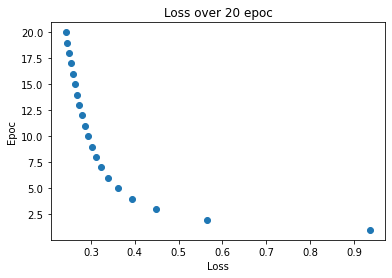

In [192]:
# Plot loss function pada setiap epoc
import matplotlib.pyplot as plt

plt.scatter(x = loss_each_epoc, y= [x+1 for x in range(len(loss_each_epoc))])
plt.xlabel('Loss')
plt.ylabel('Epoc')
plt.title('Loss over 20 epoc')

In [193]:
loss_each_epoc

[0.9370314290979302,
 0.5640252471532697,
 0.4495844337263821,
 0.39435718162850253,
 0.3617329597361122,
 0.3399229339143248,
 0.3240455875998014,
 0.3117435446554834,
 0.3017508873487664,
 0.2933325650691057,
 0.2860353716078117,
 0.2795662798720004,
 0.27372838451667164,
 0.2683850796477088,
 0.26343900542592813,
 0.25881914890889945,
 0.2544726567101624,
 0.25035947812643833,
 0.24644876641183844,
 0.2427164043839823]

#### Generating Prediction

Now, we already optimized our model during training process, we observed as we iterate through our learning process, the average loss is going down.

Now, we will try to generate prediction on rating, Let say we want to predict the rating on user 1 on item 1, Here is the process :     
1. Get all parameters $bu,bi,pu,qi$
2. Create prediction function
3. Generate Prediction

**Get all parameters $bu,bi,pu,qi$**

parameter for user 1 and item 1

In [196]:
user_1_index = user_to_index[7]
movie_1_index = movie_to_index[7]

In [197]:
# Assign bias
bu_1 = bu[user_1_index]
bi_1 = bi[movie_1_index]

# Assign factor
pu_1 = pu[user_1_index]
qi_1 = qi[movie_1_index]

In [198]:
# Buat fungsi prediksi
baseline_pred = global_mean + bu_1 + bi_1

pred_ratings = baseline_pred + (pu_1.dot(qi_1.T))
print('Prediksi rating User 1 dan Item 1', pred_ratings)

Prediksi rating User 1 dan Item 1 2.011582079356261


In [199]:
# Buat object SVD sebagai class
class FunkSVD():
    
    def __init__(self, n_fact = 50, n_epoc=20, lr = 0.001, lambda_reg=0.002) -> None:
        """
        Inisialisasi Model Hyperparameter / Configuration
        
        Parameters
        ----------
        n_fact : int
            Jumlah latent factor untuk digunakan
            
        n_epoc : int
            Jumlah iterasi selama model training (epoc)
            
        lr : float
            learning rate
        
        lambda_reg : float
            Regularisasi untuk objek fungsi / model parameter
            
        Returns
        -------
        -
        """
        self.n_fact = n_fact
        self.n_epoc = n_epoc
        self.lr = lr
        self.lambda_reg = lambda_reg
        
    def generate_mapping(self):
        """
        Fungsi untuk generate mapping untuk userid dan movieid
        """
        self.user_to_index = { user_id : index for index, user_id in
                                     enumerate(self.utility_matrix[self.user_column].unique())}
        
        self.index_to_user = { index : user_id for index, user_id in
                                     enumerate(self.utility_matrix[self.user_column].unique())}
        
        self.item_to_index = { item_id : user_id for index, item_id in
                                     enumerate(self.utility_matrix[self.item_column].unique())}
        
        self.index_to_item = { index : item_id for index, item_id in
                                     enumerate(self.utility_matrix[self.item_column].unique())}
        
    def init_params(self):
        """
        Initialisasi bias dan latent factor matrix.
        
        Parameters
        ----------
        n_user : int
            Jumlah unik user
        
        n_item : int
            Jumlah unik item
        
        n_fact : int
            Jumlah faktor
        
        Returns
        -------
        bu : numpy.array
            Vektor user bias
            
        bi : numpy.array
            Vektor item bias
            
        pu : numpy.array
            Matrix user latent faktor
            
        qi : numpy.array
            Matrix item latent faktor
        """
        bu = np.zeros(self.n_users)
        bi = np.zeros(self.n_items)
        
        pu = np.random.normal(0, .1, (self.n_users, self.n_fact))
        qi = np.random.normal(0, .1, (self.n_items, self.n_fact))
        
        return bu, bi, pu, qi
    
    def update_params(self, n_epoc, global_mean, bu, bi, pu, qi):
        """
        Fungsi untuk update parameter dengan gradient descent
        
        Parameters
        ----------
        n_epoc : int
            Jumlah epoc
        global_mean : float
            Global mean untuk menghitung prediksi baseline
        bu : numpy.array
            Vektor user bias
        bi : numpy.array
            Vektor item bias
        pu : numpy.array
            latent faktor user matrix 
        qi : numpy.array
            latent faktor item matrix 
            
        Returns
        --------
        bu : numpy.array
            Update vektor user bias
        bi : numpy.array
            Update vektor item bias
        pu : numpy.array
            Update latent faktor user matrix 
        qi : numpy.array
            Update latent faktor item matrix 
        loss_each_epoc : list
            Average loss each epoc
        
        """
        # Copy parameter untuk menghindari tertimpa
        bu = bu.copy()
        bi = bi.copy()
        pu = pu.copy()
        qi = qi.copy()
        
        # Update parameter
        loss_each_epoc = []
        for i in range(n_epoc):
            # Tambahkan list kosong untuk menambah rata-rata loss tiap epoc
            avg_loss_train_samples = []
            # Iterasi seluruh data training
            for train_sample in rating_matrix_funk:
                # Ekstraksi UserID, MovieIDs, Ratings
                user = int(train_sample[0])
                movie = int(train_sample[1])
                rating = train_sample[2]

                # Dapatkan index User
                user_index = user_to_index[user]
                movie_index = movie_to_index[movie]

                # Prediksi Rating
                # Filter setiap parameter
                b_user = bu[user_index]
                b_item = bi[movie_index]
                p_user = pu[user_index]
                q_item = qi[movie_index]

                # Menghitung baseline prediction
                baseline_predict = global_mean + b_user + b_item

                pred_rating = baseline_predict + (p_user.dot(q_item.T))

                # Hitung loss / objective
                loss = 1/2*((rating - pred_rating)**2) + lambda_reg*(b_user**2 + b_item**2 + norm(p_user)**2 + norm(q_item)**2)

                # Tambahkan komponen loss
                avg_loss_train_samples.append(loss)

                # Hitung gradient, dy / d(parameter)
                gradient_user_bias = (rating - pred_rating) - lambda_reg*b_user
                gradient_item_bias = (rating - pred_rating) - lambda_reg*b_item
                gradient_user_factor = (rating - pred_rating) - lambda_reg*p_user
                gradient_item_factor = (rating - pred_rating) - lambda_reg*q_item

                # Hitung gradient, dy / d(parameter)
                bu[user_index] += lr * gradient_user_bias
                bi[movie_index] += lr * gradient_item_bias
                pu[user_index] += lr * gradient_user_factor
                qi[movie_index] += lr * gradient_item_factor
            avg_loss_train_samples = np.mean(avg_loss_train_samples)
            loss_each_epoc.append(avg_loss_train_samples)
        
        return bu, bi, pu, qi, loss_each_epoc
    
    def fit(self, utility_matrix, user_column, item_column, utility_column):
        """
        Fungsi untuk fitting utility matrix
        
        Parameters
        ----------
            utility_matrix (pd.DataFrame): _description_
            user_column (str): _description_
            item_column (str): _description_
            utility_column (str): _description_

        Returns :
        -----------
        self (object)
               
        """
        self.utility_matrix = utility_matrix
        self.user_column = user_column
        self.item_column = item_column
        self.utility_column = utility_column

        # setting position of column
        self.utility_matrix = self.utility_matrix[[self.user_column,self.item_column,self.utility_column]]
        # yield number of user
        self.n_users = self.utility_matrix[self.user_column].nunique()
        # yield number of items
        self.n_items = self.utility_matrix[self.item_column].nunique()

        # create id_mapping for user & item
        self.generate_mapping()

        # convert to numpy array
        self.utility_matrix = self.utility_matrix.to_numpy()


        # initialize parameters
        bu,bi,pu,qi = self.init_params()

        # extract global mean
        self.global_mean = self.utility_matrix[:,2].mean()

        # update parameters
        bu_updated, bi_updated, pu_updated,qi_updated,loss = self.update_params(n_epoc = self.n_epoc,
                                                                                global_mean = self.global_mean,
                                                                                bu= bu, bi= bi, pu= pu, qi= qi)


        # set updated parameter as part of object
        self.bu = bu_updated
        self.bi = bi_updated
        self.pu = pu_updated
        self.qi = qi_updated
        
    def predict_rating(self,user,item) :
        """


        Parameters :
        -----------
            utility_matrix (pd.DataFrame): _description_
            user_column (str): _description_
            item_column (str): _description_
            utility_column (str): _description_

        Returns :
        -----------
        self (object)
        """

        # get user idx
        user_index = self.user_to_index[user]
        item_index = self.item_to_index[item]
        # predict rating

        # slice each parameter
        b_user = self.bu[user_index]
        b_item = self.bi[item_index]
        p_user = self.pu[user_index]
        q_item = self.qi[item_index]

        # calculate baseline prediction
        baseline_prediction = self.global_mean + b_user + b_item

        predicted_rating = baseline_prediction + (p_user.dot(q_item.T))

        return predicted_rating

In [213]:
model = FunkSVD()
tqdm(model.fit(utility_matrix= df_ratings, user_column='UserID',
          item_column= 'MovieIDs',utility_column= 'Ratings'))

C:\Users\Axel\AppData\Local\Temp/ipykernel_25092/160660861.py:152: RuntimeWarning: overflow encountered in double_scalars
  loss = 1/2*((rating - pred_rating)**2) + lambda_reg*(b_user**2 + b_item**2 + norm(p_user)**2 + norm(q_item)**2)
C:\Users\Axel\AppData\Local\Temp/ipykernel_25092/160660861.py:149: RuntimeWarning: invalid value encountered in double_scalars
  pred_rating = baseline_predict + (p_user.dot(q_item.T))
C:\Users\Axel\AppData\Local\Temp/ipykernel_25092/160660861.py:164: RuntimeWarning: invalid value encountered in double_scalars
  bu[user_index] += lr * gradient_user_bias
C:\Users\Axel\AppData\Local\Temp/ipykernel_25092/160660861.py:166: RuntimeWarning: invalid value encountered in add
  pu[user_index] += lr * gradient_user_factor
C:\Users\Axel\AppData\Local\Temp/ipykernel_25092/160660861.py:165: RuntimeWarning: invalid value encountered in double_scalars
  bi[movie_index] += lr * gradient_item_bias
C:\Users\Axel\AppData\Local\Temp/ipykernel_25092/160660861.py:167: Runtime

In [216]:
model.predict_rating(user=1,item=7)

nan

# Train Recommender System Model

In [217]:
# Inisiasai rating scale
reader = Reader(rating_scale = (1, 5))
reader

### Data Preparation

In [218]:
utility_data_funk = Dataset.load_from_df(
                    df = df_ratings[['UserID', 'MovieIDs', 'Ratings']].copy(),
                    reader = reader
                )

utility_data_funk

In [219]:
utility_data_funk.df.head()

,UserID,MovieIDs,Ratings
0,1,1193,5.0
1,1,661,3.0
2,1,914,3.0
3,1,3408,4.0
4,1,2355,5.0


### Split Train-Test
---

In [220]:
# Bagi dataset
full_data, train_data, test_data = train_test_split(utility_data_funk,
                                                    test_size = 0.2,
                                                    random_state = 42)

In [221]:
# Validasi pembagian dataset
train_data.n_ratings, len(test_data)

(57076, 14269)

### Create the Model
---

**Model Candidate**

1. Baseline Model ( Mean Prediction)  (does not have hyperparameter)
2. Funk SVD, (Not SVD)

In [222]:
# Load the model library
# i.e. Baseline, SVD
from surprise import AlgoBase, SVD

**Train Baseline Model**

In [223]:
model_baseline_funk = MeanPrediction()
model_baseline_funk

In [224]:
# Gunakan full_data dari cross validation
cv_baseline = cross_validate(algo = model_baseline,
                            data = full_data,
                            cv = 5,
                            measures = ['rmse'])

In [225]:
# Ekstraksi hasil CV
cv_baseline_rmse = cv_baseline['test_rmse'].mean()
cv_baseline_rmse

1.062800665832617

to perform RandomizedSearchCV, `RandomizedSearchCV(algo_class, param_distributions,cv)`

- **algo_class** : surprise model class, in our case, we are using **KNNBaseline** class, so algo_class=KNNBaseline

- **param_distributions** :  dictionary containing param grid, the values should be in `list`

- **cv** : number of fold to split, commonly 5


**Train SVD Model**

Hyperparameter that are in Funk SVD models are :     
- $\gamma$ : Learning Rate
- n_factors : Number of letent factor
- $\lambda$ : Regularization strength

Hyperparameter Candidate :     
1. Learning Rate ($\gamma$)

For this experiment we will try several values

[1,0.1,0.01,0.001,0.0001]

2. Number of latent factors
For this experiment we will try some values :    

[50,100,200]

3. Regularization Strength

[1,0.1,0.01,0.02]


In [226]:
# Buat dictionary untuk parameters
params_SVD = {'lr_all' : [1,0.1,0.01,0.001,0.0001], 'n_factors': [50,100,200],
              'reg_all' : [1,0.1,0.01,0.02]
             }

In [227]:
tuning_svd = RandomizedSearchCV(algo_class=SVD, param_distributions=params_SVD,
                                cv = 5
                               )

In [ ]:
tuning_svd.fit(data=full_data)

**Perbandingan Performa**

In [673]:
summary_df = pd.DataFrame({'Model': ['Baseline', 'Funk SVD'],
                           'CV Performance - RMSE': [cv_baseline_rmse,tuning_svd.best_score['rmse'] ],
                           'Model Condiguration':['N/A',f'{tuning_svd.best_params["rmse"]}']})

summary_df

,Model,CV Performance - RMSE,Model Condiguration
0,Baseline,1.052447,N/A
1,Funk SVD,0.887541,"{'lr_all': 0.01, 'n_factors': 200, 'reg_all': ..."


**Kombinasi Hyperparameter Terbaik**

In [674]:
tuning_svd.best_params

{'rmse': {'lr_all': 0.01, 'n_factors': 200, 'reg_all': 0.1},
 'mae': {'lr_all': 0.01, 'n_factors': 200, 'reg_all': 0.1}}

In [675]:
best_params_svd = tuning_svd.best_params['rmse']

In [676]:
# Buat object
model_best = SVD(**best_params_svd)

# Train data ke seluruh dataset
model_best.fit(train_data)

#### Evaluasi Model Terbaik

**Evaluasi RMSE**

In [677]:
# Import library
from surprise import accuracy

In [678]:
test_pred = model_best.test(test_data)
test_rmse = accuracy.rmse(test_pred)
test_rmse

RMSE: 0.8868


0.8867528619551197

In [679]:
summary_test_df = pd.DataFrame({'Model' : ['User to User CF'],
                                'RMSE-Tuning': [tuning_svd.best_score['rmse']],
                                'RMSE-Test': [test_rmse]})

summary_test_df

,Model,RMSE-Tuning,RMSE-Test
0,User to User CF,0.887541,0.886753


## Prediksi Rekomendasi

Decision Process is to recommend items to user
from our trained model

<image src="https://www.mdpi.com/applsci/applsci-10-05510/article_deploy/html/images/applsci-10-05510-g001.png" image>




1. User to User Collaborative Filtering

  We already trained our best model on full dataset, now its time to utilize our model to generate recommendation.


In [680]:
# Prediksi menggunakan rating user 9 dan movie 10
sample_pred = model_best.predict(uid = 9,
                                      iid = 10)

In [681]:
sample_pred

Prediction(uid=9, iid=10, r_ui=None, est=3.601422098494135, details={'was_impossible': False})

In [682]:
# Prediksi seluruh unseen/unrated movie oleh user 9
unique_movie_id = set(df_ratings['MovieIDs'])
print(unique_movie_id)

{1, 2, 3, 2053, 2054, 10, 11, 16, 17, 2064, 19, 18, 21, 2072, 32, 2081, 34, 2082, 2080, 2085, 39, 41, 44, 2092, 2096, 2097, 50, 2102, 58, 2107, 2108, 2109, 62, 2111, 64, 2110, 2114, 2115, 2116, 2117, 70, 73, 2122, 2124, 2126, 85, 2134, 88, 2139, 2140, 95, 2146, 105, 2153, 110, 111, 2160, 2161, 2163, 118, 2167, 2174, 145, 2194, 150, 151, 152, 2201, 2202, 160, 166, 171, 172, 180, 2231, 185, 188, 2243, 2245, 2252, 2253, 216, 2268, 222, 2273, 227, 229, 2278, 231, 235, 2288, 2291, 2294, 246, 2302, 256, 2306, 260, 2311, 2312, 265, 266, 267, 2318, 2321, 273, 2324, 280, 2329, 288, 290, 2340, 293, 296, 2344, 2352, 306, 2355, 315, 316, 318, 319, 2369, 2376, 2381, 338, 339, 340, 342, 2393, 2394, 2395, 2396, 349, 356, 357, 2405, 2407, 2404, 358, 2412, 2413, 366, 367, 2416, 370, 2420, 2421, 2423, 376, 377, 380, 2428, 2431, 2433, 2434, 392, 407, 2456, 2457, 2463, 419, 2470, 428, 429, 2476, 431, 432, 2481, 435, 440, 441, 2490, 442, 2491, 446, 2496, 2501, 454, 2502, 457, 459, 464, 2513, 466, 2514, 251

In [683]:
# MovieIDs yang telah dinilai oleh user 9
rated_movie_id = set(df_ratings.loc[df_ratings['UserID']==9, 'MovieIDs'])
print(rated_movie_id)

{1, 778, 2571, 524, 2959, 1784, 16, 1682, 912, 2324, 150, 920, 1307, 1060, 3751, 1704, 2599, 2858, 3114, 1961, 428, 1584, 50, 2355, 3253, 1721, 1466, 1210, 1213, 318, 838, 1223, 457, 2890, 2762, 3148, 590, 1358, 720, 3793, 1617, 593, 3408, 597, 1233, 3160, 2268, 1500, 349, 608, 480, 3298, 994, 2278, 1639, 3948, 2028, 367, 1393, 1265, 2294, 1912, 377, 508, 2302}


In [684]:
# Dapatkan unrated MovieIDs
unrated_movie_id = unique_movie_id.difference(rated_movie_id)
print(unrated_movie_id)

{2, 3, 2053, 2054, 10, 11, 17, 2064, 19, 18, 21, 2072, 32, 2081, 34, 2082, 2080, 2085, 39, 41, 44, 2092, 2096, 2097, 2102, 58, 2107, 2108, 2109, 62, 2111, 64, 2110, 2114, 2115, 2116, 2117, 70, 73, 2122, 2124, 2126, 85, 2134, 88, 2139, 2140, 95, 2146, 105, 2153, 110, 111, 2160, 2161, 2163, 118, 2167, 2174, 145, 2194, 151, 152, 2201, 2202, 160, 166, 171, 172, 180, 2231, 185, 188, 2243, 2245, 2252, 2253, 216, 222, 2273, 227, 229, 231, 235, 2288, 2291, 246, 256, 2306, 260, 2311, 2312, 265, 266, 267, 2318, 2321, 273, 280, 2329, 288, 290, 2340, 293, 296, 2344, 2352, 306, 315, 316, 319, 2369, 2376, 2381, 338, 339, 340, 342, 2393, 2394, 2395, 2396, 356, 357, 2405, 2407, 2404, 358, 2412, 2413, 366, 2416, 370, 2420, 2421, 2423, 376, 380, 2428, 2431, 2433, 2434, 392, 407, 2456, 2457, 2463, 419, 2470, 429, 2476, 431, 432, 2481, 435, 440, 441, 2490, 442, 2491, 446, 2496, 2501, 454, 2502, 459, 464, 2513, 466, 2514, 2517, 2518, 472, 2527, 2529, 479, 2531, 483, 487, 2539, 2542, 494, 2549, 502, 506, 50

In [685]:
predicted_unrated_movie = get_pred_unrated_item(userid = 9,
                                                est = model_best,
                                                unrated_item_id = unrated_movie_id)

predicted_unrated_movie.head()

,UserID,MovieIDs,Pred_Rating
380,9,1198,4.449005
635,9,2019,4.427475
478,9,3469,4.389990
386,9,1207,4.379637
89,9,260,4.332613


In [686]:
# top k rating tertinggi
k = 5
top_movie = predicted_unrated_movie.head(k).copy()
top_movie

,UserID,MovieIDs,Pred_Rating
380,9,1198,4.449005
635,9,2019,4.427475
478,9,3469,4.389990
386,9,1207,4.379637
89,9,260,4.332613


In [688]:
# Tambahkan movie title
top_movie['Title'] = movie_data.loc[top_movie['MovieIDs'], 'Title'].values
top_movie['Genre'] = movie_data.loc[top_movie['MovieIDs'], 'Genre'].values

top_movie

,UserID,MovieIDs,Pred_Rating,Title,Genre
380,9,1198,4.449005,"Big Blue, The (Le Grand Bleu) (1988)",Adventure|Romance
635,9,2019,4.427475,Popeye (1980),Adventure|Comedy|Musical
478,9,3469,4.389990,East is East (1999),Comedy
386,9,1207,4.379637,Amadeus (1984),Drama
89,9,260,4.332613,Ladybird Ladybird (1994),Drama


In [689]:
# Dapatkan top 10 rekomendasi untuk user 100
retrieve_top_highest_unrated(est=model_best,
                            k=10,
                            userid=100,
                            rating_data=df_ratings,
                            movie_data=movie_data)

,UserID,MovieIDs,Pred_Rating,Title,Genre
25,100,50,4.053944,Guardian Angel (1994),Action|Drama|Thriller
650,100,2019,3.966302,Popeye (1980),Adventure|Comedy|Musical
397,100,1207,3.912524,Amadeus (1984),Drama
303,100,922,3.907404,Father of the Bride (1950),Comedy
298,100,912,3.892032,2001: A Space Odyssey (1968),Drama|Mystery|Sci-Fi|Thriller
260,100,750,3.883357,Stalingrad (1993),War
394,100,1204,3.877129,Full Metal Jacket (1987),Action|Drama|War
271,100,2858,3.877009,Brief Encounter (1946),Drama|Romance
381,100,1136,3.863945,He Walked by Night (1948),Crime|Film-Noir|Thriller
621,100,1945,3.846151,Freaky Friday (1977),Children's|Comedy


In [690]:
# Dapatkan top 10 rekomendasi untuk user 500
retrieve_top_highest_unrated(est=model_best,
                            k=10,
                            userid=500,
                            rating_data=df_ratings,
                            movie_data=movie_data)

,UserID,MovieIDs,Pred_Rating,Title,Genre
646,500,2019,4.351212,Popeye (1980),Adventure|Comedy|Musical
389,500,1207,4.344728,Amadeus (1984),Drama
272,500,858,4.300077,Kansas City (1996),Crime
648,500,2028,4.293521,Something Wicked This Way Comes (1983),Children's|Horror
382,500,1198,4.285818,"Big Blue, The (Le Grand Bleu) (1988)",Adventure|Romance
492,500,3508,4.272904,Two Moon Juction (1988),Drama
618,500,1945,4.267282,Freaky Friday (1977),Children's|Comedy
386,500,1204,4.259456,Full Metal Jacket (1987),Action|Drama|War
101,500,2329,4.257538,Miracle on 34th Street (1947),Drama
482,500,3469,4.252595,East is East (1999),Comedy
